<a href="https://colab.research.google.com/github/ling-zhang-linnet/two-stage-dcopf-neural-solver/blob/main/additional_experiments_reserve_scheduling_118bus_learning_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/gdrive')

# Insert the directory
import sys
# sys.path.insert(0,'/content/gdrive/MyDrive/Inbox/reserve_fromLocal')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# from pyomo.environ import *
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
parentFolder = '/content/gdrive/MyDrive/Inbox/Simulation2/'

In [ ]:
!nvidia-smi

Mon Nov  7 23:50:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# params.py


In [ ]:
# params.py
# SET PARAMETERS THAT ARE GOING TO BE USED EVERYWHERE

# OPTIONS for caseID:
# no_wind: all generators are regular (controllable)
# wind_penetration: set one of the generators to be wind power
caseID = 'no_wind'

realTimeDemandStdevFactor = 0.05
inputDemandStdevFactor = 0.1

realTimeWindStdevFactor = 0.05
inputWindStdevFactor = 0.1

maxNumInstances = 50000
minNumInstances = 100

nnNumTestFactor = 0.1

nnNumTrain = 50000
nnNumPreTrain = 100
nnNumTest = 1000

maxNumScenarios = 500
minNumScenarios = 10
# use a small number to test if codes run correctly
# numScenarios = minNumScenarios

# to run on google colab, set parentFolder = '/content/gdrive/MyDrive/Your folder path/'
# to run locally:
# parentFolder = ''
paramsPath39Bus = parentFolder + '39bus/params/'
inputDemandPath39Bus = parentFolder + '39bus/inputDemand/'
savedPreTrainPath39Bus = parentFolder + '39bus/savedPreTrain/'
savedTrainPath39Bus = parentFolder + '39bus/savedTrain/'

paramsPath118Bus = parentFolder + '118bus/params/'
inputDemandPath118Bus = parentFolder + '118bus/dataset/'
savedPreTrainPath118Bus = parentFolder + '118bus/savedPreTrainModels2/'
savedTrainPath118Bus = parentFolder + '118bus/savedTrainModels2/'
summaryPath118Bus = parentFolder + '118bus/summary/'

reservesCostFactor = 1.5
windReservesCostFactor = 0.1

# The default max_iter is 3000
maximumIterations_glpk = 2500
tolerance_glpk = 1e-6

# number of scenarios for estimating cost of recourse stage (i.e., Q) in learning methods
numMCScenarios = 20

# then, generate an independent batch of scenarios for evaluating quality of solutions of ALL METHODS
numAnalyticalScenarios = 10000


# penalty parameters
gammaRes = 10
gammaGen = 1e3
gammaLine = 1e3

delta_line = 0.95
delta_gen = 0.95

theta_max = np.pi/2
theta_min = -theta_max

# data.py

In [ ]:
# GENERATE ALL DATA
import numpy as np
from scipy.linalg import cholesky

# from params import *


def generateCorrMat(numBuses, numFactors):
    W = np.random.randn(numBuses, numFactors)
    S = W@W.T + np.diag(np.random.rand(1, numBuses))
    S = np.diag(1. / np.sqrt(np.diag(S))) @ S @ np.diag(1. / np.sqrt(np.diag(S)))
    S = np.round(S, 4)

    return S


def generateInputDemands(predMeanDemand, numBuses, zeroLoads, inputDemandPath):
    assert len(predMeanDemand) == numBuses

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = inputDemandStdevFactor * predMeanDemand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    demandCorrMat = generateCorrMat(numBuses, numBuses)
    np.save(inputDemandPath + 'demandCorrMat.npy', demandCorrMat)

    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    totalNumInstances = nnNumTrain + nnNumPreTrain + nnNumTest
    stdNormalData = np.random.multivariate_normal([0.]*numBuses, np.eye(numBuses), totalNumInstances)
    allData = demandCovMat_chol@stdNormalData.T + np.repeat(predMeanDemand.reshape(-1, 1), totalNumInstances, axis=-1)
    allData = allData.T

    # set zero loads to be zero
    allData[:, zeroLoads] = 0.

    # Alternative way to generate input demands for many instances
    # demandCorrMat = np.eye(numLoads)
    # demandCovMat = np.diag(inputDemandStdev)*demandCorrMat*np.diag(inputDemandStdev)
    # demandCovMat_chol
    # omega_d_tmp = np.random.multivariate_normal(0.0, 1.0, numInstances)
    # allData = demandCovMat_chol*omega_d_tmp + predMeanDemand

    nnTestData = allData[:nnNumTest, :]
    nnPreTrainData = allData[-nnNumPreTrain:, :]
    nnTrainData = allData[nnNumTest:-nnNumPreTrain, :]

    np.save(inputDemandPath + 'nnTrainData.npy', nnTrainData)
    np.save(inputDemandPath + 'nnPreTrainData.npy', nnPreTrainData)
    np.save(inputDemandPath + 'nnTestData.npy', nnTestData)


# generate {numScenarios} real-time demand scenarios for a particular instance
def generateRealTimeScenarios(predMeanDemand, numBuses, zeroLoads, numScenarios,
                              inputDemandPath, windPred=None):

    assert len(predMeanDemand) == numBuses

    # standard deviation of loads/demands. keep this small enough to be realistic
    demandStdev = realTimeDemandStdevFactor * predMeanDemand
    # for zero stdev, set them to be small, i.e., 0.1
    demandStdev = np.where(demandStdev < 1e-5, 0.1, demandStdev)

    # randomly generated correlation matrix for the demands
    demandCorrMat = np.load(inputDemandPath + 'demandCorrMat.npy')

    demandCovMat = np.diag(demandStdev) @ demandCorrMat @ np.diag(demandStdev)
    # store the Cholesky factorization of the demand covariance matrix for numerical efficiency
    demandCovMat_chol = cholesky(demandCovMat, lower=True)

    # tailored implementation of multivariate normal distribution for demand scenarios
    stdNormalData = np.random.multivariate_normal([0.] * numBuses, np.eye(numBuses), numScenarios)
    d_omega = demandCovMat_chol@stdNormalData.T + np.repeat(predMeanDemand.reshape(-1, 1), numScenarios, axis=-1)
    d_omega = d_omega.T

    # set zero load to be zero
    d_omega[:, zeroLoads] = 0.

    w_omega = None
    if caseID == 'wind_penetration' and windPred:
        realTimeWindStdev = realTimeWindStdevFactor * windPred
        # for zero stdev, set them to be small, i.e., 0.1
        realTimeWindStdev = np.where(realTimeWindStdev < 1e-5, 0.1, realTimeWindStdev)

        w_omega = np.random.multivariate_normal(windPred, np.diag(realTimeWindStdev), numScenarios)
        # w_omega = np.clip(w_omega, a_min=0., a_max=None)

    return d_omega, w_omega


# utilities118bus.py

In [ ]:
# utilities.py
# UTILITY FUNCTIONS AND DEFINITIONS
import os
import numpy as np
import pandas as pd
import json

# from params import *


# create a new directory if it does not exist
def create_dir(path):
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)
        print("The new directory is created!")


# calculate row-wise l2 distance
def measure_relative_distance(v1, v2):
    distance_vec = np.linalg.norm(v1 - v2, axis=1) / np.linalg.norm(v1, axis=1)

    return np.mean(distance_vec)


def toIntList(numList):
    intList = [int(x) for x in numList]

    return intList


def identifyUniqueLines(ieeeNetwork, connections):
    all_lines = {}
    count = 0
    for line in connections:
        all_lines[count] = line
        count += 1

    # The following codes only find out the repeated lines that have exactly the same order of nodes,
    # but do not deal with the case where [i,j] and [j,i] are also repeated lines
    # Luckily, by checking connections, there is no repeated lines like [i,j] and [j,i]
    unique_lines = {}
    for k, val in all_lines.items():
        if val not in unique_lines.values():
            unique_lines[k] = val

    if ieeeNetwork == '118bus':
        repeated_lines = [[42, 49], [49, 54], [56, 59], [49, 66], [77, 80], [89, 90], [89, 92]]
        # For example, [42, 49] appears twice
        set1 = {}
        set2 = {}
        for k, val in all_lines.items():
            if val in repeated_lines and k in unique_lines:
                set1[val[0], val[1]] = k  # Record the repeated lines when they first appear
            if val in repeated_lines and k not in unique_lines:
                set2[val[0], val[1]] = k  # Record the repeated lines when they appear more than once
    else:
        repeated_lines = []

    return unique_lines, repeated_lines


# read data csv files
def readDataFromFiles(ieeeNetwork, paramsPath):
    print('==== Read data from files. ====')

    allBusesFileName = ieeeNetwork + '_BusData.csv'
    allGenFileName = ieeeNetwork + '_GenData.csv'
    BranchFileName = ieeeNetwork + '_BranchData.csv'

    bus_data_df = pd.read_csv(paramsPath + allBusesFileName, header=None)
    gen_data_df = pd.read_csv(paramsPath + allGenFileName, header=None)
    branch_data_df = pd.read_csv(paramsPath + BranchFileName, header=None)

    # *========== NETWORK TOPOLOGY ==========

    numBuses = bus_data_df.shape[0]
    numGen = gen_data_df.shape[0]
    numRegGen = numGen
    numWindGen = 0
    numLines = branch_data_df.shape[0]

    listOfNums = dict()
    listOfNums['numBuses'] = numBuses
    listOfNums['numGen'] = numGen
    listOfNums['numRegGen'] = numRegGen
    listOfNums['numWindGen'] = numWindGen
    listOfNums['numLines'] = numLines

    bus_data = bus_data_df.to_numpy()
    gen_data = gen_data_df.to_numpy()
    branch_data = branch_data_df.to_numpy()

    # all buses
    maskOutPQBus = [True if bus_data[i, 1] == 1 else False for i in range(bus_data.shape[0])]
    maskOutPVBus = [True if bus_data[i, 1] == 2 else False for i in range(bus_data.shape[0])]
    maskOutSlackBus = [True if bus_data[i, 1] == 3 else False for i in range(bus_data.shape[0])]

    # list of loads at a particular bus (P-Q bus)
    # PQBusList = bus_data[:, 0][maskOutPQBus]
    # loadList = PQBusList
    # listOfNums['numLoads'] = len(loadList)

    # list of regular generators at a particular bus (P-V bus)
    PVBusList = bus_data[:, 0][maskOutPVBus]
    regGenList = gen_data[:, 0].tolist()
    assert len(regGenList) == numGen

    regGenSet = [x - 1 for x in regGenList]
    nonRegGenSet = []
    for x in range(numBuses):
        if x not in regGenSet:
            nonRegGenSet.append(x)

    # slack bus
    slackBus = bus_data[:, 0][maskOutSlackBus][0]
    listOfNums['slackBusNo'] = int(slackBus)

    # check to see if these are type 4 bus
    # assert len(PQBusList) + len(PVBusList) + 1 == numBuses, print('add type 4 buses!')

    # list of wind generators at a particular bus
    windGenList = []
    # if caseID == "wind_penetration":
    # modify windGenList
    # modify regGenList if needed
    genList = list(regGenList) + windGenList

    # form connections as a list of tuples
    connections = []
    branches = branch_data[:, :2]
    for i in range(branches.shape[0]):
        connections.append([int(branches[i, 0]), int(branches[i, 1])])

    if ieeeNetwork == '118bus':
        unique_lines, repeated_lines = identifyUniqueLines(ieeeNetwork, connections)
    else:
        unique_lines, _ = identifyUniqueLines(ieeeNetwork, connections)
    # modify number of lines
    numUniqueLines = len(unique_lines)
    listOfNums['numUniqueLines'] = numUniqueLines

    # *========== DEMAND DATA ===========
    # form nominal demand data
    # note that loads and generators can connect to a same bus
    demandFactor = 1.0
    demand_data = bus_data[:, 2]/10
    demand_data *= demandFactor
    posDemands = []
    posDemandsList = []
    for i, d in enumerate(demand_data):
        if d > 0.:
            posDemands.append(d)
            posDemandsList.append(i + 1)
    # modify number of loads
    numPosDemands = len(posDemands)
    listOfNums['numPosDemands'] = numPosDemands

    # predMeanDemand = [0.0 if idx in regGenSet else x for idx, x in enumerate(demand_data)]
    predMeanDemand = demand_data

    # modify meanDemand if needed
    # i.e., set zero load to be baseLoad in case zero stdev

    # Alternative way to set demands at buses:
    # sumMeanDemand = 280.0 * demandFactor
    # numLoads = 29
    # distributionFactor = np.random.randint(low=1, high=numLoads+1, size=numLoads)
    # distributionFactor /= distributionFactor.sum()
    # meanDemand = [sumMeanDemand*x for x in distributionFactor]

    # *========== GENERATOR BOUNDS ===========
    # lower and upper power bounds for regular generators (p_min and p_max)
    # setting 1:
    # regGenMaxP = gen_data[:, 8]/10
    # setting 2: reference from paper Kannan 2020
    # regGenMaxP = [30.0, 30.0, 30.0, 300.0, 300.0, 30.0, 100.0, 30.0, 30.0, 300.0, 350.0,
    #               30.0, 30.0, 100.0, 30.0, 100.0, 30.0, 30.0, 100.0, 250.0, 250.0, 100.0,
    #               100.0, 200.0, 200.0, 100.0, 420.0, 420.0, 300.0, 80.0, 30.0, 30.0, 20.0,
    #               100.0, 100.0, 300.0, 100.0, 30.0, 300.0, 200.0, 20.0, 50.0, 300.0, 300.0,
    #               300.0, 20.0, 100.0, 100.0, 10000.0, 50.0, 100.0, 100.0, 100.0, 50.0]
    # regGenMaxP = np.array(regGenMaxP) * 5
    # regGenMaxP = regGenMaxP.tolist()
    # setting 3: modified from paper Kannan 2020, by half the bounded bounds
    regGenMaxP = [300., 300., 300., 500., 500., 300., 500., 300., 300., 500.,
                  550., 150., 150., 500., 150., 500., 150., 150., 500., 550.,
                  550., 500., 500., 550., 550., 500., 550., 550., 500., 400.,
                  150., 150., 500., 500., 500., 1500., 500., 150., 500., 550.,
                  500., 250., 500., 500., 500., 500., 500., 500., 500., 250.,
                  500., 500., 500., 250.]
    regGenMaxP = np.array(regGenMaxP) / 2
    # regGenMaxP = regGenMaxP.tolist()

    regGenMinP = gen_data[:, 9]
    # set the most expensive generator (which is bus 4 starting from 0) to have
    # unbounded generation capacity to have complete recourse
    # regGenMaxP[4] = np.inf

    windGenMaxP = [np.inf] * numWindGen
    windGenMinP = [0.0] * numWindGen
    # if caseID == "wind_penetration":
    # modify windGenMinP
    # modify windGenMaxP

    # *========== LINE FLOW LIMITS ===========
    # line flow limits
    lineFlowFactor = 0.85
    # flow_max = branch_data[:, 5]
    # setting1
    # flow_max = np.array([150.0, 150.0, 500.0, 150.0, 150.0, 175.0, 500.0, 500.0,
    #                      500.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 500.0, 500.0,
    #                      500.0, 175.0, 175.0, 500.0, 175.0, 500.0, 175.0, 175.0,
    #                      140.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 500.0, 175.0, 175.0, 500.0, 500.0, 500.0, 500.0,
    #                      500.0, 500.0, 500.0, 175.0, 175.0, 500.0, 175.0, 500.0,
    #                      175.0, 175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 500.0, 175.0, 500.0, 500.0, 200.0,
    #                      200.0, 175.0, 175.0, 175.0, 500.0, 500.0, 175.0, 175.0,
    #                      500.0, 500.0, 500.0, 175.0, 500.0, 500.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      200.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
    #                      175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0])
    # setting2
    flow_max = np.array([100.0, 100.0, 175.0, 100.0, 100.0, 100.0, 175.0, 175.0,
                         175.0, 100.0, 150.0, 150.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 200.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 200.0, 200.0,
                         200.0, 175.0, 175.0, 200.0, 175.0, 200.0, 175.0, 175.0,
                         140.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 500.0, 175.0, 175.0, 500.0, 500.0, 500.0, 500.0,
                         500.0, 500.0, 500.0, 175.0, 175.0, 500.0, 175.0, 500.0,
                         175.0, 175.0, 500.0, 500.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 500.0, 175.0, 500.0, 500.0, 200.0,
                         200.0, 175.0, 175.0, 175.0, 500.0, 500.0, 175.0, 175.0,
                         500.0, 500.0, 500.0, 175.0, 500.0, 500.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         200.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0, 175.0,
                         175.0, 175.0, 500.0, 175.0, 175.0, 175.0, 500.0, 175.0, 175.0, 175.0]) / 10
    flow_max *= lineFlowFactor

    # *========== FORM WEIGHTED LAPLACIAN ==========
    x = branch_data[:, 3]
    # x = np.array([0.09990, 0.04240, 0.00798, 0.10800, 0.05400, 0.02080, 0.03050, 0.02670,
    #               0.03220, 0.06880, 0.06820, 0.01960, 0.06160, 0.16000, 0.03400, 0.07310,
    #               0.07070, 0.24440, 0.19500, 0.08340, 0.04370, 0.18010, 0.05050, 0.04930,
    #               0.11700, 0.03940, 0.08490, 0.09700, 0.15900, 0.04920, 0.08000, 0.03820,
    #               0.16300, 0.08550, 0.09430, 0.03880, 0.05040, 0.08600, 0.15630, 0.03310,
    #               0.11530, 0.09850, 0.07550, 0.12440, 0.24700, 0.01020, 0.04970, 0.14200,
    #               0.02680, 0.00940, 0.03750, 0.10600, 0.16800, 0.05400, 0.06050, 0.04870,
    #               0.18300, 0.13500, 0.24540, 0.16810, 0.09010, 0.13560, 0.12700, 0.18900,
    #               0.06250, 0.32300, 0.32300, 0.18600, 0.05050, 0.07520, 0.13700, 0.05880,
    #               0.16350, 0.12200, 0.28900, 0.29100, 0.07070, 0.00955, 0.01510, 0.09660,
    #               0.13400, 0.09660, 0.07190, 0.22930, 0.25100, 0.23900, 0.21580, 0.14500,
    #               0.15000, 0.01350, 0.05610, 0.03760, 0.03860, 0.02000, 0.02680, 0.09860,
    #               0.03020, 0.09190, 0.09190, 0.21800, 0.11700, 0.03700, 0.10150, 0.01600,
    #               0.27780, 0.32400, 0.03700, 0.12700, 0.41150, 0.03550, 0.19600, 0.18000,
    #               0.04540, 0.13230, 0.14100, 0.12200, 0.04060, 0.14800, 0.10100, 0.19990,
    #               0.01240, 0.02440, 0.04850, 0.10500, 0.07040, 0.02020, 0.03700, 0.08530,
    #               0.03665, 0.13200, 0.14800, 0.06410, 0.12300, 0.20740, 0.10200, 0.17300,
    #               0.07120, 0.18800, 0.09970, 0.08360, 0.05050, 0.15810, 0.12720, 0.08480,
    #               0.15800, 0.07320, 0.04340, 0.18200, 0.05300, 0.08690, 0.09340, 0.10800,
    #               0.20600, 0.29500, 0.05800, 0.05470, 0.08850, 0.17900, 0.08130, 0.12620,
    #               0.05590, 0.11200, 0.05250, 0.20400, 0.15840, 0.16250, 0.22900, 0.03780,
    #               0.05470, 0.18300, 0.07030, 0.18300, 0.02880, 0.18130, 0.07620, 0.07550,
    #               0.06400, 0.03010, 0.20300, 0.06120, 0.07410, 0.01040, 0.00405, 0.14000, 0.04810, 0.05440])
    b = 1 / x
    # re-scale b by Z0
    # Z0 = 10
    Z0 = 2.
    b = b / Z0

    # form Adjacency matrix
    # A[i, j] = b_(i,j) if "i" is connected to "j"
    # A[i, j] = 0 otherwise
    Adjacency = np.zeros((numBuses, numBuses))
    for k, line in unique_lines.items():
        row = line[0] - 1
        col = line[1] - 1
        Adjacency[row, col] = b[k]
        Adjacency[col, row] = b[k]

    # form weighted Laplacian matrix
    B = np.zeros((numBuses, numBuses))
    for i in range(numBuses):
        for j in range(numBuses):
            if i == j:
                B[i, j] = sum(Adjacency[i, :])
            else:
                B[i, j] = -Adjacency[i, j]

    # BRemovedFirstCol = B[:, 1:]

    # form matrix to convert power injections at all buses to all line flows
    F = np.zeros((numLines, numBuses))

    for i, line in enumerate(connections):
        row = line[0] - 1
        col = line[1] - 1
        F[i, row] = Adjacency[row, col]
        F[i, col] = -Adjacency[row, col]

    # FRemovedFirstCol = F[:, 1:]

    # *========== COST COEFFICIENTS ===========
    # read generator cost data or generate generator cost data
    # regGenCost = [26.2438, 26.2438, 26.2438, 12.8875, 6.8875, 26.2438, 17.8200,
    #               26.2438, 26.2438, 12.8875, 10.7600, 26.2438, 26.2438, 17.8200,
    #               26.2438, 17.8200, 26.2438, 26.2438, 17.8200, 12.3299, 12.3299,
    #               17.8200, 17.8200, 13.2900, 13.2900, 17.8200, 8.3391, 8.3391,
    #               12.8875, 15.4708, 26.2438, 26.2438, 37.6968, 17.8200, 17.8200,
    #               12.8875, 17.8200, 26.2438, 10.7600, 12.8875, 37.6968, 22.9423,
    #               12.8875, 12.8875, 12.8875, 37.6968, 17.8200, 17.8200, 37.6968,
    #               22.9423, 17.8200, 17.8200, 17.8200, 22.9423]
    # regGenCost = np.array(regGenCost)/10
    windGenCost = [0.0] * numWindGen
    # if caseID == "wind_penetration":
    # modify windGenCost

    # *========= STORE RESULTS ==========
    # json.dump(toIntList(list(loadList)), open(paramsPath + 'loadList', 'w'))
    json.dump(toIntList(list(regGenList)), open(paramsPath + 'regGenList', 'w'))
    json.dump(toIntList(list(posDemandsList)), open(paramsPath + 'posDemandsList', 'w'))
    json.dump(listOfNums, open(paramsPath + 'listOfAllNums', 'w'))
    json.dump(connections, open(paramsPath + 'connections', 'w'))
    json.dump(unique_lines, open(paramsPath + 'unique_lines', 'w'))
    np.save(paramsPath + 'predMeanDemand.npy', predMeanDemand)
    np.save(paramsPath + 'regGenMaxP.npy', regGenMaxP)
    np.save(paramsPath + 'regGenMinP.npy', regGenMinP)
    np.save(paramsPath + 'flow_max.npy', flow_max)
    np.save(paramsPath + 'rescaled_b.npy', b)
    np.save(paramsPath + 'Adjacency.npy', Adjacency)
    np.save(paramsPath + 'fullB.npy', B)
    np.save(paramsPath + 'fullF.npy', F)
    # json.dump(regGenCost, open(paramsPath + 'regGenCost', 'w'))

    if caseID == "wind_penetration":
        np.save(paramsPath + 'windGenMaxP.npy', windGenMaxP)
        np.save(paramsPath + 'windGenMinP.npy', windGenMinP)

        json.dump(windGenList, open(paramsPath + 'windGenList', 'w'))
        json.dump(windGenCost, open(paramsPath + 'windGenCost', 'w'))


In [ ]:
# redefine paths
paramsPath = paramsPath118Bus
inputDemandPath = inputDemandPath118Bus
savedPreTrainPath = savedPreTrainPath118Bus
savedTrainPath = savedTrainPath118Bus
summaryPath = summaryPath118Bus

if not os.path.exists(inputDemandPath):
    create_dir(inputDemandPath)

if not os.path.exists(savedPreTrainPath):
    create_dir(savedPreTrainPath)

if not os.path.exists(savedTrainPath):
    create_dir(savedTrainPath)

# mod118bus.py

In [ ]:
# mod118bus.py
# 118 Bus Model based on https://www.maths.ed.ac.uk/optenergy/LocalOpt/118busnetworkmod1.html

import time
from matplotlib import pyplot as plt

# from params import *
# from utilities import *
# from data import *

# OPTIONS for methodID:
# neural: train neural networks
# true: solve SAA problem of true model (LP)
# line penalty: solve SAA problem of the line penalty model
methodID = 'neural'

# OPTIONS for fsConstrainID:
# addFSBalance: add a constraint enforcing that total initial dispatch equals to total forecasted demand
# None
fsConstrainID = 'addFSBalance'
# fsConstrainID = None

# OPTIONS for rcsConstrainID:
# addTotalBalance: force predicted theta satisfying total power injections from generators equal to total
# demand at non-generator buses
# None
# rcsConstrainID = 'addTotalBalance'
# rcsConstrainID = None

# OPTIONS for fsNNModelID:
# rcs net always use CNN
# fs net can be CNN or passthroughCNN
# fsNNModelID = 'CNN'
fsNNModelID = 'passthroughCNN'
directLinkToInput = True

# definitions
ieeeNetwork = '118bus'

# set seed for reproducibility
np.random.seed(5881)

# generate all files if they do not exist
readDataFromFiles(ieeeNetwork, paramsPath)

# *========== NETWORK TOPOLOGY ==========
listOfNums = json.load(open(paramsPath + 'listOfAllNums', 'r'))
numBuses = listOfNums['numBuses']
numGen = listOfNums['numGen']
numRegGen = listOfNums['numRegGen']
numWindGen = listOfNums['numWindGen']
# numLoads = listOfNums['numLoads']
# numLines = listOfNums['numUniqueLines']
numLines = listOfNums['numLines']
slackBusNo = listOfNums['slackBusNo']
numPosDemands = listOfNums['numPosDemands']

# map PQ buses to all buses
# loadList = json.load(open(paramsPath + 'loadList', 'r'))
posDemandsList = json.load(open(paramsPath + 'posDemandsList', 'r'))

# mask out buses with zero load
zeroLoads = []
for i in range(numBuses):
    idx = i+1
    if idx not in posDemandsList:
        zeroLoads.append(True)
    else:
        zeroLoads.append(False)

# map regular generators to buses
regGenList = json.load(open(paramsPath + 'regGenList', 'r'))
windGenList = []
if caseID == "wind_penetration":
    windGenList = json.load(open(paramsPath + 'windGenList', 'r'))

regGenSet = [x-1 for x in regGenList]
nonRegGenSet = []
for x in range(numBuses):
    if x not in regGenSet:
        nonRegGenSet.append(x)

# key is bus No. of generator and value is the order among generator set
genAtBus = dict()
visit = []
for i in range(1, numBuses+1):
    if i in regGenList:
        visit.append(i)
        genAtBus[i] = len(visit)  # index starts from 1

# given a bus idx, I want to know its order in regGenList
# ordRegGen = dict()
# for i, idx in enumerate(regGenList):
#     ordRegGen[idx] = i

B = np.load(paramsPath + 'fullB.npy')
F = np.load(paramsPath + 'fullF.npy')

# BRemovedSlack = B[:, 1:]
# FRemovedSlack = F[:, 1:]

# *========== COST COEFFICIENTS ===========
# genCost (c): cost of power from the regular + wind generators
# posResCost (cr_up): cost of up/positive reserves for the regular + wind generators
# negResCost (cr_down): cost of down/negative reserves for the regular + wind generators
# reservesCostFactor
# windReservesCostFactor

# regGenCost = np.round(np.random.uniform(10., 100., numRegGen), 3) / 10
# np.save(paramsPath + 'regGenCost.npy', regGenCost)

# regGenCost = np.load(paramsPath + 'regGenCost.npy')

regGenCost = [26.2438, 26.2438, 26.2438, 12.8875, 6.8875, 26.2438, 17.8200,
            26.2438, 26.2438, 12.8875, 10.7600, 26.2438, 26.2438, 17.8200,
            26.2438, 17.8200, 26.2438, 26.2438, 17.8200, 12.3299, 12.3299,
            17.8200, 17.8200, 13.2900, 13.2900, 17.8200, 8.3391, 8.3391,
            12.8875, 15.4708, 26.2438, 26.2438, 37.6968, 17.8200, 17.8200,
            12.8875, 17.8200, 26.2438, 10.7600, 12.8875, 37.6968, 22.9423,
            12.8875, 12.8875, 12.8875, 37.6968, 17.8200, 17.8200, 37.6968,
            22.9423, 17.8200, 17.8200, 17.8200, 22.9423]
regGenCost = np.array(regGenCost) / 2
np.save(paramsPath + 'regGenCost.npy', regGenCost)

regGenCost = list(regGenCost)
# get the highest cost
max_cost = np.max(regGenCost)
max_costID = np.argmax(regGenCost)
print('max_costID:', max_costID)
print('max_cost:', max_cost)

# *========== NORMALIZE ALL COSTS ===========
# regGenCost = [i/max_cost for i in regGenCost]

# windGenCost = [0.0] * numWindGen
# if caseID == "wind_penetration":
#     windGenCost = json.load(open(paramsPath + 'windGenCost', 'r'))
# genCost = windGenCost + regGenCost

# extend cost vector to be of length numBuses
regGenCost_copy = regGenCost.copy()
genCost_extension = np.zeros(numBuses)
for i in range(numBuses):
    idx = i + 1
    if idx in regGenList:
        genCost_extension[i] = regGenCost_copy.pop(0)

# scale reserves cost by suitable factor
regGenPosResCost = [i * reservesCostFactor for i in regGenCost]
regGenNegResCost = regGenPosResCost

# extend reserve cost to full dimensions by punishing zero demand bus with a large penalty
# full_regGenPosResCost = np.zeros(numBuses)
# for i in range(numBuses):
#     if i in regGenSet:
#         orderAmongGens = genAtBus[i+1] - 1
#         full_regGenPosResCost[i] = regGenPosResCost[orderAmongGens]
#     else:
#         full_regGenPosResCost[i] = max_cost * reservesCostFactor * 5

# full_regGenNegResCost = full_regGenPosResCost

# windGenPosResCost = [0.0] * numWindGen
# windGenNegResCost = [0.0] * numWindGen
# if caseID == "wind_penetration":
#     minRegGenPosResCost = min(regGenPosResCost)
#     minRegGenNegResCost = min(regGenNegResCost)

#     windGenPosResCost = minRegGenPosResCost * windReservesCostFactor * np.ones(numWindGen)
#     windGenNegResCost = minRegGenNegResCost * windReservesCostFactor * np.ones(numWindGen)

# *========== GENERATOR BOUNDS ===========
regGenMaxP = np.load(paramsPath + 'regGenMaxP.npy')
regGenMinP = np.load(paramsPath + 'regGenMinP.npy')

# *========== PRED  MEAN DEMAND ===========
predMeanDemand = np.load(paramsPath + 'predMeanDemand.npy')
max_demand = np.max(predMeanDemand)
max_demandId = np.argmax(predMeanDemand)

# *========== LINE FLOW LIMITS ===========
flow_max = np.load(paramsPath + 'flow_max.npy')
# tighten line flow limits if needed

# *========== INPUT MEAN DEMAND GENERATION ===========
# generate/load in train/pretrain/test input demands
# generateInputDemands(predMeanDemand, numBuses, zeroLoads, inputDemandPath)

nnTrainData = np.load(inputDemandPath + 'nnTrainData.npy')
nnPreTrainData = np.load(inputDemandPath + 'nnPreTrainData.npy')
nnTestData = np.load(inputDemandPath + 'nnTestData.npy')

maxSumPredMean = np.max(np.sum(nnTrainData, axis=1))
inputScalingFactor = np.max(nnTrainData)

maxSumPredMean_overNonGen = np.max(np.sum(nnTrainData, axis=1) - np.sum(nnTrainData[:, regGenSet], axis=1))
# set the most expensive generator to have the largest capacity for complete recourse
# which are buses 74, 91, 104, 110
# this capacity can be inf to use numerical solvers
# but to do learning, inf may encounter numerical issues. in this case, we can set it to be a large enough value.
# sumMeanDemandFactor = 1.5
# regGenMaxP[ordRegGen[74]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[91]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[104]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[ordRegGen[110]] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[32] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[40] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[45] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[48] = maxSumPredMean * sumMeanDemandFactor/4
# regGenMaxP[32] = 10000
regGenMaxP[40] = 1000
# regGenMaxP[45] = 10000
# regGenMaxP[48] = 10000

# *========== REDEFINE BOUNDS DATA ===========
# treat load bus as generators with zero upper bounds
busMinP = np.zeros(numBuses)
busMinP[regGenSet] = regGenMinP

busMaxP = np.zeros(numBuses)
busMaxP[regGenSet] = regGenMaxP

busCost = np.zeros(numBuses)
busCost[regGenSet] = np.array(regGenCost)

busPosResCost = np.zeros(numBuses)
busPosResCost[regGenSet] = np.array(regGenPosResCost)

busNegResCost = np.zeros(numBuses)
busNegResCost[regGenSet] = np.array(regGenNegResCost)

# *========== PRINT INFORMATION ===========
print("numBuses:%d, numGen:%d, numLines:%d, numPosDemands:%d" % (numBuses,
                                                                 numGen, numLines,
                                                                numPosDemands))
print('slack bus is bus %d' % slackBusNo)

print('maxSumPredMean:', maxSumPredMean)
print('SumPredMean:', np.sum(predMeanDemand))
print('generator at bus %d has the highest cost %f' % (regGenList[max_costID], max_cost))
print('bus %d has the highest demand %f' % (max_demandId+1, max_demand))
print('is it a generator?', (int(max_demandId+1) in regGenList))

# for idx, max_c in zip(regGenList, regGenCost):
#     if max_c > 37.0:
#         print('generator at bus %d has cost %f' % (idx, max_c))

# for idx, maxP in zip(regGenList, regGenMaxP):
#     if maxP > 500.0:
#         print('generator at bus %d has capacity %f' % (idx, maxP))

# print('List of loads is ', loadList)
print('List of posDemands is ', posDemandsList)
print('List of regular generators is ', regGenList)
print('List of costs for regular generators is ', regGenCost)
print('regGenMaxP:', regGenMaxP)
print('regGenMinP:', regGenMinP)
print('flow_max:', flow_max)
print('predMeanDemand:', predMeanDemand)

# *========== USE COMMERCIAL SOLVER ===========

# *========== USE LEARNING ===========

# *========== USE GP POLICY ===========


==== Read data from files. ====
max_costID: 32
max_cost: 18.8484
numBuses:118, numGen:54, numLines:186, numPosDemands:99
slack bus is bus 69
maxSumPredMean: 453.892388141243
SumPredMean: 424.2
generator at bus 73 has the highest cost 18.848400
bus 59 has the highest demand 27.700000
is it a generator? True
List of posDemands is  [1, 2, 3, 4, 6, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 28, 29, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 66, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118]
List of regular generators is  [1, 4, 6, 8, 10, 12, 15, 18, 19, 24, 25, 26, 27, 31, 32, 34, 36, 40, 42, 46, 49, 54, 55, 56, 59, 61, 62, 65, 66, 69, 70, 72, 73, 74, 76, 77, 80, 85, 87, 89, 90, 91, 92, 99, 100, 103, 104, 105, 107, 110, 111, 112, 113, 116]
List of

## plot.py

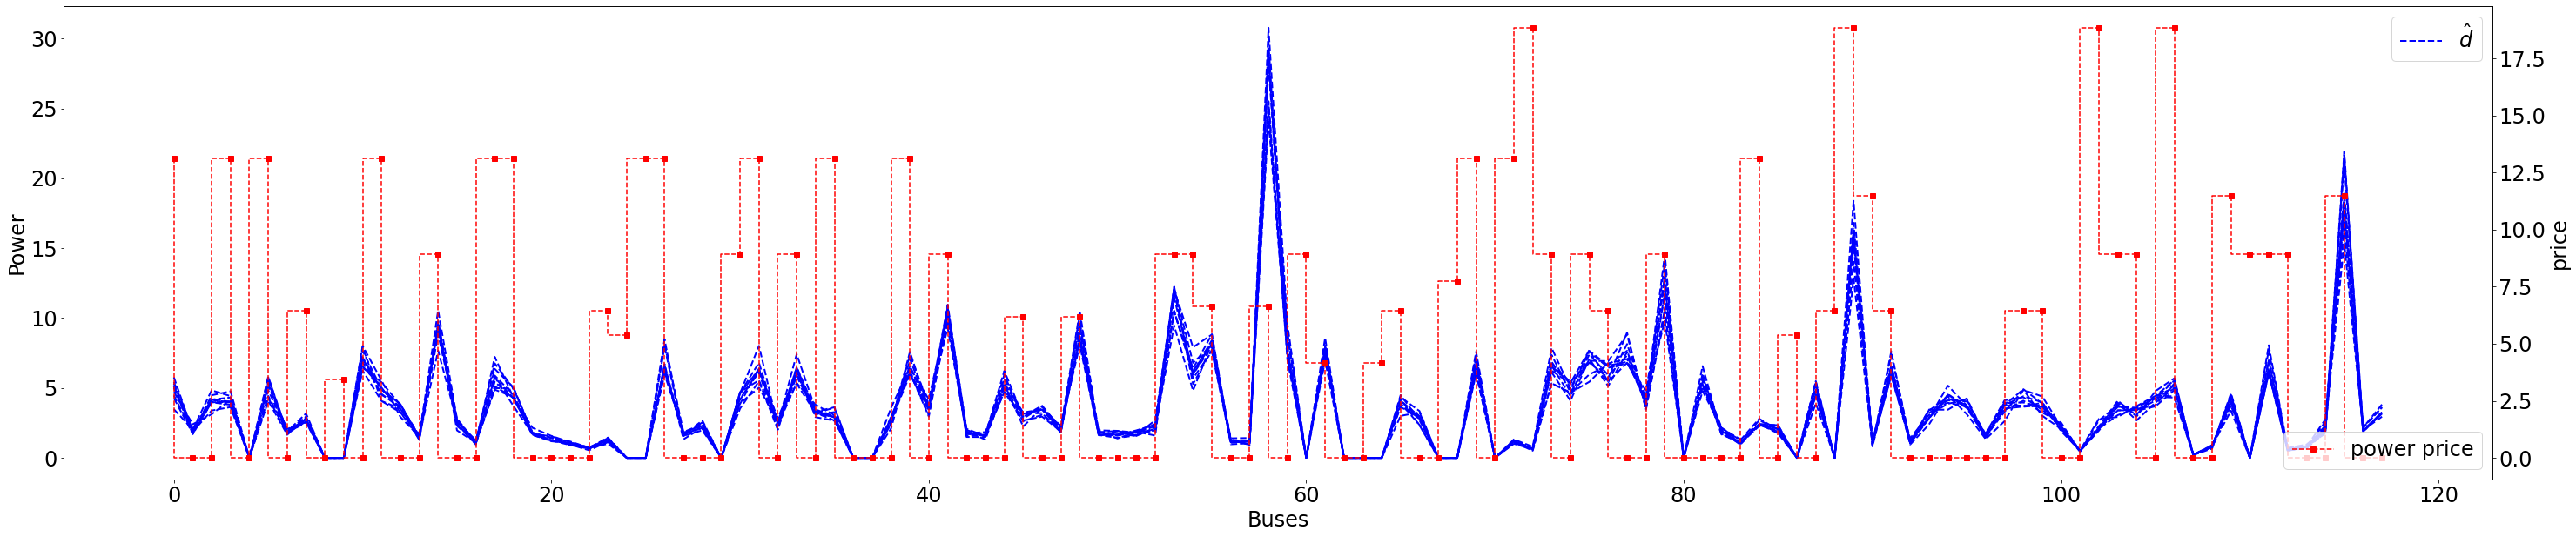

In [ ]:
numX = numBuses
numZ = 10

_, ax0 = plt.subplots(figsize=(50, 10))
for i in range(numZ):
    if i == 0:
        ax0.plot(range(numX), nnPreTrainData[i, :], 'b--', markersize=10, linewidth=2,
                    label=r'$\hat{d}$')
    else:
        ax0.plot(range(numX), nnPreTrainData[i, :], 'b--', markersize=10, linewidth=2)
        
ax0.legend(fontsize=24, loc='best')
ax0.tick_params(axis='x', labelsize=24)
ax0.tick_params(axis='y', labelsize=24)
ax0.set_xlabel('Buses', fontsize=24)
ax0.set_ylabel('Power', fontsize=24)

ax1 = ax0.twinx()
ax1.step(range(numX), genCost_extension, 'r--s', label='power price')
ax1.legend(fontsize=24, loc='lower right')
ax1.tick_params(axis='y', labelsize=24)
ax1.set_ylabel('price', fontsize=24, rotation=90)

plt.show()

# helper.py

In [ ]:
def genToBus(x, expected_dim):
    if x.shape[1] < expected_dim[1]:
        full_x = np.zeros((expected_dim[0], expected_dim[1]))
        full_x[:, regGenSet] = x

        return full_x


## display fs solns

In [ ]:
def display_fsSolns(inputDemands, full_p0, full_rp, full_rd):
    numX = numBuses
    numZ = inputDemands.shape[0]

    # expected_dim = [numZ, numX]

    _, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(50, 20), dpi=400)

    for t in range(numZ):

        # p0 = np.array(fsSolns['p0'][t])
        # rp = np.array(fsSolns['rp'][t])
        # rd = np.array(fsSolns['rd'][t])

        # full_p0 = genToBus(p0, expected_dim)
        # full_rp = genToBus(rp, expected_dim)
        # full_rd = genToBus(rd, expected_dim)

        if t == 0:
            ax0.plot(range(numX), inputDemands[t, :], 'b--', markersize=10, linewidth=2, label=r'$\hat{d}$')
            ax0.plot(range(numX), full_p0, 'r-x', markersize=10, linewidth=2, label=r'$p_0$')
            # ax0.plot(range(numX), rp_extension, 'y-D', markersize=10, linewidth=4, label=r'$\bar{r}$')
            # ax0.plot(range(numX), -full_rd, 'k-^', markersize=10, linewidth=4, label=r'\underline{r}')
            ax0.fill_between(range(numX), y1=-full_rd, y2=full_rp, facecolor='y', alpha=0.5, label='reserve')
            ax0.step(range(numX), busMaxP, 'k-o', markersize=10, linewidth=2, label=r'$P_{max}$')

        else:
            ax0.plot(range(numX), inputDemands[t, :], 'b--', markersize=10, linewidth=2)
            ax0.plot(range(numX), full_p0, 'r-x', markersize=10, linewidth=2)
            # ax0.plot(range(numX), rp_extension, 'y-D', markersize=10, linewidth=4)
            # ax0.plot(range(numX), -full_rd, 'k-^', markersize=10, linewidth=4)
            ax0.fill_between(range(numX), y1=-full_rd, y2=full_rp, facecolor='y', alpha=0.5)

    ax0.legend(fontsize=24, loc='best')
    ax0.tick_params(axis='x', labelsize=24)
    ax0.tick_params(axis='y', labelsize=24)
    ax0.set_xlabel('Buses', fontsize=24)
    ax0.set_ylabel('Power', fontsize=24)
    ax0.set_ylim([0., 350.])

    # ax1 = ax0.twinx()
    # ax1.plot(range(numX), genCost_extension, 'c--s', markersize=5, linewidth=2, label='power price')
    ax1.step(range(numX), busCost, 'c-s', markersize=5, linewidth=2, label='power price', where='pre')
    ax1.legend(fontsize=24, loc='lower right')
    ax1.tick_params(axis='x', labelsize=24)
    ax1.tick_params(axis='y', labelsize=24)
    ax1.set_xlabel('Buses', fontsize=24)
    ax1.set_ylabel('price', fontsize=24, rotation=90)
    plt.show()


## display train loss

In [ ]:
def display_train_loss(train_hist, epoch, fig_name, yplot):
    Xrange = range(len(train_hist['train_losses']))

    fig = plt.figure(figsize=(10, 10))
    plt.ticklabel_format(style='plain', scilimits=(-3, 3), useOffset=False)
    ax = fig.add_subplot(1, 1, 1)
    if yplot == 'log10':
        ax.plot(Xrange, np.log10(train_hist['train_losses']), label='train loss')
        ax.set_ylabel('log10(train loss)', fontsize=20)

    elif yplot == 'plain':
        ax.plot(Xrange, train_hist['train_losses'], label='train loss')
        ax.set_ylabel('train loss', fontsize=20)

    ax.set_xlabel('training epochs', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(savedTrainPath + fig_name)
    plt.show()

# nnModelFns.py

In [ ]:
# FUNCTIONS AND PARAMS TO BE USED FOR LEARNING METHOD
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import relu

# from mod118bus import *
# from chebyCenter import *


# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seed for reproducibility
random.seed(2234)
np.random.seed(4467)
torch.manual_seed(8899)

# define useful sets and matrices
nonSlackSet = list(range(1, slackBusNo)) + list(range(slackBusNo + 1, numBuses + 1))
nonSlackSet2 = [x - 1 for x in nonSlackSet]

oneN = np.ones((numRegGen, 1))
zeroN = np.zeros((numRegGen, 1))
nullN = np.zeros((numRegGen, numRegGen))
eyeN = np.eye(numRegGen)

# deviationsScalingFactor = 1 / 5

# *====== DEFINE TENSORS =======
modF = np.take(F, nonSlackSet2, axis=-1)
modB = np.take(B, nonSlackSet2, axis=-1)

# modB_over_nonslack = np.take(modB, nonSlackSet2, axis=0)
# modBInverse = np.linalg.inv(modB_over_nonslack)
modB_over_gen = np.take(modB, regGenSet, axis=0)
# b_slack = modB[slackBusNo - 1:slackBusNo, :]

# data to be used in training process
B_ts = torch.tensor(B).float().to(device)
modB_ts = torch.tensor(modB).float().to(device)
modB_over_gen_ts = torch.tensor(modB_over_gen).float().to(device)
# modBInverse_ts = torch.tensor(modBInverse).float().to(device)
# b_slack_ts = torch.tensor(b_slack).float().to(device)

regGenCost_ts = torch.tensor(regGenCost).float().to(device).reshape(-1, 1)
regGenPosResCost_ts = torch.tensor(regGenPosResCost).float().to(device).reshape(-1, 1)
regGenNegResCost_ts = torch.tensor(regGenNegResCost).float().to(device).reshape(-1, 1)
busPosResCost_ts = torch.tensor(busPosResCost).float().to(device).reshape(-1, 1)
busNegResCost_ts = torch.tensor(busNegResCost).float().to(device).reshape(-1, 1)
maxP_ts = torch.tensor(regGenMaxP).float().reshape(1, -1)
minP_ts = torch.tensor(regGenMinP).float().reshape(1, -1)
regGenMaxP_ts = torch.tensor(regGenMaxP).float().to(device)
regGenMinP_ts = torch.tensor(regGenMinP).float().to(device)

demandCorrMat = np.load(inputDemandPath + 'demandCorrMat.npy')
demandCorrMat_ts = torch.tensor(demandCorrMat).float().to(device)

# *====== GAUGE MAPPING FOR FIRST STAGE SOLUTIONS =======

fsG = np.block([
    [-oneN.T],
    [eyeN],
    [-eyeN]
])

# # mod_regGenMinP = regGenMinP - 0.01
# nominal_p = np.ones((numRegGen, 1)) * maxSumPredMean / numRegGen

# mod_zeroN = zeroN + 0.01

fs_h = np.block([
    [-maxSumPredMean],
    [regGenMaxP.reshape(-1, 1)],
    [-regGenMinP.reshape(-1, 1)]
])

# if fsConstrainID == 'addFSBalance':
#     # modify G, h if add balance constraint for first stage
#     fsG = np.block([
#         [-oneN.T, zeroN.T, zeroN.T],
#         [eyeN, eyeN, nullN],
#         [-eyeN, nullN, eyeN],
#         [nullN, -eyeN, nullN],
#         [nullN, nullN, -eyeN],
#         [eyeN, nullN, nullN],
#         [-eyeN, nullN, nullN]
#     ])

#     fs_h = np.block([
#         [-maxSumPredMean],  # this will change over batches
#         [regGenMaxP.reshape(-1, 1)],
#         [-regGenMinP.reshape(-1, 1)],
#         [zeroN],
#         [zeroN],
#         [regGenMaxP.reshape(-1, 1)],
#         [-regGenMinP.reshape(-1, 1)]
#     ]) / inputScalingFactor

# an interior point can be found by solving "Chebyshev center" problem
# chebyCenter, radius, solver_status = getChebyCenter(fsG, fs_h)
# print('radius is %f.3' % radius)

# shift polytope using this interior point
# fs_h2 = fs_h - fsG @ chebyCenter

# check if zero is a strict interior point of the shifted polytope
# assert np.max(-fs_h2) < 0.0, "zero is not a strict interior point of polytope defined by (fsG, fs_h2)!"

# # drawbacks of chebyshev center:
# # sensitive to the boundary
# # x and [r_up, r_down] have quite different range, but chebyshev center is to the center in all dimensions
# # thus we may have a scaling issue
nominal_p = np.ones((numRegGen, 1)) * maxSumPredMean / numRegGen
inter_p0 = nominal_p * 1.05
# # inter_rp = nominal_p * 0.05
# # inter_rd = nominal_p * 0.05
# inter_rp = np.zeros_like(inter_p0)
# inter_rd = np.zeros_like(inter_p0)
# # inter_rp = np.ones((numRegGen, 1)) * 0.01
# # inter_rd = np.ones((numRegGen, 1)) * 0.01
inter_fsSoln = inter_p0

# if fsConstrainID == 'addFSBalance':
#     # # if we ask for sum(p0)>=sum(predMean)
#     predMeanFactor = 1.2
#     margin = 0.95
#     inter_p0 = 1 / numRegGen * predMeanFactor * maxSumPredMean * np.ones((numRegGen, 1))
#     inter_rp = (1 - margin) * inter_p0
#     inter_rd = (1 - margin) * inter_p0
#     inter_fsSoln = np.concatenate([inter_p0, inter_rp, inter_rd], axis=0) / inputScalingFactor

# check if this is a strict interior point
assert np.max(fsG @ inter_fsSoln - fs_h) < 0.0, "inter_fsSoln is not a strict interior point!"

# shift polytope using this interior point
fs_h3 = fs_h - fsG @ inter_fsSoln

# check if zero is a strict interior point of the shifted polytope
assert np.max(-fs_h3) < 0.0, "zero is not a strict interior point of polytope defined by (fsG, fs_h3)!"

# # tensors
fsG_ts = torch.tensor(fsG).float().to(device)
fs_h_ts = torch.tensor(fs_h).float().to(device)
# # fs_h2_ts = torch.tensor(fs_h2).float().to(device)
# fs_h3_ts = torch.tensor(fs_h3).float().to(device)
# # chebyCenter_ts = torch.tensor(chebyCenter).float().to(device)
inter_fsSoln_ts = torch.tensor(inter_fsSoln).float().to(device)

# *====== GAUGE MAPPING FOR RECOURSE STAGE SOLUTIONS =======

rcsG = np.block([
    [modF],
    [-modF],
    [np.eye(numBuses - 1)],
    [-np.eye(numBuses - 1)]
])

rcs_h = np.block([
    [flow_max.reshape(-1, 1)],
    [flow_max.reshape(-1, 1)],
    [theta_max * np.ones((numBuses - 1, 1))],
    [theta_max * np.ones((numBuses - 1, 1))]
])

rcsG_ts = torch.tensor(rcsG).float().to(device)
rcs_h_ts = torch.tensor(rcs_h).float().to(device)


# *====== DEFINE USEFUL FUNCTIONS =======
def gaugeFunction(V, G, H):
    """
    V can be batched, each column represents a different data point.
    for example, if V is composed of K r-dimensional data points, then shape(V) = (r, K)
    Note that the second dimension is the batch size.
    Similarly, H can be batched, each column corresponds to a different data point.
    Sometimes, H_j can depend on data point V_j

    The feasibility set, i.e., polytope, is defined by {v: G@v <= H_j} = {v: g_i^T@v <= H_j,i, i = 1, ..., q}
    shape(G) = (q, r), shape(H_j) = (q, 1), shape(H) = (q, K)
    Note that the polytope must contain the origin in its interior in order to do gauge mapping.

    Return the gauge which will be used in gaugeMapping function.

    """

    # torch.div() for element-wide division
    return torch.max(torch.div(G @ V, H), dim=0).values  # shape(output) = (1, K)


def gaugeMapping(Z, G, H):
    """
    For any Z \belongsto B_infinity, the gauge map from B_infinity to the polytope
    defined by {v: G@v <= H_j} is given by the following code.
    """

    gamma_dest = gaugeFunction(Z, G, H)  # shape = (1, K)
    gamma_start = torch.linalg.norm(Z, ord=np.inf, dim=0)  # shape(1, K)

    scaling_mat = torch.diag(gamma_start / gamma_dest)  # shape = (K, K)

    return Z @ scaling_mat  # shape = (r, K); this is the new point which lies in the feasibility set


def init_weights(model):
    if isinstance(model, nn.Linear):
        n = model.in_features
        y = 1.0 / np.sqrt(n)
        model.weight.data.uniform_(-y, y)
        model.bias.data.fill_(0.001)
        # m.bias.data.uniform_(0, y)


class CustomPowerDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples

    def __len__(self):
        return self.samples.shape[0]

    def __getitem__(self, idx):
        return self.samples[idx, :]


def estimate_fsCost(p0, rp, rd, gamma_gen):
    bs = p0.shape[0]

    c_gen = torch.mean(p0 @ regGenCost_ts)
    c_res = torch.mean(rp @ regGenPosResCost_ts +
                      rd @ regGenNegResCost_ts)
    
    ub = maxP_ts.repeat(bs, 1).to(device)
    # print('ub:', ub.shape)
    genMaxBoundViol = relu((p0 + rp) - ub)

    lb = minP_ts.repeat(bs, 1).to(device)
    # print('lb:', lb.shape)
    genMinBoundViol = relu(lb - (p0 - rd))

    fs_pen_cost = gamma_gen * torch.mean(torch.sum((genMaxBoundViol ** 2 +
                                                 genMinBoundViol ** 2), dim=1) )
    
    
    return c_gen, c_res, fs_pen_cost


def estimateQValue(full_y, full_p0, full_rp, full_rd, gamma_res, gamma_gen):
    # actual batch size
    bs = full_y.shape[0]
    # maxP_extension = maxP_ts.repeat(bs, 1).to(device)
    # minP_extension = minP_ts.repeat(bs, 1).to(device)

    fullMaxP = torch.zeros_like(full_y)
    fullMaxP[:, regGenSet] = maxP_ts.repeat(bs, 1).to(device)
    genMaxBoundViol = relu(full_p0 + full_y - fullMaxP)

    fullMinP = torch.zeros_like(full_y)
    fullMinP[:, regGenSet] = minP_ts.repeat(bs, 1).to(device)
    genMinBoundViol = relu(fullMinP - (full_p0 + full_y))

    posResViol = relu(full_y - full_rp)
    negResViol = relu(-full_rd - full_y)
    # genMaxBoundViol = relu(p0 + y - maxP_extension)
    # genMinBoundViol = relu(minP_extension - (p0 + y))

    resViolPenalty = gamma_res * (posResViol @ busPosResCost_ts +
                                  negResViol @ busNegResCost_ts)
    # genBoundViolPenalty = gamma_gen * torch.sum((genMaxBoundViol ** 2 +
    #                                              genMinBoundViol ** 2), dim=1) + \
    #                         gamma_gen * torch.sum((posResViol[:, nonRegGenSet] ** 2 +
    #                                              negResViol[:, nonRegGenSet] ** 2), dim=1)
    genBoundViolPenalty = gamma_gen * torch.sum((genMaxBoundViol ** 2 +
                                                 genMinBoundViol ** 2), dim=1) 


    # print('resViolPenalty:', torch.mean(resViolPenalty).item())
    # print('genBoundViolPenalty:', torch.mean(genBoundViolPenalty).item())

    return torch.mean(resViolPenalty) + torch.mean(genBoundViolPenalty)

def estimateRcsCost(full_y, full_p0, full_rp, full_rd, gamma_res):
    # actual batch size
    bs = full_y.shape[0]

    fullMaxP = torch.zeros_like(full_y)
    fullMaxP[:, regGenSet] = maxP_ts.repeat(bs, 1).to(device)
    genMaxBoundViol = relu(full_p0 + full_y - fullMaxP)

    fullMinP = torch.zeros_like(full_y)
    fullMinP[:, regGenSet] = minP_ts.repeat(bs, 1).to(device)
    genMinBoundViol = relu(fullMinP - (full_p0 + full_y))

    posResViol = relu(full_y - full_rp)
    negResViol = relu(-full_rd - full_y)

    resViolPenalty = gamma_res * (posResViol @ busPosResCost_ts +
                                  negResViol @ busNegResCost_ts)

    return torch.mean(resViolPenalty)

# cnnModel.py

In [ ]:
# DEFINE NEURAL NETWORK ARCHITECTURES
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.functional import relu

## FSNet

In [ ]:
class FSNet(torch.nn.Module):
    def __init__(self, *params):
        super(FSNet, self).__init__()
        super().__init__()

        # conv params are arranged in n_channels, out_channels, kernel_size,
        #                       stride, padding
        # conv1 = [1, 6, 3, 1, 1] -> L' = 118
        # conv2 = [6, 16, 4, 2, 0] -> L' = 58
        # fc params are arranged in in_features, out_features
        # fc1 = [int(16 * 58), 512]
        # fc2 = [512, 256]
        # fc3 = [256, 54] -> x_pred
        # fc4 = [int(16 * 58)+54, 512]
        # fc5 = [512, 256]
        # fc6 = [256, int(54*2)] -> [rp_pred, rd_pred]
        conv1 = params[0]
        conv2 = params[1]
        fc1 = params[2]
        fc2 = params[3]
        fc3 = params[4]

        fc4 = params[5]
        fc5 = params[6]
        fc6 = params[7]


        self.convLayers = nn.Sequential(
            nn.Conv1d(in_channels=conv1[0], out_channels=conv1[1], kernel_size=conv1[2],
                      stride=conv1[3], padding=conv1[4]),
            nn.BatchNorm1d(conv1[1]),
            torch.nn.ReLU(),

            nn.Conv1d(in_channels=conv2[0], out_channels=conv2[1], kernel_size=conv2[2],
                      stride=conv2[3], padding=conv2[4]),
            nn.BatchNorm1d(conv2[1]),
            torch.nn.ReLU(),
        )

        self.p0Layers = nn.Sequential(
            torch.nn.Linear(fc1[0], fc1[1]),
            torch.nn.ReLU(),
            # torch.nn.Dropout(0.25),

            torch.nn.Linear(fc2[0], fc2[1]),
            torch.nn.ReLU(),
            # torch.nn.Dropout(0.25),

            torch.nn.Linear(fc3[0], fc3[1]),
        )

        self.resLayers = nn.Sequential(
                torch.nn.Linear(fc4[0], fc4[1]),
                torch.nn.ReLU(),
                # torch.nn.Dropout(0.25),

                torch.nn.Linear(fc5[0], fc5[1]),
                torch.nn.ReLU(),
                torch.nn.Dropout(0.25),

                torch.nn.Linear(fc6[0], fc6[1]),
            )

    def forward(self, input):
        z = self.convLayers(input.unsqueeze(1))
        z = torch.flatten(z, start_dim=1, end_dim=-1)  # flatten all dimensions except batch
        x = torch.tanh(self.p0Layers(z))
        # print('x:', x.shape)

        bs = input.shape[0]
        batchMaxP_ts = maxP_ts.repeat(bs, 1).to(device)
        batchMinP_ts = minP_ts.repeat(bs, 1).to(device)

        # gauge mapping: map B_infinity to shifted polytope
        batch_SumDemand = input.sum(dim=1).reshape(1, -1)
        batch_SumDemand *= inputScalingFactor
        batch_fsH = torch.cat([-batch_SumDemand, fs_h_ts[1:, :].repeat(1, bs)], dim=0)
        shifted_fsH = batch_fsH - fsG_ts @ inter_fsSoln_ts

        # gauge mapping: map B_infinity to shifted polytope
        p0_pred = gaugeMapping(x.T, fsG_ts, shifted_fsH) + inter_fsSoln_ts

        p0_pred3 = torch.zeros_like(input)
        p0_pred3[:, regGenSet] = p0_pred.T

        # predict reserve
        res_input = torch.cat([input, x], dim=-1)
        # res_input = torch.cat([input, p0_pred3/inputScalingFactor], dim=1)
        # res_input = input

        res_pred = torch.tanh(self.resLayers(res_input))

        rp_pred = res_pred[:, :numRegGen]
        rd_pred = res_pred[:, numRegGen:]

        # scale reserve to appropriate range
        # rp_pred2 = (rp_pred + 1.) / 2. * (batchMaxP_ts - p0_pred2)
        # rd_pred2 = (rd_pred + 1.) / 2. * (p0_pred2 - batchMinP_ts)

        rp_pred2 = (rp_pred + 1.) / 2. * (batchMaxP_ts - batchMinP_ts)
        rd_pred2 = (rd_pred + 1.) / 2. * (batchMaxP_ts - batchMinP_ts)

        rp_pred3 = torch.zeros_like(input)
        rd_pred3 = torch.zeros_like(input)
        rp_pred3[:, regGenSet] = rp_pred2
        rd_pred3[:, regGenSet] = rd_pred2

        # fs_pred = torch.cat([p0_pred3, rp_pred3, rd_pred3], dim=1)

        return p0_pred3, rp_pred3, rd_pred3, shifted_fsH


## RCSNet

In [ ]:
class RCSNet(torch.nn.Module):
    def __init__(self, *params):
        super(RCSNet, self).__init__()
        super().__init__()

        # conv params are arranged in n_channels, out_channels, kernel_size,
        #                       stride, padding
        # conv1 = [1, 8, 3, 1, 1]
        # conv2 = [8, 16, 4, 2, 0]
        # fc params are arranged in in_features, out_features
        # fc1 = [int(16 * 28), 256]
        # fc2 = [256, 128]
        # fc3 = [128, 38]
        conv1 = params[0]
        conv2 = params[1]
        conv3 = params[2]
        fc1 = params[3]
        fc2 = params[4]

        self.convLayers = nn.Sequential(
            nn.Conv1d(in_channels=conv1[0], out_channels=conv1[1], kernel_size=conv1[2],
                      stride=conv1[3], padding=conv1[4]),
            nn.BatchNorm1d(conv1[1]),
            torch.nn.ReLU(),

            nn.Conv1d(in_channels=conv2[0], out_channels=conv2[1], kernel_size=conv2[2],
                      stride=conv2[3], padding=conv2[4]),
            nn.BatchNorm1d(conv2[1]),
            torch.nn.ReLU(),

            nn.Conv1d(in_channels=conv3[0], out_channels=conv3[1], kernel_size=conv3[2],
                      stride=conv3[3], padding=conv3[4]),
            nn.BatchNorm1d(conv3[1]),
            torch.nn.ReLU(),
        )

        self.fcLayers = nn.Sequential(
            torch.nn.Linear(fc1[0], fc1[1]),
            torch.nn.ReLU(),
            # torch.nn.Dropout(0.25),

            torch.nn.Linear(fc2[0], fc2[1]),
            torch.nn.ReLU(),
            # torch.nn.Dropout(0.25),

            torch.nn.Linear(fc3[0], fc3[1]),
        )

    def forward(self, input):
        z = input.unsqueeze(1)
        z = self.convLayers(z)
        z = torch.flatten(z, start_dim=1, end_dim=-1)  # flatten all dimensions except batch
        z = torch.tanh(self.fcLayers(z))

        # gauge mapping: map B_infinity to shifted polytope 
        bs = input.shape[0]
        batch_rcsH = rcs_h_ts.repeat(1, bs)

        theta_pred = gaugeMapping(z.T, rcsG_ts, batch_rcsH)

        # get y_pred from theta_pred
        net_d_omega = input[:, :numBuses]
        y_pred = modB_ts @ theta_pred + net_d_omega.T

        return theta_pred.T, y_pred.T

# pretrain_fs.py

In [ ]:
# GENERATE LABELED DATA AND THEN PRETRAIN THE RECOURSE NETWORK
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn.functional import pad, relu


In [ ]:
def preTrainFsNet(dataSet, initModel, lr, numEpochs, miniBatchSize, yPlot='log10', saveModels=True):
    # configure optimizer
    model = initModel
    adamOptimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

    # define loss criterion
    loss_criterion = nn.MSELoss()

    # format input data set
    train_loader = DataLoader(dataSet, batch_size=miniBatchSize, shuffle=True)

    # # gauge mapping
    # batch_fsH = fs_h_ts.repeat(1, miniBatchSize)
    # # print('batch_fsH:', batch_fsH.shape)
    # batchMaxP_ts = maxP_ts.repeat(miniBatchSize, 1).to(device)
    # batchMinP_ts = minP_ts.repeat(miniBatchSize, 1).to(device)

    # dictionary to store training process
    train_hist = {'train_losses': [], 'time_per_epoch': [], 'total_time': []}
    # total number of iterations
    num_iter = 0

    # *========== TRAINING START ===========
    print("Training starts!")
    start_time = time.time()

    for epoch in range(numEpochs):

        train_losses_per_epoch = []

        epoch_start_time = time.time()

        for miniBatch in train_loader:

            # get a batch of data
            inputData = miniBatch.float().to(device)
            # # actual batch size
            # bs = inputData.shape[0]

            d_predMean = inputData[:, :numBuses]
            target_data = inputData[:, numBuses:]
            # full_p0_data = target_data[:, :numBuses]
            # full_rp_data = target_data[:, numBuses:numBuses+numBuses]
            # full_rd_data = target_data[:, numBuses+numBuses:]
            
            # p0_data = full_p0_data[:, regGenSet]
            # rp_data = full_rp_data[:, regGenSet]
            # rd_data = full_rd_data[:, regGenSet]
            # target = torch.cat([p0_data, rp_data, rd_data], dim=-1)

            # zero grad
            model.zero_grad()

            # make predictions
            p0_pred, rp_pred, rd_pred, shifted_fsH  = model(d_predMean)

            # check if zero is a strict interior point of the shifted polytope
            assert torch.max(-shifted_fsH) < 0.0, "zero is not a strict interior point of polytope defined by (fsG, fs_h3)!"


            # print('p0_pred sum:', torch.sum(p0_pred, dim=1)/inputScalingFactor)
            # print('d_predMean sum:', torch.sum(d_predMean, dim=1).detach())

            # print('net_output:', net_output.shape)

            # p0_pred = net_output[:, :numRegGen]
            # rp_pred = net_output[:, numRegGen:numRegGen+numRegGen]
            # rd_pred = net_output[:, numRegGen+numRegGen:]

            # p0_pred2 = torch.zeros_like(p0_pred).to(device)
            # rp_pred2 = torch.zeros_like(rp_pred).to(device)
            # rd_pred2 = torch.zeros_like(rd_pred).to(device)

            # for i in range(numRegGen):

            #     p0_pred2[:, i] = (p0_pred[:, i] + 1.) / 2. * (regGenMaxP_ts[i] - regGenMinP_ts[i]) + regGenMinP_ts[i]
            #     rp_pred2[:, i] = (rp_pred[:, i] + 1.) / 2. * (regGenMaxP_ts[i] - p0_pred2[:, i])
            #     rd_pred2[:, i] = (rd_pred[:, i] + 1.) / 2. * (p0_pred2[:, i] - regGenMinP_ts[i])

            # p0_pred2 = (p0_pred + 1.) / 2. * (batchMaxP_ts - batchMinP_ts) + batchMinP_ts
            # rp_pred2 = (rp_pred + 1.) / 2. * (batchMaxP_ts - p0_pred2)
            # rd_pred2 = (rd_pred + 1.) / 2. * (p0_pred2 - batchMinP_ts)

            predictions = torch.cat([p0_pred, rp_pred, rd_pred], dim=1)

            # print(torch.min(net_output))
            # print(torch.max(net_output))

            # if fsConstrainID == 'addFSBalance':
            #     # use gauge mapping to map B_infinity to polytope defined by fsG, batch_fsH
            #     batch_SumDemand = d_predMean.sum(dim=1)
            #     batch_SumDemand = batch_SumDemand.reshape(1, -1)
            #     batch_fsH = torch.cat([-batch_SumDemand, fs_h_ts[1:, :].repeat(1, bs)], dim=0)
            #     # check to see if our fixed interior point is will effective
            #     assert torch.max(
            #         fsG_ts @ inter_fsSoln_ts - batch_fsH) < 0.0, "inter_rcsSoln is not a strict interior point!"

            #     # if effective
            #     # use this fixed interior point to shift the polytope defined by fsG, batch_fsH
            #     batch_fsH = batch_fsH - fsG_ts @ inter_fsSoln_ts

            # # use interior point to shift the polytope defined by fsG, batch_fsH
            # shifted_batch_fsH = batch_fsH - fsG_ts @ inter_fsSoln_ts

            # # gauge mapping: map B_infinity to shifted polytope
            # x_pred = gaugeMapping(net_output.T, fsG_ts, shifted_batch_fsH) + inter_fsSoln_ts

            # x_pred = relu(x_pred)
            
            # calculate loss function
            train_loss_per_batch = loss_criterion(predictions/inputScalingFactor, target_data)
            # train_loss_per_batch = loss_criterion(x_pred.T/inputScalingFactor, target)

            # backpropagation
            # train_loss_per_batch.backward(retain_graph=True)
            train_loss_per_batch.backward()

            # update model
            adamOptimizer.step()

            train_losses_per_epoch.append(train_loss_per_batch.item())

            # *========== PRINT TRAINING PROGRESS ===========
            if num_iter == 0:
                print('\nTraining progress......')

            num_iter += 1
            if num_iter % 1000 == 0:
                print('Have done [%d epochs/%d iterations], avg loss is %.5f' % ((epoch + 1),
                                                                                 (num_iter + 1),
                                                                                 torch.FloatTensor(
                                                                                     train_losses_per_epoch).mean().item()))
        # end of epoch
        epoch_end_time = time.time()
        time_per_epoch = epoch_end_time - epoch_start_time

        loss_value_per_epoch = torch.mean(torch.FloatTensor(train_losses_per_epoch)).item()

        train_hist['train_losses'].append(round(loss_value_per_epoch, 4))
        train_hist['time_per_epoch'].append(time_per_epoch / 60)

        # *========== SAVE MODEL ===========
        if epoch == numEpochs - 1 or epoch % 400 == 0:
            if saveModels:
                # save model
                torch.save(model.state_dict(), savedPreTrainPath + 'pretrain_fs_net.pt')
            # save and display train loss if needed
            json.dump(train_hist['train_losses'], open(savedPreTrainPath + 'fs_net_pretrain_loss', 'w'))
            display_train_loss(train_hist, epoch, 'pretrain_fs_net_loss.png', yPlot)

    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Total %d epochs take time: %.2f minutes" %
          (numEpochs, total_time / 60))
    print("Training finishes!")

    return model

## train function

Training starts!

Training progress......


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


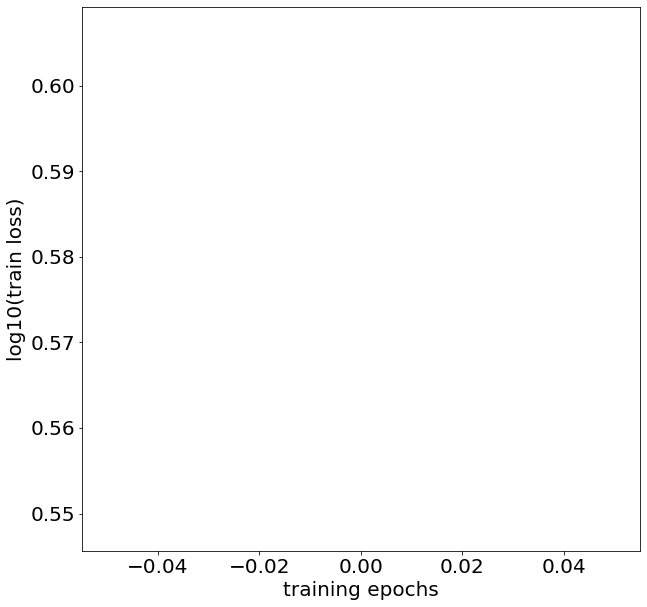

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


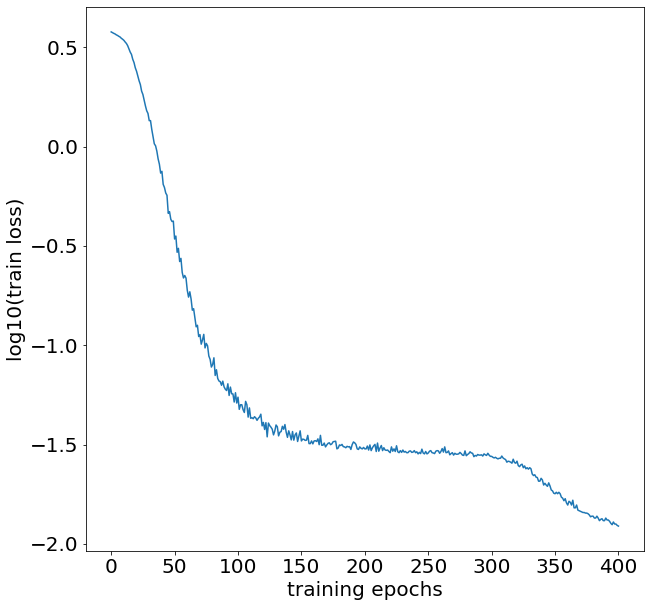

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


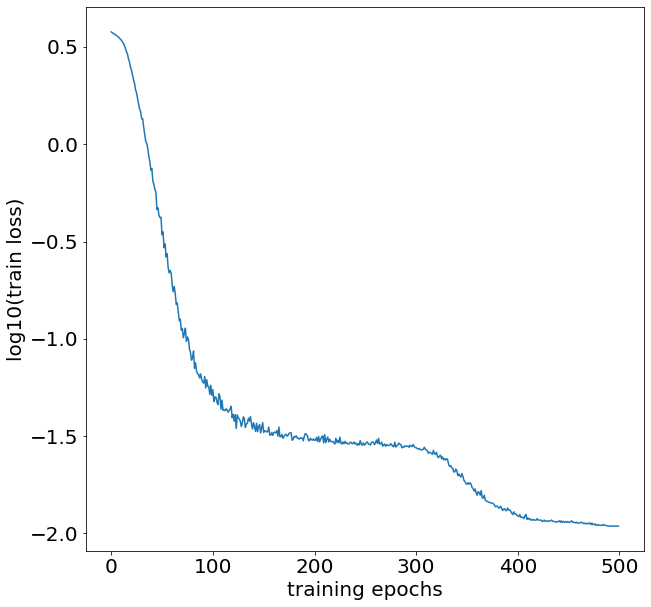

Total 500 epochs take time: 0.19 minutes
Training finishes!


FSNet(
  (convLayers): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 16, kernel_size=(4,), stride=(2,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (p0Layers): Sequential(
    (0): Linear(in_features=928, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=54, bias=True)
  )
  (resLayers): Sequential(
    (0): Linear(in_features=172, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=256, out_features=108, bias=True)
  )
)

In [ ]:
# if fsNNModelID == 'passthroughCNN':
#     conv1 = [1, 6, 3, 1, 1]
#     conv2 = [6, 16, 4, 2, 0]
#     fc1 = [int(16 * 58), 512]
#     fc2 = [512, 256]
#     fc3 = [256, 54]
#     if directLinkToInput:
#         fc4 = [118+54, 512]
#     else:
#         fc4 = [int(16 * 58)+54, 512]
#     fc5 = [512, 256]
#     fc6 = [256, 54+54]
#     fs_net = FSNetPassThrough(conv1, conv2, fc1, fc2, fc3, fc4, fc5, fc6)
#     fs_net.to(device)


conv1 = [1, 8, 3, 1, 1]
conv2 = [8, 16, 4, 2, 0]
fc1 = [int(16 * 58), 512]
fc2 = [512, 256]
fc3 = [256, 54]

fc4 = [118+54, 512]
# fc4 = [118+118, 512]
# fc4 = [118, 512]
fc5 = [512, 256]
fc6 = [256, 54 + 54]

fs_net = FSNet(conv1, conv2, fc1, fc2, fc3, fc4, fc5, fc6)
fs_net.to(device)


# conv1 = [1, 6, 3, 1, 1]
# conv2 = [6, 16, 4, 2, 0]
# fc1 = [int(16 * 58), 512]
# fc2 = [512, 256]
# fc3 = [256, int(54*3)]
# fs_net = FSNet(conv1, conv2, fc1, fc2, fc3)
# fs_net.to(device)

# remember to scale the dataset by inputScalingFactor
X_preTrain = np.load(inputDemandPath + 'X_preTrain.npy')/inputScalingFactor
fsPreTrainData = CustomPowerDataset(X_preTrain)


preTrainFsNet(fsPreTrainData, fs_net, lr=1e-4, numEpochs=500, miniBatchSize=10,
              yPlot='log10', saveModels=True)

## use pretrained

In [ ]:
# *========= MAKE PREDICTIONS ==========

def predict(model, input_data, target=None):
    net_input = torch.tensor(input_data/inputScalingFactor).float().to(device)

    # define actual test size
    numTest = input_data.shape[0]

    # *========== LOAD TRAINED NEURAL NETWORK ==========
    model.load_state_dict(torch.load(savedPreTrainPath + 'pretrain_fs_net.pt'))
    # turn off drop-out layers
    model.eval()

    batchMaxP_ts = maxP_ts.repeat(numTest, 1).to(device)
    batchMinP_ts = minP_ts.repeat(numTest, 1).to(device)

    with torch.no_grad():
        p0_pred, rp_pred, rd_pred, shifted_fsH = fs_net(net_input)

        # check if zero is a strict interior point of the shifted polytope
        assert torch.max(-shifted_fsH) < 0.0, "zero is not a strict interior point of polytope defined by (fsG, fs_h3)!"


        # p0_pred = fs_output[:, :numRegGen]
        # rp_pred = fs_output[:, numRegGen:numRegGen+numRegGen]
        # rd_pred = fs_output[:, numRegGen+numRegGen:]

        # p0_pred2 = torch.zeros_like(p0_pred).to(device)
        # rp_pred2 = torch.zeros_like(rp_pred).to(device)
        # rd_pred2 = torch.zeros_like(rd_pred).to(device)

        # # for i in range(numRegGen):

        # #     p0_pred2[:, i] = (p0_pred[:, i] + 1.) / 2. * (regGenMaxP_ts[i] - regGenMinP_ts[i]) + regGenMinP_ts[i]
        # #     rp_pred2[:, i] = (rp_pred[:, i] + 1.) / 2. * (regGenMaxP_ts[i] - p0_pred2[:, i])
        # #     rd_pred2[:, i] = (rd_pred[:, i] + 1.) / 2. * (p0_pred2[:, i] - regGenMinP_ts[i])

        # p0_pred2 = (p0_pred + 1.) / 2. * (batchMaxP_ts - batchMinP_ts) + batchMinP_ts
        # rp_pred2 = (rp_pred + 1.) / 2. * (batchMaxP_ts - p0_pred2)
        # rd_pred2 = (rd_pred + 1.) / 2. * (p0_pred2 - batchMinP_ts)

        # predictions = torch.cat([p0_pred2, rp_pred2, rd_pred2], dim=1)

        # batch_fsH = fs_h_ts.repeat(1, numTest)
        # # use interior point to shift the polytope defined by fsG, batch_fsH
        # shifted_batch_fsH = batch_fsH - fsG_ts @ inter_fsSoln_ts

        # # gauge mapping: map B_infinity to shifted polytope
        # x_pred = gaugeMapping(fs_output.T, fsG_ts, shifted_batch_fsH) + inter_fsSoln_ts

        # # if fsConstrainID == 'addFSBalance':
        # #     # shift back
        # #     x_pred += inter_fsSoln_ts

        # x_pred = x_pred.T
        # x_pred = relu(x_pred)
        # x_pred_val = x_pred.cpu().detach().numpy() * inputScalingFactor

        # # extract p0_pred from x_pred
        # p0_pred = x_pred_val[:, :numRegGen]
        # r_up_pred = x_pred_val[:, numRegGen:numRegGen + numRegGen]
        # r_down_pred = x_pred_val[:, numRegGen + numRegGen:]

        # # extend pred to full dimensions
        # full_p0_pred = np.zeros_like(input_data)
        # full_p0_pred[:, regGenSet] = p0_pred2.cpu().detach().numpy()

        # full_rp_pred = np.zeros_like(input_data)
        # full_rp_pred[:, regGenSet] = rp_pred2.cpu().detach().numpy()

        # full_rd_pred = np.zeros_like(input_data)
        # full_rd_pred[:, regGenSet] = rd_pred2.cpu().detach().numpy()

        full_p0_pred = p0_pred.cpu().detach().numpy()
        full_rp_pred = rp_pred.cpu().detach().numpy()
        full_rd_pred = rd_pred.cpu().detach().numpy()

        sump0 = np.sum(full_p0_pred, axis=-1)
        print('sump0:', sump0)

        batchDemand_val = net_input.cpu().detach().numpy() * inputScalingFactor
        batchSumDemand_val = np.sum(batchDemand_val, axis=-1)
        print('batchSumDemand_val shape:', batchSumDemand_val.shape)
        print('batchSumDemand_val:', batchSumDemand_val)

        fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(50, 20))
        for i in range(numTest):
            if i == 0:
                ax0.step(input_data[i, :], 'y--', linewidth=2, markersize=4, label=r'$\hat{d}$')
                ax0.step(full_p0_pred[i, :], 'b--', linewidth=4, markersize=4, label=r'$\hat{p}_0$')

                ax1.step(full_rp_pred[i, :], 'c-', linewidth=2, markersize=4, label=r'$\bar{r}$')
                ax1.step(-full_rd_pred[i, :], 'c-', linewidth=2, markersize=4, label=r'-\underline{r}')

            else:
                ax0.step(input_data[i, :], 'y--', linewidth=2, markersize=4)
                ax0.step(full_p0_pred[i, :], 'b--', linewidth=4, markersize=4)

                ax1.step(full_rp_pred[i, :], 'c-', linewidth=2, markersize=4)
                ax1.step(-full_rd_pred[i, :], 'c-', linewidth=2, markersize=4)

        for ax in [ax0, ax1]:
            ax.legend(fontsize=24)
            ax.tick_params(axis='x', labelsize=24)
            ax.tick_params(axis='y', labelsize=24)
            ax.set_xlabel('Buses', fontsize=24)
            ax.set_ylabel('Power', fontsize=24)

        plt.show()

    if target is not None:
        full_p0_target = target[:, :numBuses]
        full_rp_target = target[:, numBuses:numBuses+numBuses]
        full_rd_target = target[:, numBuses+numBuses:]

        # full_p0_target = np.zeros_like(input_data)
        # full_rp_target = np.zeros_like(input_data)
        # full_rd_target = np.zeros_like(input_data)
        # full_p0_target[:, regGenSet] = p0_target
        # full_rp_target[:, regGenSet] = rp_target
        # full_rd_target[:, regGenSet] = rd_target

        fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(50, 20))
        for i in range(numTest):
            if i == 0:
                ax0.step(full_p0_target[i, :], 'r--', linewidth=2, markersize=4, label=r'$p^{*}_0$')
                ax0.step(full_p0_pred[i, :], 'b-x', linewidth=4, markersize=4, label=r'$\hat{p}_0$')

                ax1.step(full_rp_target[i, :], 'k--D', linewidth=2, markersize=4, label=r'$\bar{r}^{*}$')
                ax1.step(-full_rd_target[i, :], 'k--D', linewidth=2, markersize=4, label=r'-\underline{r}^{*}')
                ax1.step(full_rp_pred[i, :], 'm-', linewidth=2, markersize=4, label=r'$\bar{r}$')
                ax1.step(-full_rd_pred[i, :], 'm-', linewidth=2, markersize=4, label=r'-\underline{r}')

            else:
                ax0.step(full_p0_target[i, :], 'r--', linewidth=2, markersize=4)
                ax0.step(full_p0_pred[i, :], 'b-x', linewidth=4, markersize=4)

                ax1.step(full_rp_target[i, :], 'k--D', linewidth=2, markersize=4)
                ax1.step(-full_rd_target[i, :], 'k--D', linewidth=2, markersize=4)
                ax1.step(full_rp_pred[i, :], 'm-', linewidth=4, markersize=4)
                ax1.step(-full_rd_pred[i, :], 'm-', linewidth=4, markersize=4)

        for ax in [ax0, ax1]:
            ax.legend(fontsize=24)
            ax.tick_params(axis='x', labelsize=24)
            ax.tick_params(axis='y', labelsize=24)
            ax.set_xlabel('Buses', fontsize=24)
            ax.set_ylabel('Power', fontsize=24)

        plt.show()


## on test

sump0: [436.30466 432.37726 432.717   433.6511  432.39603 432.1295  432.54926
 433.95572 432.77002 432.04944 430.8235  431.58572 434.48236 433.38287
 434.96283 432.79993 431.61005 429.31808 433.99954 432.36993 430.72488
 431.78003 432.58337 432.8802  433.17538 434.178   433.735   430.86853
 430.13354 433.9231  432.81674 433.0798  430.886   433.3072  435.09195
 431.51947 433.6233  434.79333 433.40677 431.91306 432.5568  431.83984
 430.6524  432.58337 435.55655 431.44214 433.4111  433.32532 430.749
 432.6146  434.7706  431.60083 432.64215 434.87183 430.35953 433.7098
 433.9085  430.6678  432.0413  434.88837 433.01807 430.31607 433.0257
 433.0763  432.63528 434.45837 435.03192 431.8829  432.8614  433.9238
 430.76456 433.0447  435.62775 435.3319  433.38577 432.41898 433.49652
 433.09494 430.43823 434.2957  433.09174 433.76627 432.54535 432.0023
 433.6411  435.528   433.6462  434.7449  435.9908  434.80405 434.40952
 434.77264 431.94324 437.66953 433.8285  437.61316 432.6698  433.5877
 434.5

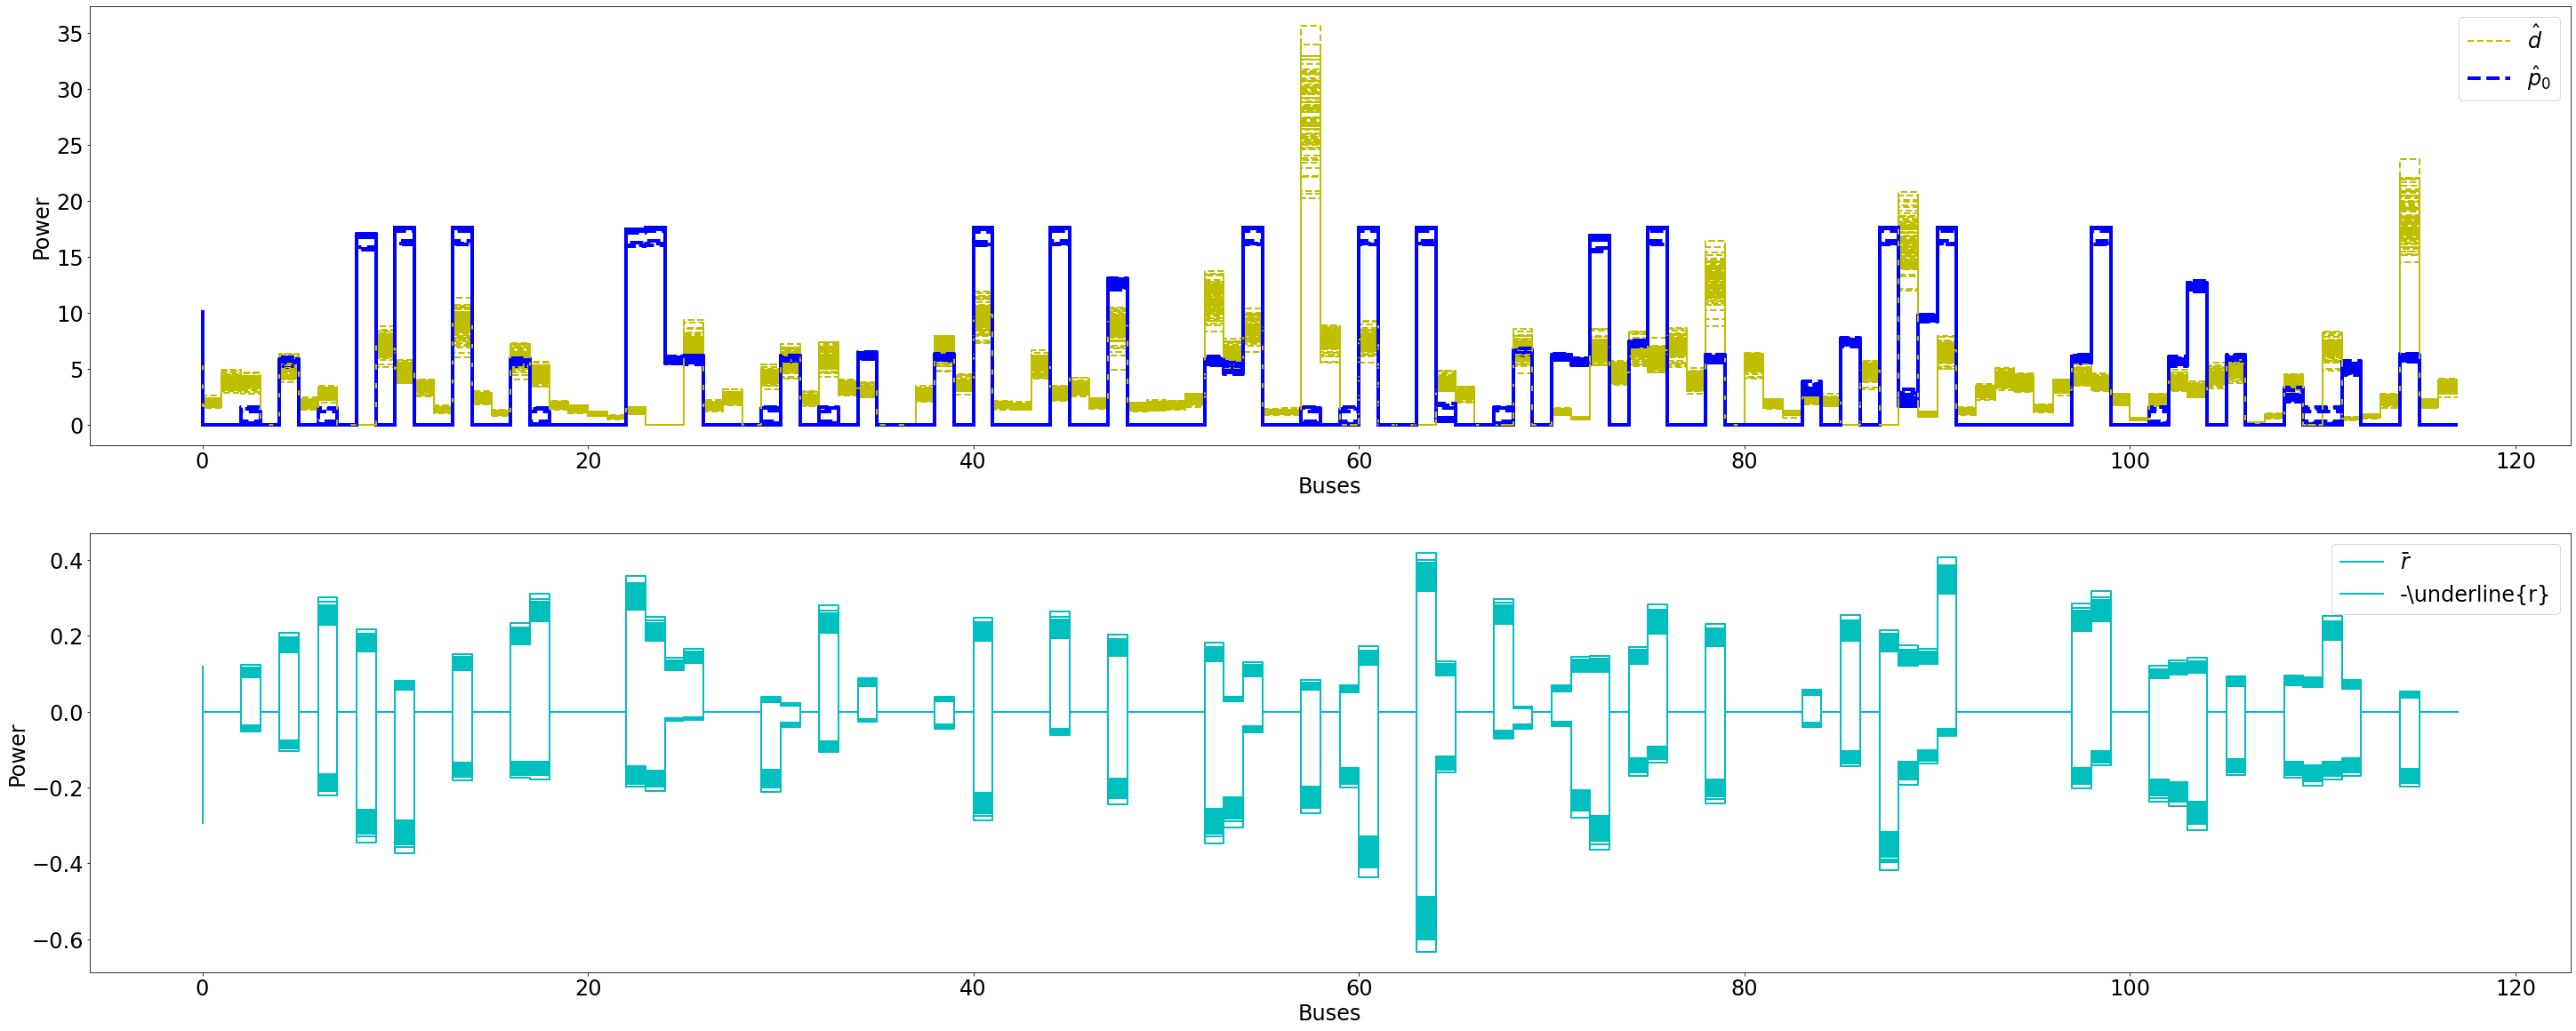

In [ ]:
# load dataset for test
nnTestData = np.load(inputDemandPath + 'nnTestData.npy')

X_test = nnTestData[:100, :]

predict(fs_net, X_test)

## on pretrain

sump0: [431.8426  437.9052  431.78555 432.54807 434.46152 438.94882 430.47046
 432.99115 430.44876 429.1687 ]
batchSumDemand_val shape: (10,)
batchSumDemand_val: [426.52737 437.81824 423.47272 422.696   410.0337  438.94846 427.91544
 430.53244 422.53195 417.66617]


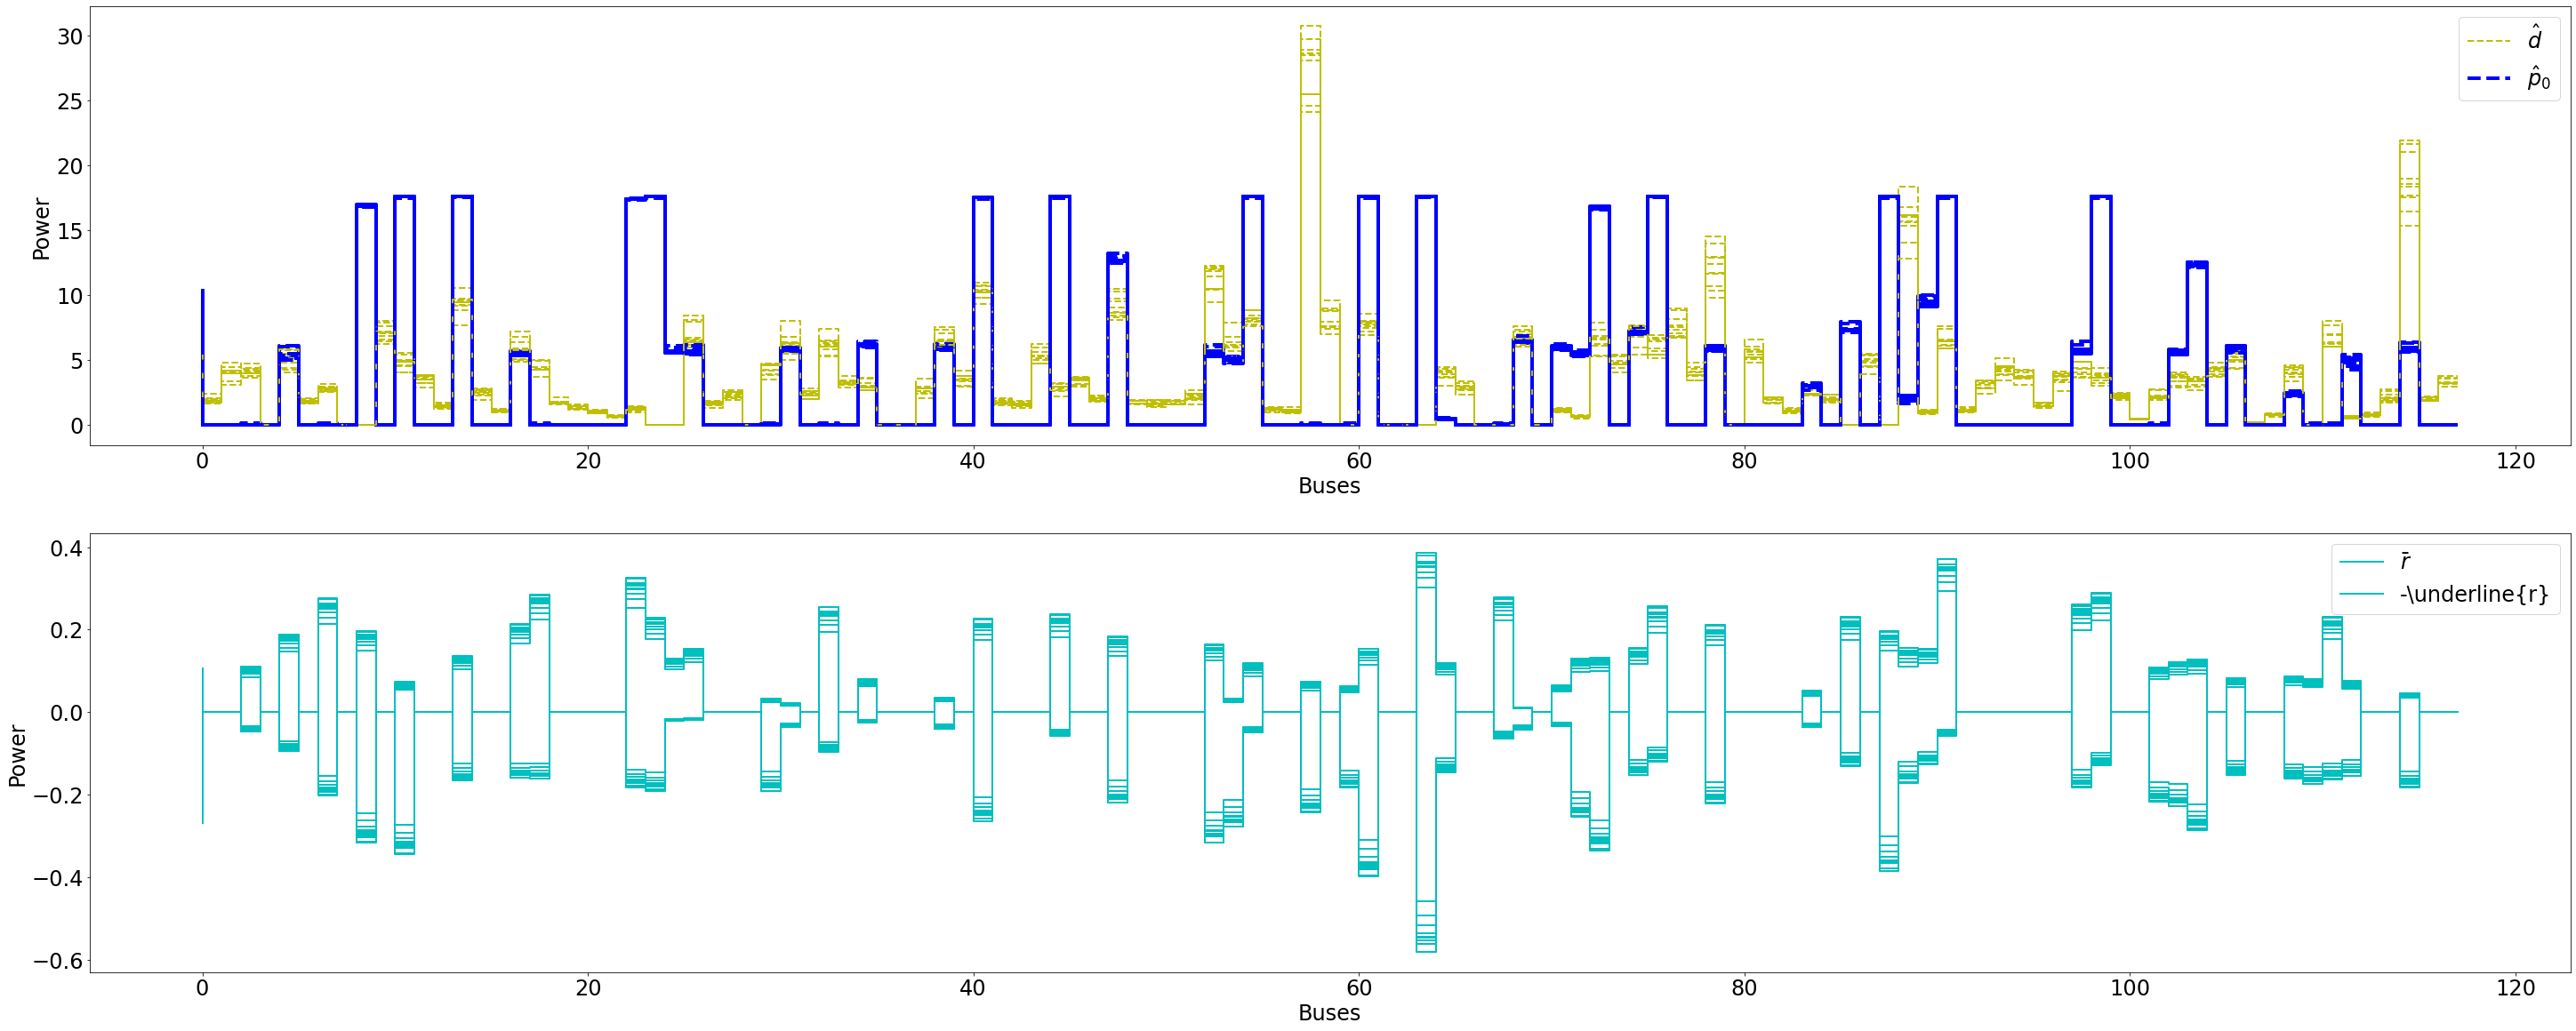

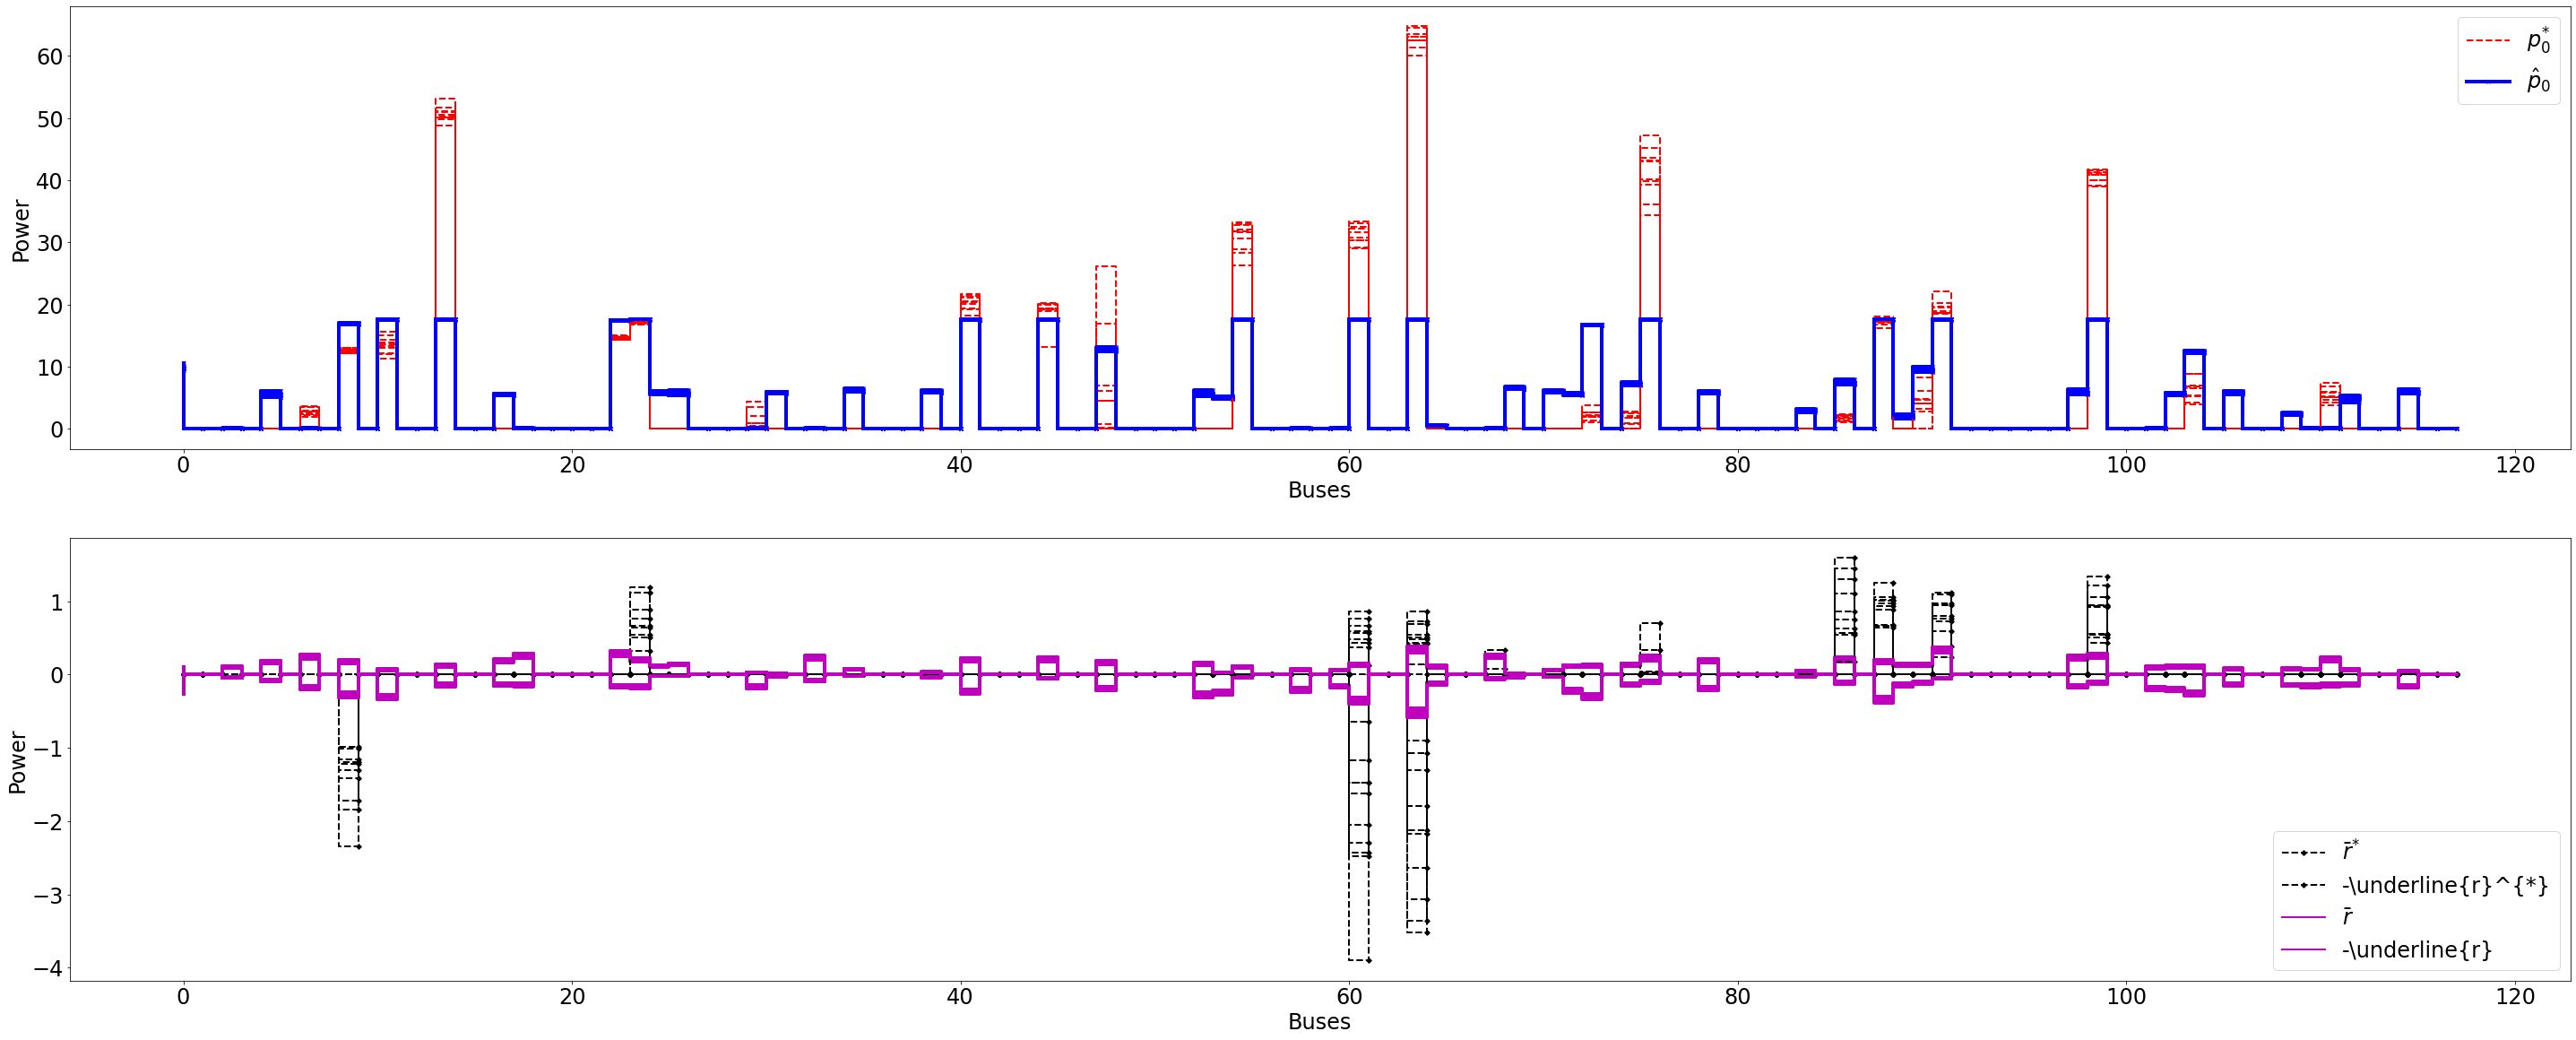

In [ ]:
# *========= TEST ON TRAIN SET ==========

# load dataset for test
X_preTrain = np.load(inputDemandPath + 'X_preTrain.npy')

predict(fs_net, X_preTrain[:, :numBuses], X_preTrain[:, numBuses:])


# pretrain_rcs.py

In [ ]:
def preTrainRcsNet(dataSet, initModel, lr, numEpochs, miniBatchSize, gamma_gen,
                   yPlot='plain', saveModels=True):
    # configure optimizer
    model = initModel
    adamOptimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

    # define loss criterion
    loss_criterion = nn.MSELoss()

    # format input data set
    train_loader = DataLoader(dataSet, batch_size=miniBatchSize, shuffle=True)

    # # gauge mapping
    # batch_rcsH = rcs_h_ts.repeat(1, miniBatchSize)

    # dictionary to store training process
    train_hist = {'train_losses': [], 'time_per_epoch': [], 'total_time': []}
    # total number of iterations
    num_iter = 0

    # *========== TRAINING START ===========
    print("Training starts!")
    start_time = time.time()

    for epoch in range(numEpochs):

        train_losses_per_epoch = []

        epoch_start_time = time.time()

        for miniBatch in train_loader:

            # get a batch of data
            batch_inputs = miniBatch.float().to(device)
            # # actual batch size
            # bs = batch_inputs.shape[0]

            d_omega_data = batch_inputs[:, :numBuses]
            target_data = batch_inputs[:, numBuses:]

            p0_target = target_data[:, :numBuses]
            rp_target = target_data[:, numBuses:numBuses+numBuses]
            rd_target = target_data[:, numBuses+numBuses:numBuses+numBuses+numBuses]
            rcs_target = target_data[:, numBuses+numBuses+numBuses:]

            theta_target = rcs_target[:, :numBuses]
            theta_target_nonslack = torch.cat([theta_target[:, :slackBusNo], theta_target[:, slackBusNo+1:]], dim=-1)
            # print('theta_target_nonslack:', theta_target_nonslack.shape)
            y_target = rcs_target[:, numBuses:]
            

            net_d_omega = d_omega_data - p0_target
            net_input = torch.cat([net_d_omega, rp_target, rd_target], dim=1)
            # print('net_input:', net_input.shape)

            # zero grad
            model.zero_grad()

            # make predictions
            theta_pred, y_pred = model(net_input)

            # # gauge mapping: map B_infinity to shifted polytope
            # theta_pred = gaugeMapping(net_output.T, rcsG_ts, batch_rcsH)

            # # get y_pred from theta_pred
            # full_y_pred = modB_ts @ theta_pred + net_d_omega.T
            # full_y_pred = full_y_pred.T

            # y_pred = full_y_pred[:, regGenSet]

            # theta_pred = net_output[:, :numBuses-1]
            # y_pred = net_output[:, numBuses-1:]

            # generator bound violation
            # fullMaxP = torch.zeros_like(d_omega_data)
            # fullMaxP[:, regGenSet] = maxP_ts.repeat(bs, 1).to(device)
            # genMaxBoundViol = relu(full_p0 + full_y_pred - fullMaxP)

            # fullMinP = torch.zeros_like(d_omega_data)
            # fullMinP[:, regGenSet] = minP_ts.repeat(bs, 1).to(device)
            # genMinBoundViol = relu(fullMinP - (full_p0 + full_y_pred))

            # calculate loss function
            # train_loss_per_batch = loss_criterion(theta_pred.T, theta_target_nonslack) 
            train_loss_per_batch = loss_criterion(y_pred, y_target)
            # train_loss_per_batch = torch.norm(full_y_pred-full_y_target, p=1)
                                    # loss_criterion(y_pred.sum(dim=1), net_d_omega.sum(dim=1))
            # train_loss_per_batch = loss_criterion(full_y_pred, full_y_target) + \
            #                        gamma_gen * torch.mean((genMaxBoundViol ** 2 +
            #                                                genMinBoundViol ** 2))
            # train_loss_per_batch = loss_criterion(theta_pred.T, theta_target_nonslack) + \
            #                        gamma_gen * torch.mean((genMaxBoundViol ** 2 +
            #                                                genMinBoundViol ** 2))

            # backpropagation
            train_loss_per_batch.backward(retain_graph=True)

            # update model
            adamOptimizer.step()

            train_losses_per_epoch.append(train_loss_per_batch.item())

            # *========== PRINT TRAINING PROGRESS ===========
            if num_iter == 0:
                print('\nTraining progress......')

            num_iter += 1
            if num_iter % 1000 == 0:
                print('Have done [%d epochs/%d iterations], avg loss is %.5f' % ((epoch + 1),
                                                                                 (num_iter + 1),
                                                                                 torch.FloatTensor(
                                                                                     train_losses_per_epoch).mean().item()))
        # end of epoch
        epoch_end_time = time.time()
        time_per_epoch = epoch_end_time - epoch_start_time

        loss_value_per_epoch = torch.mean(torch.FloatTensor(train_losses_per_epoch)).item()

        train_hist['train_losses'].append(round(loss_value_per_epoch, 4))
        train_hist['time_per_epoch'].append(time_per_epoch / 60)

        # *========== SAVE MODEL ===========
        if epoch == numEpochs - 1 or (epoch > 800 and epoch % 400 == 0):
            if saveModels:
                # save model
                torch.save(model.state_dict(), savedPreTrainPath + 'pretrain_rcs_net.pt')
            # save and display train loss if needed
            json.dump(train_hist['train_losses'], open(savedPreTrainPath + 'rcs_net_pretrain_loss', 'w'))
            display_train_loss(train_hist, epoch, 'pretrain_rcs_net_loss.png', yPlot)

    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Total %d epochs take time: %.2f minutes" %
          (numEpochs, total_time / 60))
    print("Training finishes!")

    return model

## train function

RCSNet(
  (convLayers): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 16, kernel_size=(4,), stride=(2,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(16, 8, kernel_size=(4,), stride=(2,))
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fcLayers): Sequential(
    (0): Linear(in_features=696, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=117, bias=True)
  )
)
Training starts!

Training progress......
Have done [200 epochs/1001 iterations], avg loss is 0.48905
Have done [400 epochs/2001 iterations], avg loss is 0.26319


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


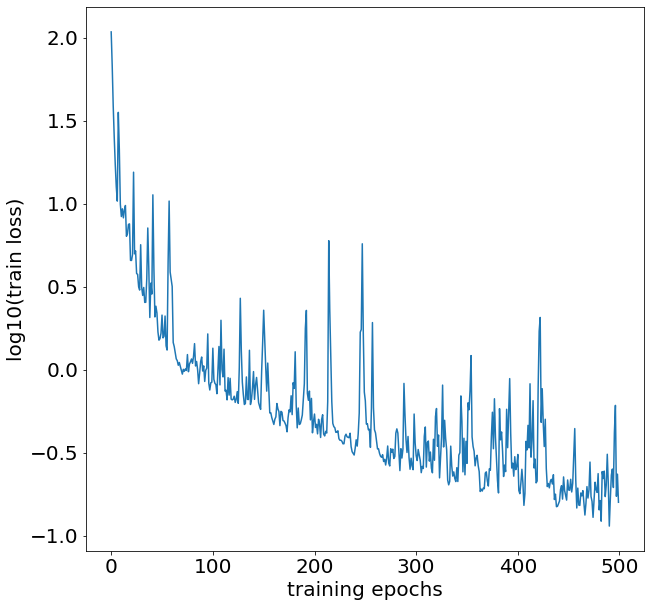

Total 500 epochs take time: 0.20 minutes
Training finishes!


In [ ]:
# conv params are arranged in n_channels, out_channels, kernel_size,
#                       stride, padding
conv1 = [1, 8, 3, 1, 1]  # -> L' = 118 + 118 + 118 = 354
conv2 = [8, 16, 4, 2, 0]  # -> L' = 176
conv3 = [16, 8, 4, 2, 0]  # -> L' = 87
# fc params are arranged in in_features, out_features
fc1 = [int(8 * 87), 512]
fc2 = [512, 256]
fc3 = [256, 117]
rcsNet = RCSNet(conv1, conv2, conv3, fc1, fc2, fc3)
print(rcsNet)
# rcsNet.apply(init_weights)
rcsNet.to(device)

X_preTrain2 = np.load(inputDemandPath + 'X_preTrain2.npy')
rcsPreTrainData = CustomPowerDataset(X_preTrain2)

pretrained_rcsNet = preTrainRcsNet(rcsPreTrainData, rcsNet, lr=1e-3/2.
               , numEpochs=500, miniBatchSize=2, gamma_gen=gammaRes,
               yPlot='log10', saveModels=True)

## use pretrained

In [ ]:
# *========== MAKE PREDICTIONS ==========
def predict(model, net_d_omega_data, input_data, target=None):
    net_d_omega = torch.tensor(net_d_omega_data).float().to(device)
    net_input = torch.tensor(input_data).float().to(device)
    
    # define actual test size
    numTest = input_data.shape[0]

    # *========== LOAD TRAINED NEURAL NETWORK ==========
    model.load_state_dict(torch.load(savedPreTrainPath + 'pretrain_rcs_net.pt'))
    # turn off drop-out layers
    model.eval()

    with torch.no_grad():
        theta_pred, full_y_pred = model(net_input)
        print('theta_pred:', theta_pred.shape)

        y_pred = full_y_pred[:, regGenSet]

        theta_pred_val = theta_pred.cpu().detach().numpy()
        full_y_pred_val = full_y_pred.cpu().detach().numpy()
        y_pred_val = y_pred.cpu().detach().numpy()

        fig, axes = plt.subplots(2, 1, figsize=(50, 20))
        for i in range(numTest):
            if i == 0:
                axes[0].step(theta_pred_val[i, :], 'm--', linewidth=2, markersize=12, label=r'$\hat{\theta}$')

                # axes[1].step(input_data[i, :], 'y--', linewidth=2, markersize=12, label=r'$\tilde{d}$')
                axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{y}$')
            else:
                axes[0].step(theta_pred_val[i, :], 'm--', linewidth=2, markersize=12)

                # axes[1].step(input_data[i, :], 'y--', linewidth=2, markersize=12)
                axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12)

        axes[0].axhline(y=np.pi, color='lightgrey', linestyle='--', linewidth=4, )
        axes[0].axhline(y=-np.pi, color='lightgrey', linestyle='--', linewidth=4, )

        for ax in axes:
            ax.legend(fontsize=24)
            ax.tick_params(axis='x', labelsize=24)
            ax.tick_params(axis='y', labelsize=24)

        plt.show()


        if target is not None:

            theta_target = target[:, :numBuses]
            theta_target_nonslack = np.concatenate([theta_target[:, :slackBusNo], theta_target[:, slackBusNo+1:]], axis=-1)
            y_target = target[:, numBuses:]
            full_y_target = y_target
            print(r'Prediction error of $\theta$ is %.4f' % measure_relative_distance(theta_target_nonslack, theta_pred_val))
            print(r'Prediction error of y is %.4f' % measure_relative_distance(full_y_target, full_y_pred_val))

            fig, axes = plt.subplots(2, 1, figsize=(50, 20))
            for i in range(numTest):
                if i == 0:
                    axes[0].step(theta_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{\theta}$')
                    axes[0].step(theta_target_nonslack[i, :], 'r--', linewidth=2, markersize=12, label=r'${\theta}^{*}$',
                                 alpha=0.5)

                    # axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{y}$')
                    # axes[1].step(full_y_target[i, :], 'r--', linewidth=2, markersize=12, label=r'${y}^{*}$', alpha=0.5)
                    axes[1].step(y_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{y}$')
                    axes[1].step(y_target[i, regGenSet], 'r--', linewidth=2, markersize=12, label=r'${y}^{*}$', alpha=0.5)
                else:
                    axes[0].step(theta_pred_val[i, :], 'b--', linewidth=2, markersize=12)
                    axes[0].step(theta_target_nonslack[i, :], 'r--', linewidth=2, markersize=12, alpha=0.5)

                    # axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12)
                    # axes[1].step(full_y_target[i, :], 'r--', linewidth=2, markersize=12, alpha=0.5)
                    axes[1].step(y_pred_val[i, :], 'b--', linewidth=2, markersize=12)
                    axes[1].step(y_target[i, regGenSet], 'r--', linewidth=2, markersize=12, alpha=0.5)

            axes[0].axhline(y=np.pi, color='lightgrey', linestyle='--', linewidth=4, )
            axes[0].axhline(y=-np.pi, color='lightgrey', linestyle='--', linewidth=4, )

            for ax in axes:
                ax.legend(fontsize=24)
                ax.tick_params(axis='x', labelsize=24)
                ax.tick_params(axis='y', labelsize=24)

            plt.show()


## on pretrain

net_input: (10, 354)
theta_pred: torch.Size([10, 117])


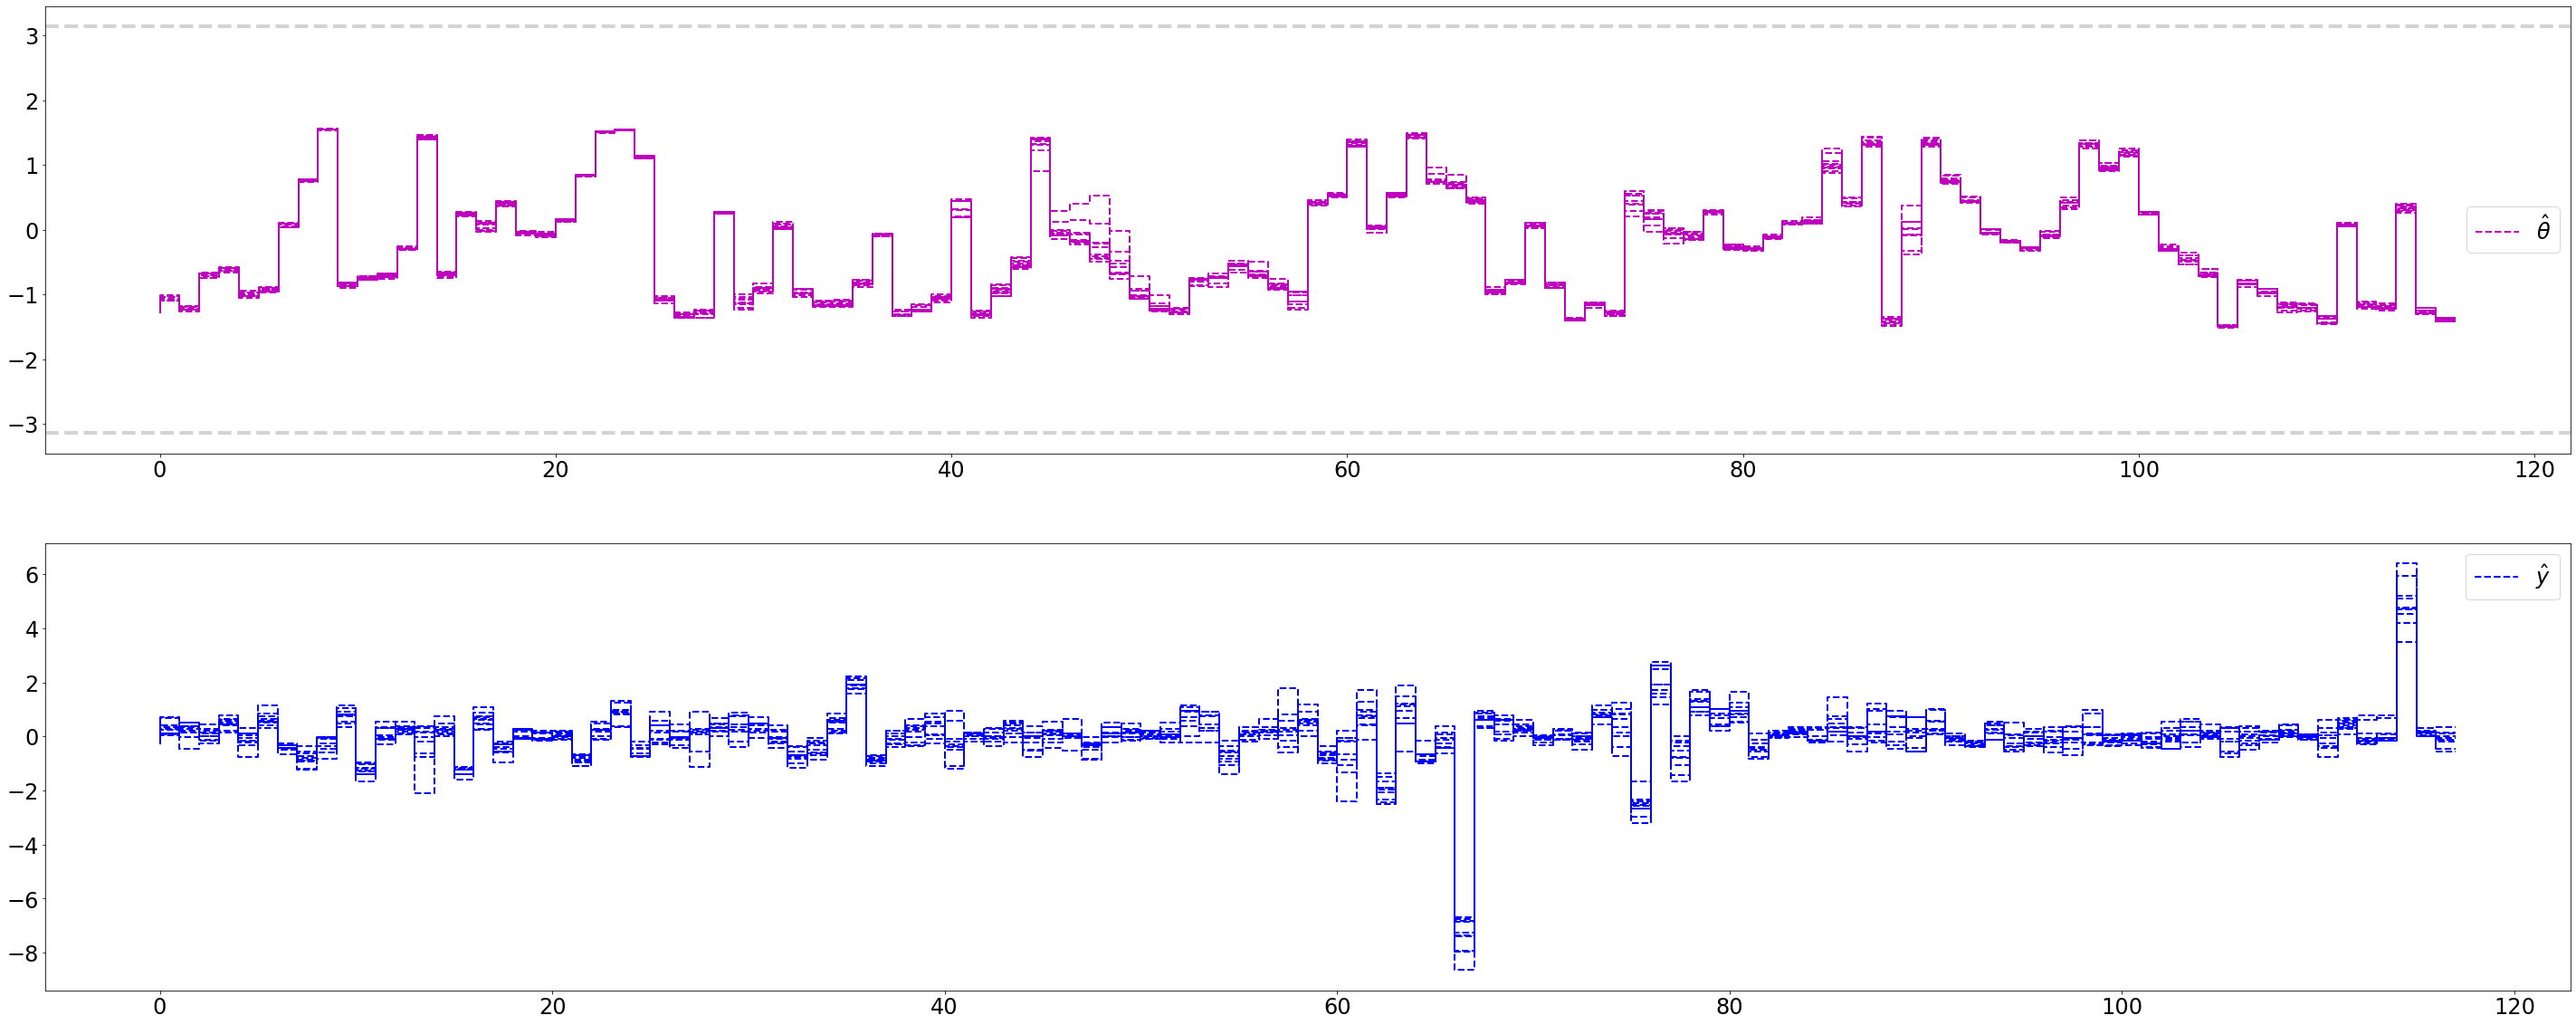

Prediction error of $\theta$ is 0.1892
Prediction error of y is 6.2364


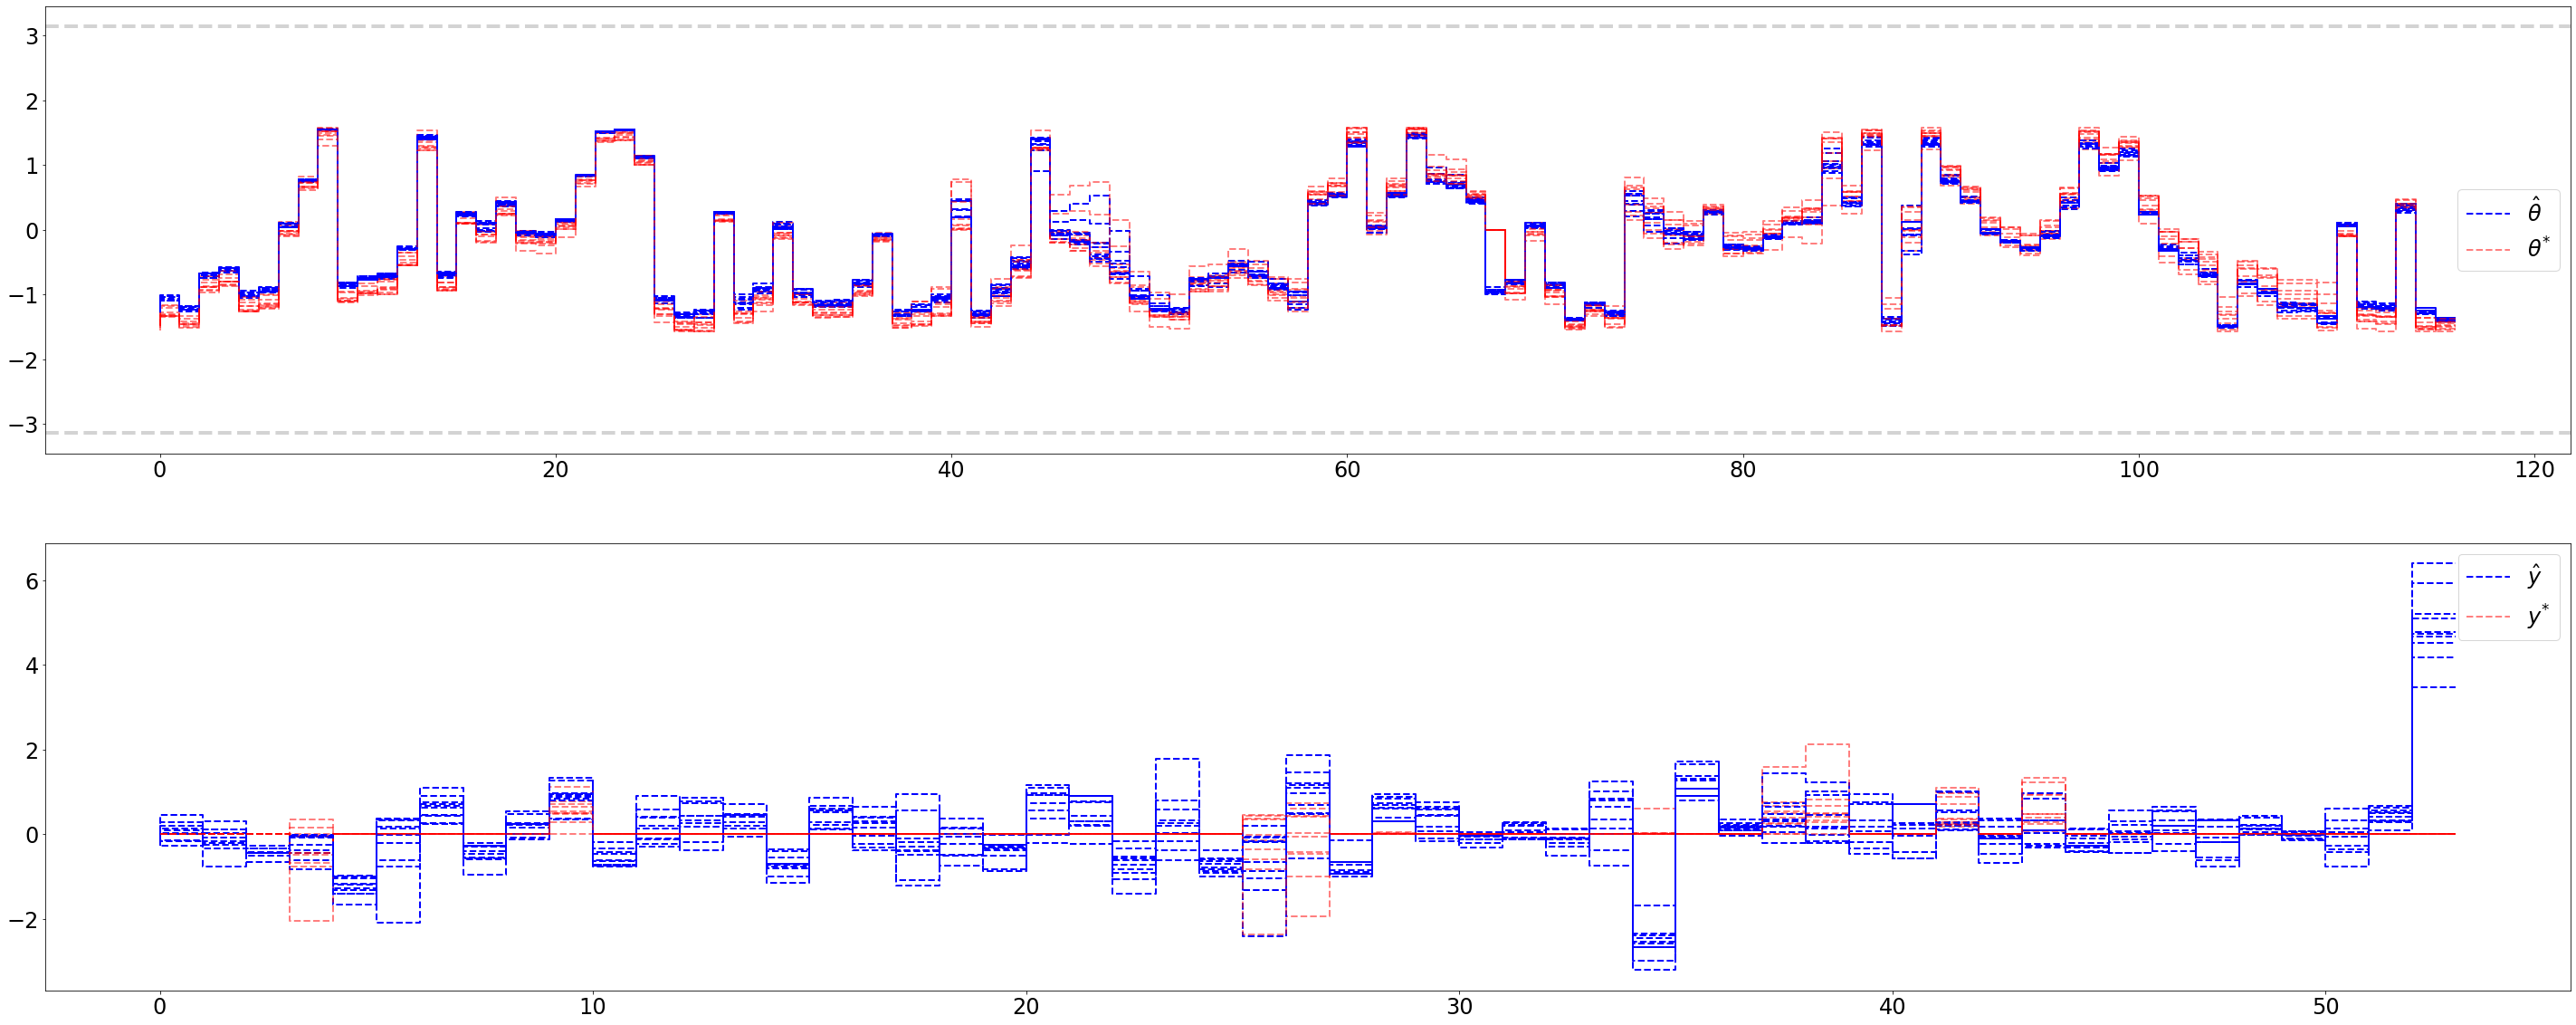

In [ ]:
# *========== TEST ON TRAIN  ==========

X_preTrain2 = np.load(inputDemandPath + 'X_preTrain2.npy')
input_data = X_preTrain2

d_omega = input_data[:, :numBuses]
target = input_data[:, numBuses:]

p0_target = target[:, :numBuses]
rp_target = target[:, numBuses:numBuses+numBuses]
rd_target = target[:, numBuses+numBuses:numBuses+numBuses+numBuses]

rcs_target = target[:, numBuses+numBuses+numBuses:]

theta_target = rcs_target[:, :numBuses]
y_target = rcs_target[:, numBuses:]

p0_extension = p0_target

net_d_omega = d_omega - p0_extension

net_input = np.concatenate([net_d_omega, rp_target, rd_target], axis=1)
print('net_input:', net_input.shape)
# if featureEngOption:
# net_input = torch.cat([relu(net_d_omega),
#                        -relu(-net_d_omega)], dim=1)


# fig, ax = plt.subplots(figsize=(40, 10))
# ax.step(range(118), net_d_omega[0, :])
# ax.step(range(118), rcs_target[0, :118])
# ax.step(range(118), rcs_target[0, 118:])
# ax.step(range(54), -rd_target[0, :])

# plt.show()
predict(rcsNet, net_d_omega, net_input, rcs_target)



# neuralPolicy.py

In [ ]:
# import torch.nn.functional as F

def train(dataSet, init_fsNet, init_rcsNet, lr, numEpochs,
          miniBatchSize, numScenarios, gamma_res, gamma_gen,
          saveModels=True, yPlot='log10'):
    # configure optimizer
    fsNet = init_fsNet
    rcsNet = init_rcsNet
    fsOptimizer = optim.Adam(fsNet.parameters(), lr=lr, betas=(0.5, 0.999))
    rcsOptimizer = optim.Adam(rcsNet.parameters(), lr=lr, betas=(0.5, 0.999))

    # format input data set
    train_loader = DataLoader(dataSet, batch_size=miniBatchSize, shuffle=True)

    def to_n_dim(x, n):
        m = x.shape[0]
        x_ = torch.zeros(m, n).to(device)
        x_[:, regGenSet] = x
        return x_

    def custom_expand(x, m, num_sce):
        assert x.shape[0] == m
        assert x.shape[1] == numBuses
        x_ = torch.unsqueeze(x, 1)
        x = x_.expand(-1, num_sce, -1)

        return torch.flatten(x, start_dim=0, end_dim=1)

    # dictionary to store training process
    train_hist = {'train_losses': [], 'time_per_epoch': [], 'total_time': []}
    cost_hist = {'c_fs': [], 'c_rcs': [], 'c_gen': [], 'c_res': []}
    # total number of iterations
    num_iter = 0

    # *========== TRAINING START ===========
    print("Training starts!")
    print("Use device:", device)
    start_time = time.time()

    for epoch in range(numEpochs):

        train_losses_per_epoch = []
        c_fs_per_epoch = []
        c_rcs_per_epoch = []
        c_gen_per_epoch = []
        c_res_per_epoch = []

        epoch_start_time = time.time()

        for miniBatch in train_loader:

            # get a batch of data
            inputData = miniBatch.float().to(device)
            # actual batch size
            bs = inputData.shape[0]

            # zero grad
            fsNet.zero_grad()
            rcsNet.zero_grad()

            # make predictions for first-stage decisions: x=[p0, rp, rd]
            full_p0_pred, full_rp_pred, full_rd_pred, shifted_fsH  = fsNet(inputData)
            # check if zero is a strict interior point of the shifted polytope
            assert torch.max(-shifted_fsH) < 0.0, "zero is not a strict interior point of polytope defined by (fsG, fs_h3)!"

            # full_p0_pred = fs_output[:, :numBuses]
            # full_rp_pred = fs_output[:, numBuses:numBuses + numBuses]
            # full_rd_pred = fs_output[:, numBuses + numBuses:]

            c_gen_pred, c_res_pred, fs_pen_cost = estimate_fsCost(full_p0_pred[:, regGenSet],
                                                     full_rp_pred[:, regGenSet], full_rd_pred[:, regGenSet],
                                                     gamma_gen=gammaGen)
            fsCost_pred = c_gen_pred + c_res_pred

            # *========== GENERATE REALIZED SCENARIOS ===========
            # to speed up training, all points in the same batch share
            # the same predMean and deviationStdev
            idx = np.random.choice(miniBatchSize, 1)[0]
            batch_predMean = inputData[idx, :] * inputScalingFactor
            batch_stdev = realTimeDemandStdevFactor * batch_predMean

            # find Cholesky factorization of the demand covariance matrix
            # for zero stdev, set them to be small, i.e., 0.1
            batch_stdev = torch.where(batch_stdev < 1e-5, 0.1, batch_stdev)
            batch_demandCovMat = torch.diag(batch_stdev) @ demandCorrMat_ts @ torch.diag(batch_stdev)
            batch_demandCovMat_chol = torch.linalg.cholesky(batch_demandCovMat, upper=False, )

            # initialize stdNormalMatrix for each minibatch
            stdNormalMatrix = np.random.multivariate_normal([0.] * numBuses, np.eye(numBuses),
                                                            (miniBatchSize, numScenarios))
            stdNormalMatrix_ts = torch.tensor(stdNormalMatrix).float()
            # print('stdNormalMatrix_ts:', stdNormalMatrix_ts.shape)

            # *========== PROCESS ALL SCENARIOS IN THE SAME BATCH SIMULTANEOUSLY===========

            batch_p0_pred = custom_expand(full_p0_pred, bs, numScenarios)  # of size(bs*numScenarios, numBuses)
            batch_rp_pred = custom_expand(full_rp_pred, bs, numScenarios)
            batch_rd_pred = custom_expand(full_rd_pred, bs, numScenarios)
            batch_predDemand = custom_expand(inputData, bs, numScenarios) * inputScalingFactor
            # print('batch_p0_pred:', batch_p0_pred.shape)
            # print('batch_rp_pred:', batch_rp_pred.shape)
            # print('batch_rd_pred:', batch_rd_pred.shape)
            # print('batch_predDemand:', batch_predDemand.shape)

            batch_stdNormalMatrix = torch.flatten(stdNormalMatrix_ts, start_dim=0, end_dim=1).clone().to(device)
            # print('batch_stdNormalMatrix:', batch_stdNormalMatrix.shape)
            
            batch_d_omega = batch_stdNormalMatrix @ batch_demandCovMat_chol + batch_predDemand
            # print('batch_d_omega:', batch_d_omega.shape)

            net_d_omega = batch_d_omega - batch_p0_pred
            # print('net_d_omega:', net_d_omega.shape)

            Q_input = torch.cat([net_d_omega, batch_rp_pred, batch_rd_pred], dim=1)
            # print('Q_input:', Q_input.shape)

            # return batch_d_omega[0, :].detach().cpu().numpy(), batch_p0_pred[0, :].detach().cpu().numpy()


            # *========== IMPLEMENT RECOURSE STAGE NET ===========

            # make predictions for recourse stage phase angles
            _, batch_y_pred = rcsNet(Q_input)
            # print('batch_y_pred:', batch_y_pred.shape)

            # Q_pred += estimateQValue(y_pred, p0_pred, rp_pred, rd_pred, gamma_res, gamma_gen)
            Q_pred = estimateQValue(batch_y_pred, batch_p0_pred, batch_rp_pred, batch_rd_pred, gamma_res, gamma_gen)

            # loss criterion
            train_loss_per_batch = fsCost_pred + fs_pen_cost + Q_pred

            # backpropagation
            train_loss_per_batch.backward(retain_graph=True)

            # update models
            fsOptimizer.step()
            rcsOptimizer.step()

            train_losses_per_epoch.append(train_loss_per_batch.item())
            c_fs_per_epoch.append(fsCost_pred.item())
            c_gen_per_epoch.append(c_gen_pred.item())
            c_res_per_epoch.append(c_res_pred.item())
            c_rcs_per_epoch.append(Q_pred.item())

            # *========== PRINT TRAINING PROGRESS ===========
            if num_iter == 0:
                print('\nTraining progress......')

            num_iter += 1
            if num_iter % 5000 == 0:
                print('Have done [%d epochs/%d iterations], avg loss is %.5f' % ((epoch + 1),
                                                                                 (num_iter + 1),
                                                                                 torch.FloatTensor(
                                                                                     train_losses_per_epoch).mean().item()))
        # end of epoch
        epoch_end_time = time.time()
        time_per_epoch = epoch_end_time - epoch_start_time

        loss_value_per_epoch = torch.mean(torch.FloatTensor(train_losses_per_epoch)).item()

        train_hist['train_losses'].append(round(loss_value_per_epoch, 4))
        train_hist['time_per_epoch'].append(time_per_epoch / 60)

        cost_hist['c_fs'].append(round(torch.mean(torch.FloatTensor(c_fs_per_epoch)).item(), 4))
        cost_hist['c_rcs'].append(round(torch.mean(torch.FloatTensor(c_rcs_per_epoch)).item(), 4))
        cost_hist['c_gen'].append(round(torch.mean(torch.FloatTensor(c_gen_per_epoch)).item(), 4))
        cost_hist['c_res'].append(round(torch.mean(torch.FloatTensor(c_res_per_epoch)).item(), 4))

        # *========== SAVE MODEL ===========
        if epoch == numEpochs - 1 or epoch % 100 == 0:
            if saveModels:
                # save model
                torch.save(fsNet.state_dict(), savedTrainPath + str(epoch) + 'fsNet.pt')
                torch.save(rcsNet.state_dict(), savedTrainPath +  str(epoch) + 'rcsNet.pt')
            # save and display train loss if needed
            json.dump(train_hist, open(savedTrainPath + 'train_hist', 'w'))
            json.dump(cost_hist, open(savedTrainPath + 'cost_hist', 'w'))
            display_train_loss(train_hist, epoch, 'train_loss.png', yPlot)

    end_time = time.time()
    total_time = end_time - start_time
    train_hist['total_time'].append(total_time)

    print("Training finishes!")
    print("Total %d epochs take time: %.2f minutes" %
          (numEpochs, total_time / 60))

    return fsNet, rcsNet, train_hist, cost_hist

## train function

Training starts!
Use device: cuda:0

Training progress......


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


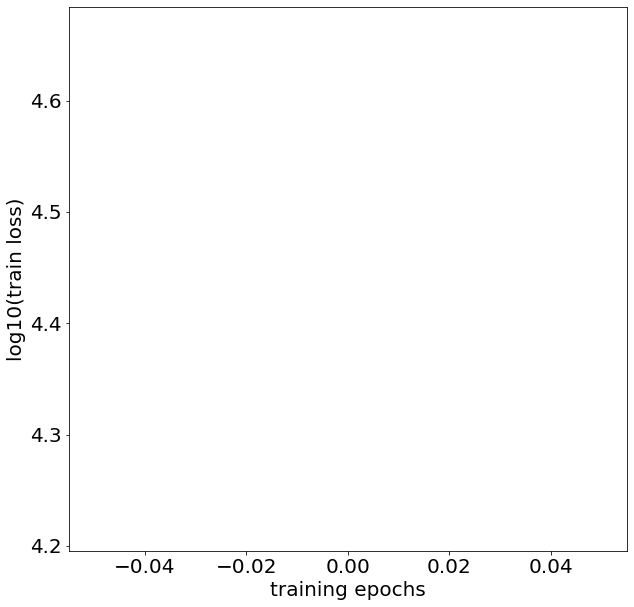

Have done [5 epochs/5001 iterations], avg loss is 8982.52441
Have done [10 epochs/10001 iterations], avg loss is 7114.90381
Have done [15 epochs/15001 iterations], avg loss is 6250.88818
Have done [20 epochs/20001 iterations], avg loss is 5755.68262
Have done [25 epochs/25001 iterations], avg loss is 5430.44385
Have done [30 epochs/30001 iterations], avg loss is 5201.10498
Have done [35 epochs/35001 iterations], avg loss is 5019.65771
Have done [40 epochs/40001 iterations], avg loss is 4900.80908
Have done [45 epochs/45001 iterations], avg loss is 4785.72607
Have done [50 epochs/50001 iterations], avg loss is 4686.47461
Have done [55 epochs/55001 iterations], avg loss is 4605.01465
Have done [60 epochs/60001 iterations], avg loss is 4533.72119
Have done [65 epochs/65001 iterations], avg loss is 4470.19678
Have done [70 epochs/70001 iterations], avg loss is 4422.11279
Have done [75 epochs/75001 iterations], avg loss is 4367.16162
Have done [80 epochs/80001 iterations], avg loss is 4329.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


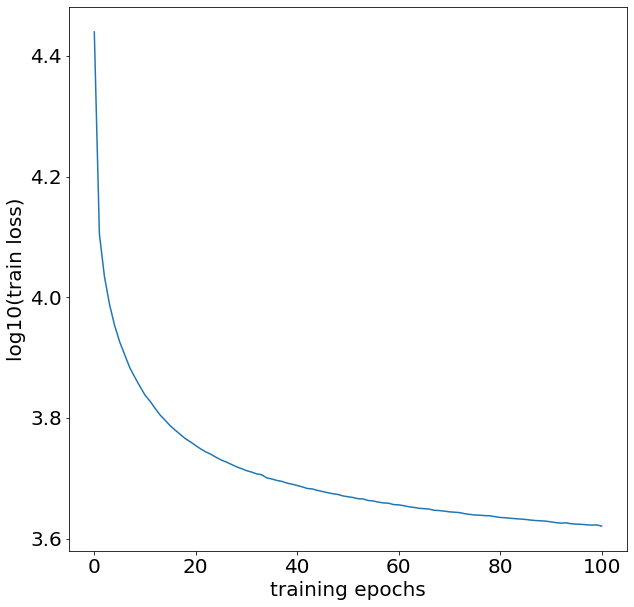

Have done [105 epochs/105001 iterations], avg loss is 4162.24316
Have done [110 epochs/110001 iterations], avg loss is 4138.02686
Have done [115 epochs/115001 iterations], avg loss is 4106.09521
Have done [120 epochs/120001 iterations], avg loss is 4087.43042
Have done [125 epochs/125001 iterations], avg loss is 4066.77832
Have done [130 epochs/130001 iterations], avg loss is 4052.46338
Have done [135 epochs/135001 iterations], avg loss is 4034.68994
Have done [140 epochs/140001 iterations], avg loss is 4019.75659
Have done [145 epochs/145001 iterations], avg loss is 4004.33203
Have done [150 epochs/150001 iterations], avg loss is 3985.51685
Have done [155 epochs/155001 iterations], avg loss is 3976.88672
Have done [160 epochs/160001 iterations], avg loss is 3968.56689
Have done [165 epochs/165001 iterations], avg loss is 3947.49341
Have done [170 epochs/170001 iterations], avg loss is 3942.82959
Have done [175 epochs/175001 iterations], avg loss is 3924.65381
Have done [180 epochs/180

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


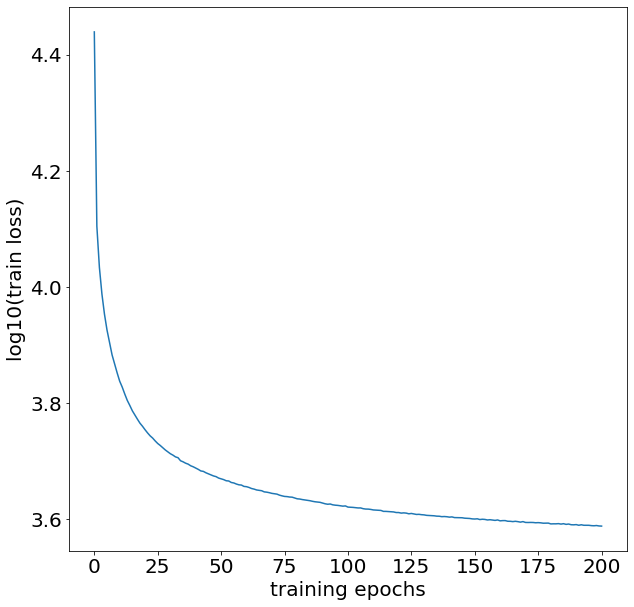

Have done [205 epochs/205001 iterations], avg loss is 3864.98047
Have done [210 epochs/210001 iterations], avg loss is 3855.61914
Have done [215 epochs/215001 iterations], avg loss is 3849.55225
Have done [220 epochs/220001 iterations], avg loss is 3841.19946
Have done [225 epochs/225001 iterations], avg loss is 3833.02295
Have done [230 epochs/230001 iterations], avg loss is 3828.91846
Have done [235 epochs/235001 iterations], avg loss is 3822.63647
Have done [240 epochs/240001 iterations], avg loss is 3814.14160
Have done [245 epochs/245001 iterations], avg loss is 3806.04639
Have done [250 epochs/250001 iterations], avg loss is 3796.93066
Have done [255 epochs/255001 iterations], avg loss is 3795.55981
Have done [260 epochs/260001 iterations], avg loss is 3791.63647
Have done [265 epochs/265001 iterations], avg loss is 3779.80005
Have done [270 epochs/270001 iterations], avg loss is 3770.92358
Have done [275 epochs/275001 iterations], avg loss is 3764.50171
Have done [280 epochs/280

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


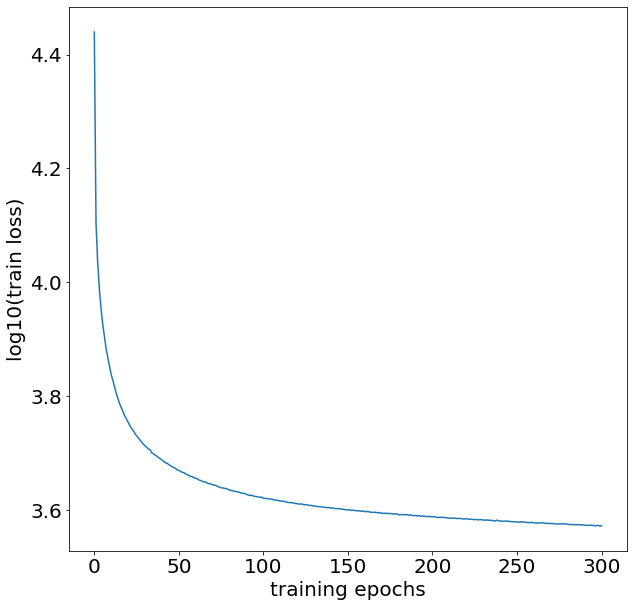

Have done [305 epochs/305001 iterations], avg loss is 3734.08911
Have done [310 epochs/310001 iterations], avg loss is 3730.51221
Have done [315 epochs/315001 iterations], avg loss is 3721.72827
Have done [320 epochs/320001 iterations], avg loss is 3718.32837
Have done [325 epochs/325001 iterations], avg loss is 3713.21655
Have done [330 epochs/330001 iterations], avg loss is 3707.46680
Have done [335 epochs/335001 iterations], avg loss is 3700.60815
Have done [340 epochs/340001 iterations], avg loss is 3695.31543
Have done [345 epochs/345001 iterations], avg loss is 3694.93823
Have done [350 epochs/350001 iterations], avg loss is 3691.12207
Have done [355 epochs/355001 iterations], avg loss is 3687.03198
Have done [360 epochs/360001 iterations], avg loss is 3686.84375
Have done [365 epochs/365001 iterations], avg loss is 3680.20435
Have done [370 epochs/370001 iterations], avg loss is 3675.16748
Have done [375 epochs/375001 iterations], avg loss is 3676.97998
Have done [380 epochs/380

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


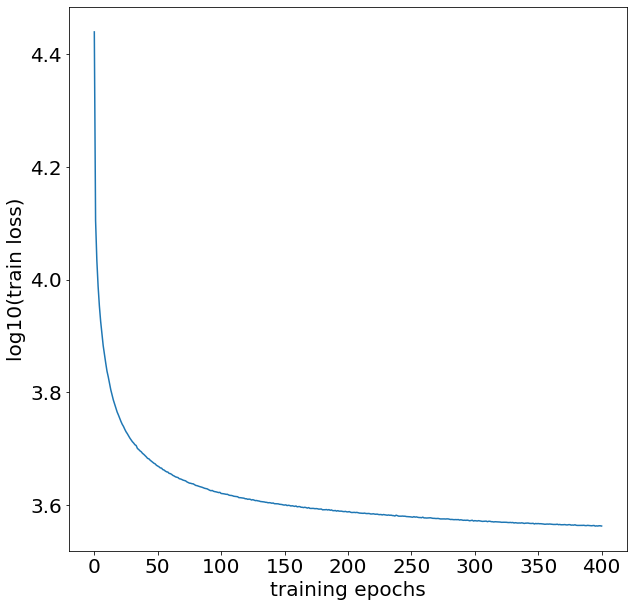

Have done [405 epochs/405001 iterations], avg loss is 3656.60278
Have done [410 epochs/410001 iterations], avg loss is 3648.73755
Have done [415 epochs/415001 iterations], avg loss is 3647.98853
Have done [420 epochs/420001 iterations], avg loss is 3643.84351
Have done [425 epochs/425001 iterations], avg loss is 3640.59521
Have done [430 epochs/430001 iterations], avg loss is 3636.55396
Have done [435 epochs/435001 iterations], avg loss is 3635.60132
Have done [440 epochs/440001 iterations], avg loss is 3630.46582
Have done [445 epochs/445001 iterations], avg loss is 3630.21948
Have done [450 epochs/450001 iterations], avg loss is 3629.69971
Have done [455 epochs/455001 iterations], avg loss is 3630.41211
Have done [460 epochs/460001 iterations], avg loss is 3623.68774
Have done [465 epochs/465001 iterations], avg loss is 3618.21997
Have done [470 epochs/470001 iterations], avg loss is 3616.57251
Have done [475 epochs/475001 iterations], avg loss is 3618.25220
Have done [480 epochs/480

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


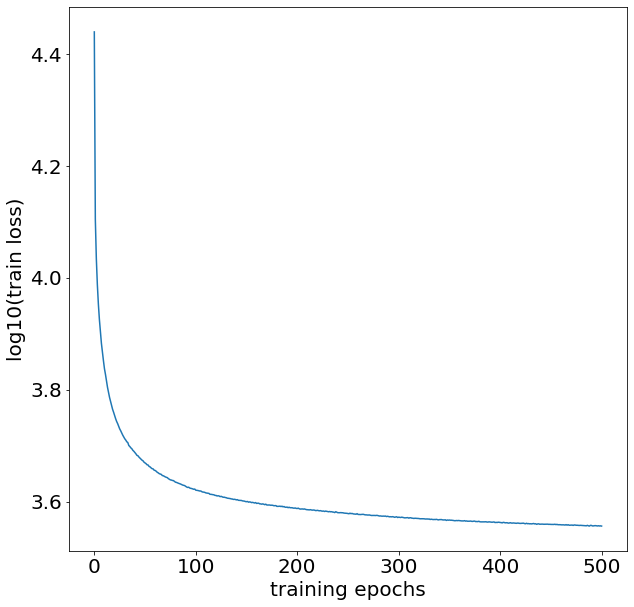

Have done [505 epochs/505001 iterations], avg loss is 3604.72485
Have done [510 epochs/510001 iterations], avg loss is 3605.16553
Have done [515 epochs/515001 iterations], avg loss is 3599.41309
Have done [520 epochs/520001 iterations], avg loss is 3601.20801
Have done [525 epochs/525001 iterations], avg loss is 3592.93481
Have done [530 epochs/530001 iterations], avg loss is 3588.95679
Have done [535 epochs/535001 iterations], avg loss is 3589.19385
Have done [540 epochs/540001 iterations], avg loss is 3587.27905
Have done [545 epochs/545001 iterations], avg loss is 3585.09302
Have done [550 epochs/550001 iterations], avg loss is 3585.50171
Have done [555 epochs/555001 iterations], avg loss is 3581.98608
Have done [560 epochs/560001 iterations], avg loss is 3580.67700
Have done [565 epochs/565001 iterations], avg loss is 3577.96289
Have done [570 epochs/570001 iterations], avg loss is 3577.40674
Have done [575 epochs/575001 iterations], avg loss is 3576.85596
Have done [580 epochs/580

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


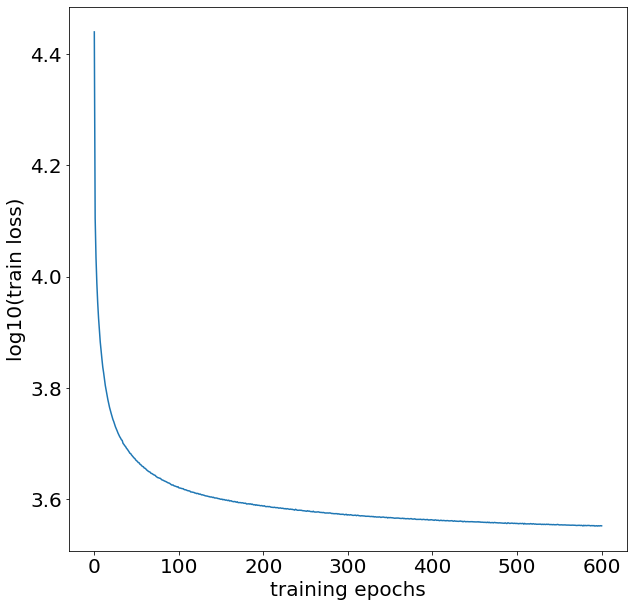

Have done [605 epochs/605001 iterations], avg loss is 3565.34351
Have done [610 epochs/610001 iterations], avg loss is 3564.67798
Have done [615 epochs/615001 iterations], avg loss is 3564.34106
Have done [620 epochs/620001 iterations], avg loss is 3560.77002
Have done [625 epochs/625001 iterations], avg loss is 3560.92236
Have done [630 epochs/630001 iterations], avg loss is 3558.14282
Have done [635 epochs/635001 iterations], avg loss is 3557.84180
Have done [640 epochs/640001 iterations], avg loss is 3555.68848
Have done [645 epochs/645001 iterations], avg loss is 3555.52588
Have done [650 epochs/650001 iterations], avg loss is 3552.40845
Have done [655 epochs/655001 iterations], avg loss is 3549.99902
Have done [660 epochs/660001 iterations], avg loss is 3551.94873
Have done [665 epochs/665001 iterations], avg loss is 3548.45142
Have done [670 epochs/670001 iterations], avg loss is 3550.83911
Have done [675 epochs/675001 iterations], avg loss is 3548.18286
Have done [680 epochs/680

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


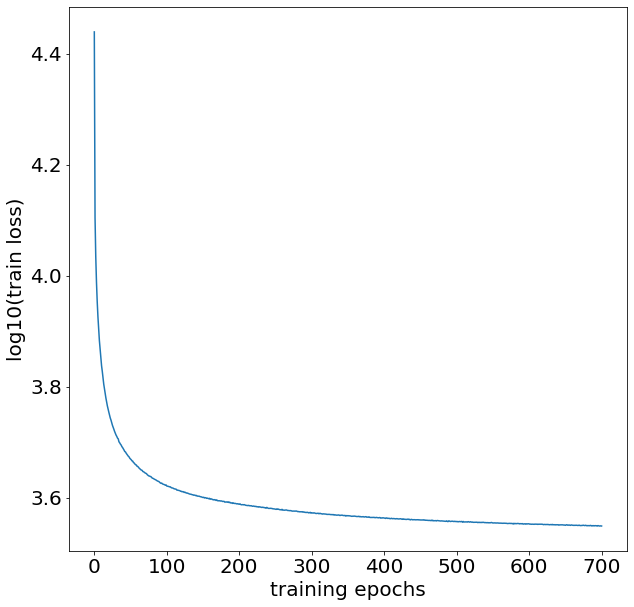

Have done [705 epochs/705001 iterations], avg loss is 3537.55664
Have done [710 epochs/710001 iterations], avg loss is 3541.92456
Have done [715 epochs/715001 iterations], avg loss is 3540.48364
Have done [720 epochs/720001 iterations], avg loss is 3534.31396
Have done [725 epochs/725001 iterations], avg loss is 3531.75366
Have done [730 epochs/730001 iterations], avg loss is 3533.26636
Have done [735 epochs/735001 iterations], avg loss is 3529.38940
Have done [740 epochs/740001 iterations], avg loss is 3531.81030
Have done [745 epochs/745001 iterations], avg loss is 3530.24780
Have done [750 epochs/750001 iterations], avg loss is 3527.92725
Have done [755 epochs/755001 iterations], avg loss is 3525.63379
Have done [760 epochs/760001 iterations], avg loss is 3528.37646
Have done [765 epochs/765001 iterations], avg loss is 3525.82715
Have done [770 epochs/770001 iterations], avg loss is 3523.68042
Have done [775 epochs/775001 iterations], avg loss is 3520.85718
Have done [780 epochs/780

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


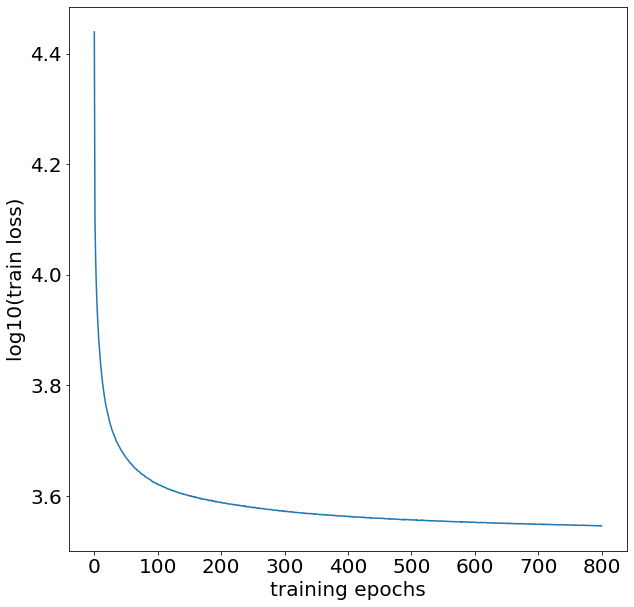

Have done [805 epochs/805001 iterations], avg loss is 3510.82007
Have done [810 epochs/810001 iterations], avg loss is 3512.15649
Have done [815 epochs/815001 iterations], avg loss is 3505.66040
Have done [820 epochs/820001 iterations], avg loss is 3510.77051
Have done [825 epochs/825001 iterations], avg loss is 3503.70728
Have done [830 epochs/830001 iterations], avg loss is 3506.24170
Have done [835 epochs/835001 iterations], avg loss is 3502.61084
Have done [840 epochs/840001 iterations], avg loss is 3502.43750
Have done [845 epochs/845001 iterations], avg loss is 3501.02808
Have done [850 epochs/850001 iterations], avg loss is 3500.70581
Have done [855 epochs/855001 iterations], avg loss is 3499.98877
Have done [860 epochs/860001 iterations], avg loss is 3495.79956
Have done [865 epochs/865001 iterations], avg loss is 3494.56152
Have done [870 epochs/870001 iterations], avg loss is 3497.11108
Have done [875 epochs/875001 iterations], avg loss is 3491.01587
Have done [880 epochs/880

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


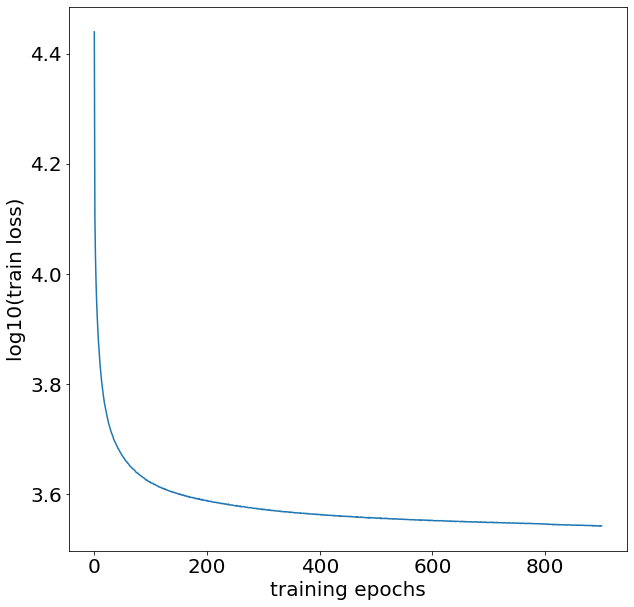

Have done [905 epochs/905001 iterations], avg loss is 3486.12183
Have done [910 epochs/910001 iterations], avg loss is 3485.49219
Have done [915 epochs/915001 iterations], avg loss is 3480.84375
Have done [920 epochs/920001 iterations], avg loss is 3478.34399
Have done [925 epochs/925001 iterations], avg loss is 3482.13354
Have done [930 epochs/930001 iterations], avg loss is 3478.00195
Have done [935 epochs/935001 iterations], avg loss is 3475.13159
Have done [940 epochs/940001 iterations], avg loss is 3475.36426
Have done [945 epochs/945001 iterations], avg loss is 3475.45996
Have done [950 epochs/950001 iterations], avg loss is 3471.81006
Have done [955 epochs/955001 iterations], avg loss is 3470.46753
Have done [960 epochs/960001 iterations], avg loss is 3471.57349
Have done [965 epochs/965001 iterations], avg loss is 3468.33521
Have done [970 epochs/970001 iterations], avg loss is 3465.59985
Have done [975 epochs/975001 iterations], avg loss is 3465.62744
Have done [980 epochs/980

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


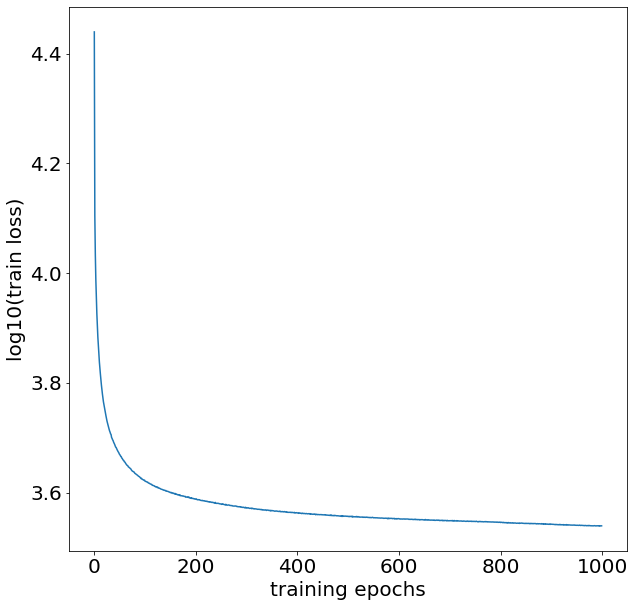

Training finishes!
Total 1000 epochs take time: 399.89 minutes


(FSNet(
   (convLayers): Sequential(
     (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
     (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): Conv1d(8, 16, kernel_size=(4,), stride=(2,))
     (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU()
   )
   (p0Layers): Sequential(
     (0): Linear(in_features=928, out_features=512, bias=True)
     (1): ReLU()
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): ReLU()
     (4): Linear(in_features=256, out_features=54, bias=True)
   )
   (resLayers): Sequential(
     (0): Linear(in_features=172, out_features=512, bias=True)
     (1): ReLU()
     (2): Linear(in_features=512, out_features=256, bias=True)
     (3): ReLU()
     (4): Dropout(p=0.25, inplace=False)
     (5): Linear(in_features=256, out_features=108, bias=True)
   )
 ), RCSNet(
   (convLayers): Sequential(
     (0): Conv1d(1, 8, kernel_

In [ ]:
conv1 = [1, 8, 3, 1, 1]
conv2 = [8, 16, 4, 2, 0]
fc1 = [int(16 * 58), 512]
fc2 = [512, 256]
fc3 = [256, 54]

fc4 = [118+54, 512]
fc5 = [512, 256]
fc6 = [256, 54 + 54]

fs_net = FSNet(conv1, conv2, fc1, fc2, fc3, fc4, fc5, fc6)
fs_net.to(device)
fs_net.load_state_dict(torch.load(savedPreTrainPath + 'pretrain_fs_net.pt'))
# fs_net.load_state_dict(torch.load(savedTrainPath + 'fsNet.pt'))


conv1 = [1, 8, 3, 1, 1]  # -> L' = 118 + 118 + 118 = 354
conv2 = [8, 16, 4, 2, 0]  # -> L' = 176
conv3 = [16, 8, 4, 2, 0]  # -> L' = 87
# fc params are arranged in in_features, out_features
fc1 = [int(8 * 87), 512]
fc2 = [512, 256]
fc3 = [256, 117]
rcs_net = RCSNet(conv1, conv2, conv3, fc1, fc2, fc3)
rcs_net.to(device)
rcs_net.load_state_dict(torch.load(savedPreTrainPath + 'pretrain_rcs_net.pt'))
# rcs_net.load_state_dict(torch.load(savedTrainPath + 'rcsNet.pt'))


X_Train = np.load(inputDemandPath + 'nnTrainData.npy') / inputScalingFactor
trainData = CustomPowerDataset(X_Train)

train(trainData, fs_net, rcs_net, lr=1e-4/2, numEpochs=1000,
      miniBatchSize=50, numScenarios=10, gamma_res=gammaRes, gamma_gen=gammaGen,)

train_hist: dict_keys(['train_losses', 'time_per_epoch', 'total_time'])
cost_hist: dict_keys(['c_fs', 'c_rcs', 'c_gen', 'c_res'])


[]

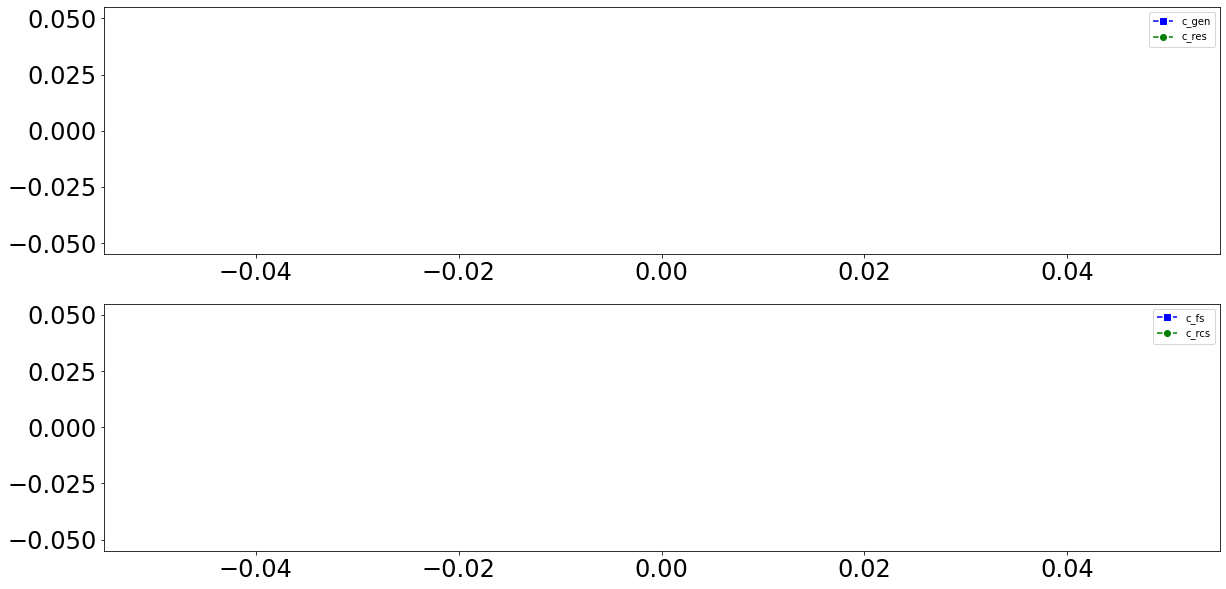

In [ ]:
train_hist = json.load(open(savedTrainPath + 'train_hist', 'r'))
cost_hist = json.load(open(savedTrainPath + 'cost_hist', 'r'))
print('train_hist:', train_hist.keys())
print('cost_hist:', cost_hist.keys())

c_gen = np.array(cost_hist['c_gen'][100:])
c_res = np.array(cost_hist['c_res'][100:])
c_fs = np.array(cost_hist['c_fs'][100:])
c_rcs = np.array(cost_hist['c_rcs'][100:])

fig, [ax0, ax1] = plt.subplots(2, 1, figsize=(20, 10))
ax0.plot(c_gen/1000, 'b--s', label='c_gen')
ax0.plot(c_res/1000, 'g--o', label='c_res')

ax1.plot(c_fs/1000, 'b--s', label='c_fs')
ax1.plot(c_rcs/1000, 'g--o', label='c_rcs')

for ax in [ax0, ax1]:
    ax.legend()
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
plt.plot()

## use trained

In [ ]:
def predict(fs_net, input_data):

    def get_fsCost(p0, rp, rd):
        regGenCost_arr = np.array(regGenCost).reshape(-1, 1)
        regGenPosResCost_arr = np.array(regGenPosResCost).reshape(-1, 1)
        regGenNegResCost_arr = np.array(regGenNegResCost).reshape(-1, 1)

        c_gen = p0 @ regGenCost_arr
        c_res = rp @ regGenPosResCost_arr + rd @ regGenNegResCost_arr

        c_fs = c_gen + c_res

        return c_fs, c_gen, c_res

    net_input = torch.tensor(input_data / inputScalingFactor).float().to(device)

    # define actual test size
    numTest = input_data.shape[0]
    batchMaxP_ts = maxP_ts.repeat(numTest, 1).to(device)
    batchMinP_ts = minP_ts.repeat(numTest, 1).to(device)

    with torch.no_grad():
        p0_pred, rp_pred, rd_pred, shifted_fsH = fs_net(net_input)
        # check if zero is a strict interior point of the shifted polytope
        assert torch.max(-shifted_fsH) < 0.0, "zero is not a strict interior point of polytope defined by (fsG, fs_h3)!"

        # print('p0_pred:', p0_pred.shape)
        # print('inter_fsSoln_ts:', inter_fsSoln_ts.shape)

        # shifted_p0 = p0_pred[:, regGenSet].T - inter_fsSoln_ts
        # print('shifted_p0:', shifted_p0.shape)

        # val = fsG_ts @ shifted_p0 - shifted_fsH  # this should be no larger than zero
        # print('val:', val.shape)
        # print('torch.max(val):', torch.max(val))
        # assert torch.max(val) <= 0.0

        # batch_SumDemand = net_input.sum(dim=1).reshape(1, -1)
        # batch_SumDemand *= inputScalingFactor
        # batch_fsH = torch.cat([-batch_SumDemand, fs_h_ts[1:, :].repeat(1, numTest)], dim=0)

        # print('inter_fsSoln_ts:', inter_fsSoln_ts)

        # val2 = fsG_ts @ p0_pred[:, regGenSet].T - batch_fsH  # this should be no larger than zero
        # print('val2:', val2.shape)
        # print('torch.max(val2):', torch.max(val2))

        # p0_pred = fs_output[:, :numRegGen]
        # rp_pred = fs_output[:, numRegGen:numRegGen+numRegGen]
        # rd_pred = fs_output[:, numRegGen+numRegGen:]

        # p0_pred2 = torch.zeros_like(p0_pred).to(device)
        # rp_pred2 = torch.zeros_like(rp_pred).to(device)
        # rd_pred2 = torch.zeros_like(rd_pred).to(device)

        # # for i in range(numRegGen):

        # #     p0_pred2[:, i] = (p0_pred[:, i] + 1.) / 2. * (regGenMaxP_ts[i] - regGenMinP_ts[i]) + regGenMinP_ts[i]
        # #     rp_pred2[:, i] = (rp_pred[:, i] + 1.) / 2. * (regGenMaxP_ts[i] - p0_pred2[:, i])
        # #     rd_pred2[:, i] = (rd_pred[:, i] + 1.) / 2. * (p0_pred2[:, i] - regGenMinP_ts[i])

        # p0_pred2 = (p0_pred + 1.) / 2. * (batchMaxP_ts - batchMinP_ts) + batchMinP_ts
        # rp_pred2 = (rp_pred + 1.) / 2. * (batchMaxP_ts - p0_pred2)
        # rd_pred2 = (rd_pred + 1.) / 2. * (p0_pred2 - batchMinP_ts)

        # predictions = torch.cat([p0_pred2, rp_pred2, rd_pred2], dim=1)

        # batch_fsH = fs_h_ts.repeat(1, numTest)
        # # use interior point to shift the polytope defined by fsG, batch_fsH
        # shifted_batch_fsH = batch_fsH - fsG_ts @ inter_fsSoln_ts

        # # gauge mapping: map B_infinity to shifted polytope
        # x_pred = gaugeMapping(fs_output.T, fsG_ts, shifted_batch_fsH) + inter_fsSoln_ts

        # # if fsConstrainID == 'addFSBalance':
        # #     # shift back
        # #     x_pred += inter_fsSoln_ts

        # x_pred = x_pred.T
        # x_pred = relu(x_pred)
        # x_pred_val = x_pred.cpu().detach().numpy() * inputScalingFactor

        # # extract p0_pred from x_pred
        # p0_pred = x_pred_val[:, :numRegGen]
        # r_up_pred = x_pred_val[:, numRegGen:numRegGen + numRegGen]
        # r_down_pred = x_pred_val[:, numRegGen + numRegGen:]

        # p0_pred2_val = p0_pred2.cpu().detach().numpy()
        # rp_pred2_val = rp_pred2.cpu().detach().numpy()
        # rd_pred2_val = rd_pred2.cpu().detach().numpy()

        # extend pred to full dimensions
        full_p0_pred = p0_pred.cpu().detach().numpy()

        full_rp_pred = rp_pred.cpu().detach().numpy()

        full_rd_pred = rd_pred.cpu().detach().numpy()


        sump0 = np.sum(full_p0_pred, axis=-1)
        print('sump0 shape:', sump0.shape)
        print('sump0:', sump0)

        batchDemand_val = net_input.cpu().detach().numpy() * inputScalingFactor
        batchSumDemand_val = np.sum(batchDemand_val, axis=-1)
        print('batchSumDemand_val shape:', batchSumDemand_val.shape)
        print('batchSumDemand_val:', batchSumDemand_val)

        
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.plot(sump0, 'b--o', lw=4, label='pred')
        # ax.bar(range(numTest), batchSumDemand_val, width=0.4, alpha=0.5, color='r',
        #             label='real')
        ax.plot(batchSumDemand_val, 'r--*', lw=4,
                    label='real')

        ax.legend(fontsize=24)
        ax.tick_params(axis='x', labelsize=24)
        ax.tick_params(axis='y', labelsize=24)
        # ax.set_ylim([550., 650.])
        plt.show()

        fsSolns_nn = dict()
        fsSolns_nn['p0'] = []
        fsSolns_nn['rp'] = []
        fsSolns_nn['rd'] = []
        for t in range(numTest):
            fsSolns_nn['p0'].append(full_p0_pred[t, :].tolist())
            fsSolns_nn['rp'].append(full_rp_pred[t, :].tolist())
            fsSolns_nn['rd'].append(full_rd_pred[t, :].tolist())

        c_fs, c_gen, c_res = get_fsCost(full_p0_pred[:, regGenSet], 
                                        full_rp_pred[:, regGenSet], full_rd_pred[:, regGenSet])


        fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(40, 10))
        ax0.plot(c_fs[:, 0], 'b--o', lw=4, label='pred')
        # ax0.legend(fontsize=24)

        ax1.boxplot([c_fs[:, 0]], sym='g+', labels=['pred'])
        # ax0.legend(fontsize=24)

        for ax in [ax0, ax1]:
            ax.tick_params(axis='x', labelsize=24)
            ax.tick_params(axis='y', labelsize=24)
        # ax.set_ylim([350., 400.])
        plt.show()
        print(c_fs.shape)

        fsSolns_nn['c_fs'] = list(c_fs[:, 0])
        fsSolns_nn['c_gen'] = list(c_gen[:, 0])
        fsSolns_nn['c_res'] = list(c_res[:, 0])

        # *========== DISPLAY FIRST STAGE SOLUTION ==========
        # display_fsSolns(input_data, fsSolns_nn, inputDemandPath, 'predByTrainedFSNet.png')

        # *========== EVALUATE SOLUTIONS ON TRUE MODEL ==========
        # evalSolns_nn, _ = evaluateFSSoln(input_data, numScenarios=100, fsSolns=fsSolns_nn,
        #                                  onWhichModel='LP', useGurobi=False, return_rcsSolns=False,
        #                                  gamma_res=10., gamma_gen=1e3, gamma_line=1e3,
        #                                  delta_gen=1., delta_line=0.95)

        # *========== SAVE RESULTS ==========
        # json.dump(fsSolns_nn, open(savedTrainPath + 'fsSolns_onTestSet_byNN', 'w'))
        json.dump(fsSolns_nn, open(savedTrainPath + 'fsSolns_test_nn200', 'w'))
        # json.dump(evalSolns_nn, open(savedTrainPath + 'evalSolns_onTestSet_byNN', 'w'))

        return fsSolns_nn


In [ ]:
conv1 = [1, 8, 3, 1, 1]
conv2 = [8, 16, 4, 2, 0]
fc1 = [int(16 * 58), 512]
fc2 = [512, 256]
fc3 = [256, 54]

fc4 = [118+54, 512]
fc5 = [512, 256]
fc6 = [256, 54 + 54]

fs_net = FSNet(conv1, conv2, fc1, fc2, fc3, fc4, fc5, fc6)
fs_net.to(device)


conv1 = [1, 8, 3, 1, 1]  # -> L' = 118 + 118 + 118 = 354
conv2 = [8, 16, 4, 2, 0]  # -> L' = 176
conv3 = [16, 8, 4, 2, 0]  # -> L' = 87
# fc params are arranged in in_features, out_features
fc1 = [int(8 * 87), 512]
fc2 = [512, 256]
fc3 = [256, 117]
rcs_net = RCSNet(conv1, conv2, conv3, fc1, fc2, fc3)
rcs_net.to(device)

RCSNet(
  (convLayers): Sequential(
    (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(8, 16, kernel_size=(4,), stride=(2,))
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(16, 8, kernel_size=(4,), stride=(2,))
    (7): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
  )
  (fcLayers): Sequential(
    (0): Linear(in_features=696, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=117, bias=True)
  )
)

sump0 shape: (200,)
sump0: [426.9792  415.60437 422.47842 421.6751  422.15372 423.49713 417.2759
 414.59756 433.38702 418.2552  422.59387 429.14664 431.11108 430.36224
 415.5102  427.85043 417.65854 430.91766 420.39926 422.27298 427.1612
 431.0276  415.82672 425.44006 431.31665 421.4376  432.35822 418.8609
 424.9684  413.31018 433.89917 413.87805 408.8924  418.06125 419.7381
 418.77222 418.38184 418.5507  428.77966 425.3543  425.33447 421.8544
 423.83347 424.04303 408.83224 427.62744 431.61588 419.04352 426.59122
 427.60953 423.81006 424.2206  432.4928  424.6866  429.5241  408.90607
 408.66376 432.21216 419.8345  417.24722 425.52756 417.6021  426.06097
 432.36618 426.02884 422.65146 430.12466 426.56067 416.94214 421.688
 432.64618 423.8766  431.27094 437.51767 434.10092 430.09433 420.45895
 416.09708 432.38507 417.86307 424.87613 422.4563  431.36673 422.1696
 424.3716  428.68784 417.05988 412.9434  416.85254 415.1728  411.06427
 429.6359  419.20773 439.24564 435.6009  440.00894 427.843

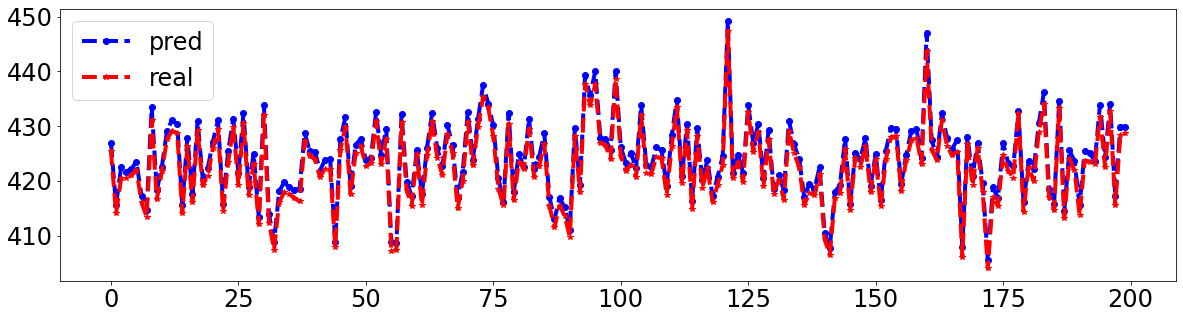

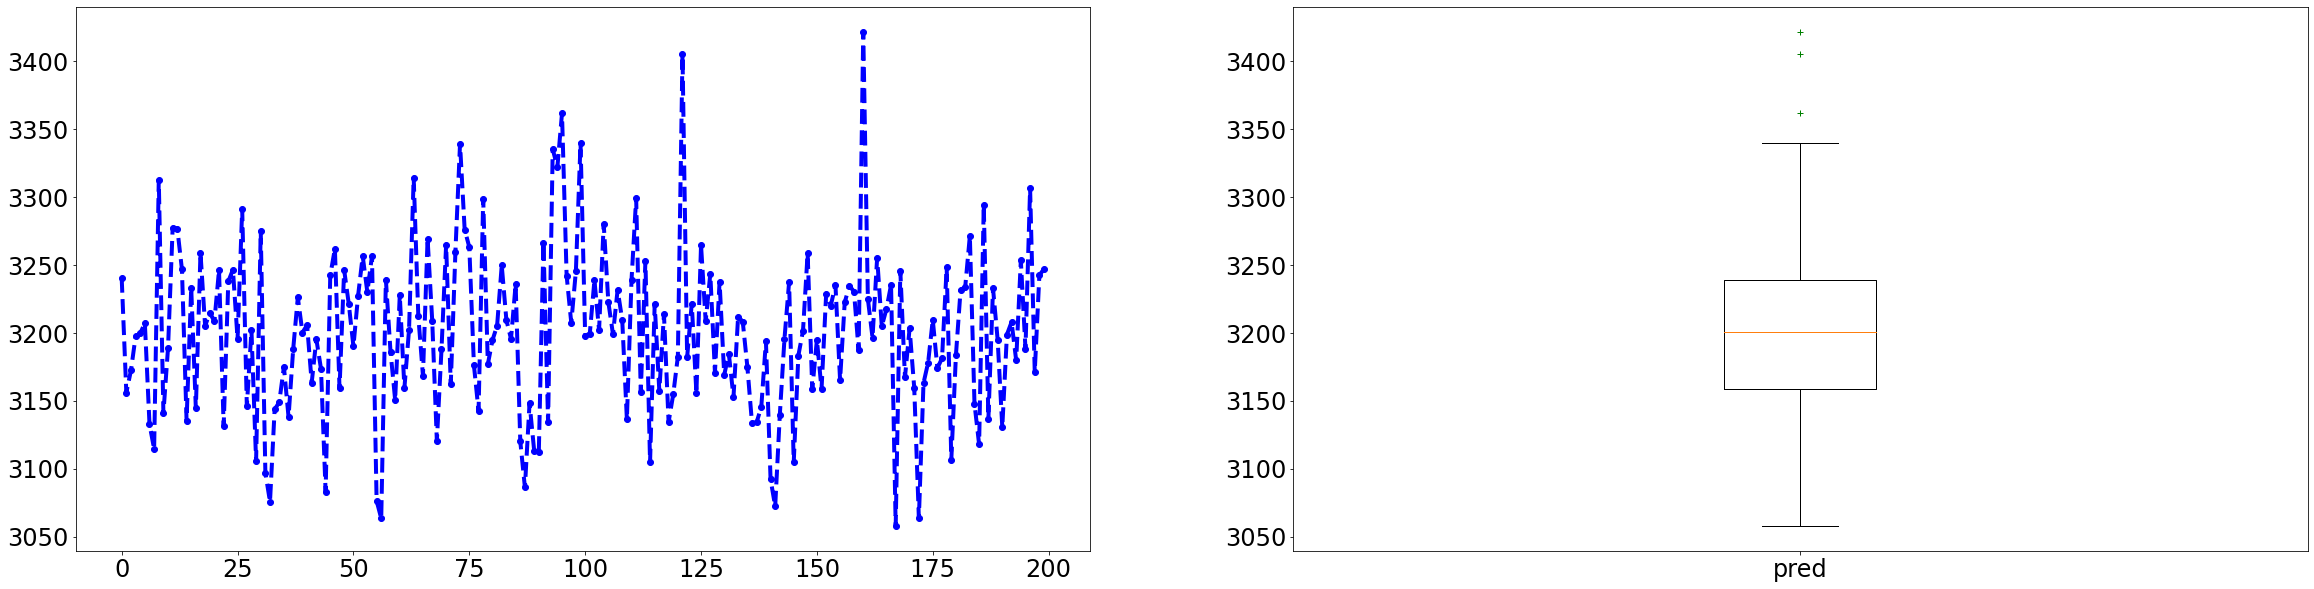

(200, 1)


In [ ]:
# *========== CONSTRUCT NEURAL NETWORK ARCHITECTURES ==========

# *========== LOAD TRAINED NEURAL NETWORK ==========
fs_net.load_state_dict(torch.load(savedTrainPath + '999fsNet.pt'))
# fs_net.load_state_dict(torch.load(savedTrainPath + '0fsNet.pt'))
# turn off drop-out layers
fs_net.eval()

# load dataset
X_Test = np.load(inputDemandPath + 'nnTestData.npy')
inputDemands = X_Test[:200, :]
fsSolns_onTestSet_byNN = predict(fs_net, inputDemands)

426.9791603088379


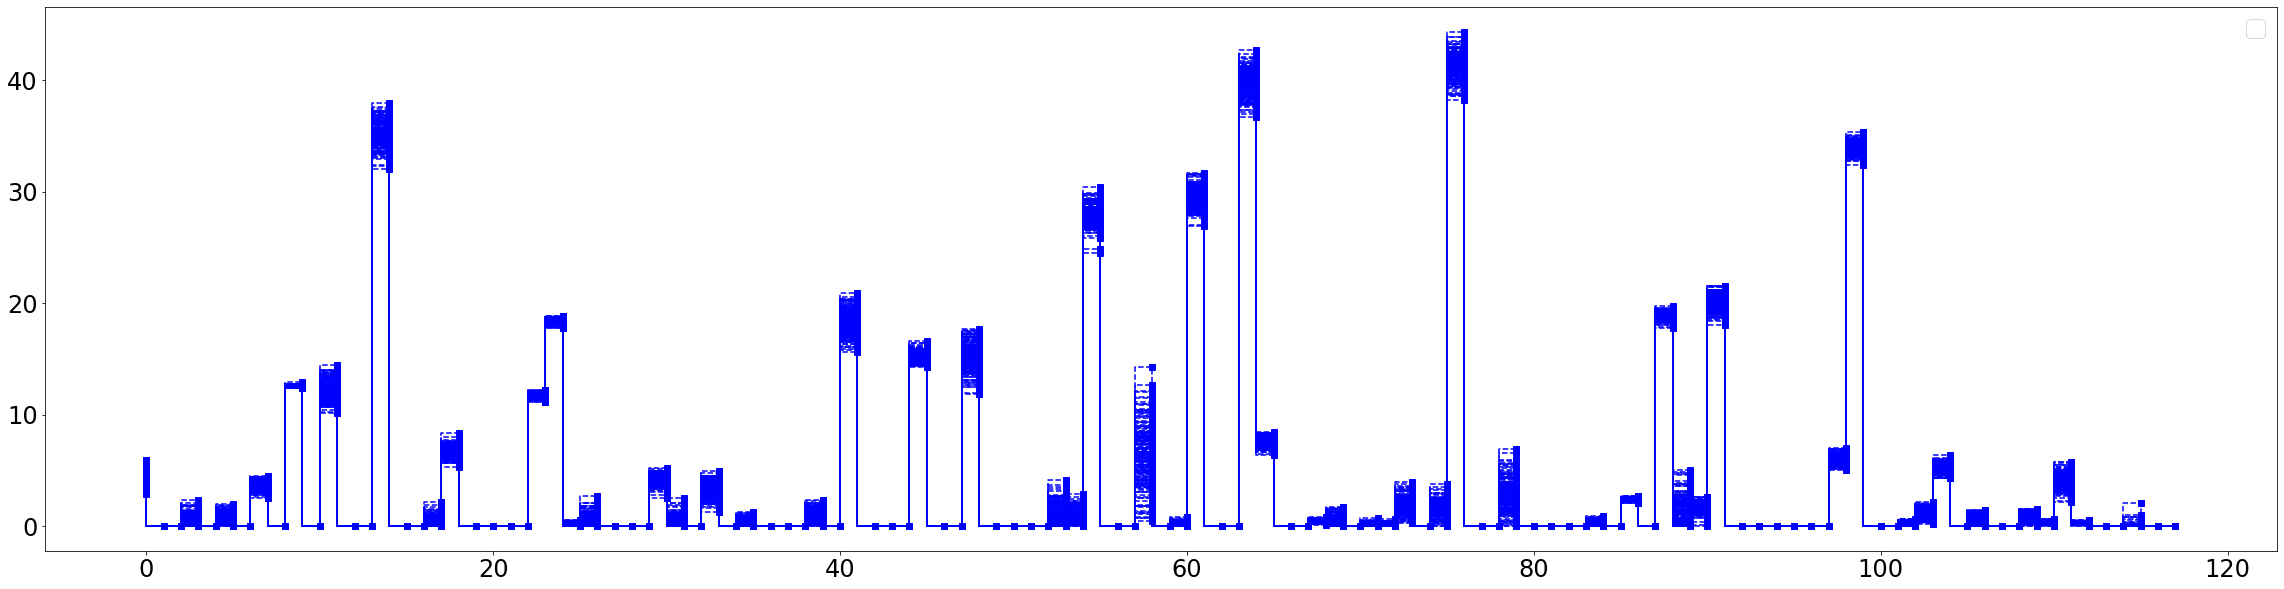

In [ ]:
fsSolns_onTestSet_byNN.keys()
p0_nn = np.array(fsSolns_onTestSet_byNN['p0'])
rp_nn = np.array(fsSolns_onTestSet_byNN['rp'])
rd_nn = np.array(fsSolns_onTestSet_byNN['rd'])

fig, ax = plt.subplots(figsize=(40, 10))

# ax.bar(range(numBuses), p0_true[0, :], width=0.4, alpha=0.5, color='r', label=r'$p_0^{*}$')
for i in range(p0_nn.shape[0]):
    ax.step(p0_nn[i, :], 'b--s')

print(np.sum(p0_nn[0, :]))

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.legend(fontsize=24)
plt.show()

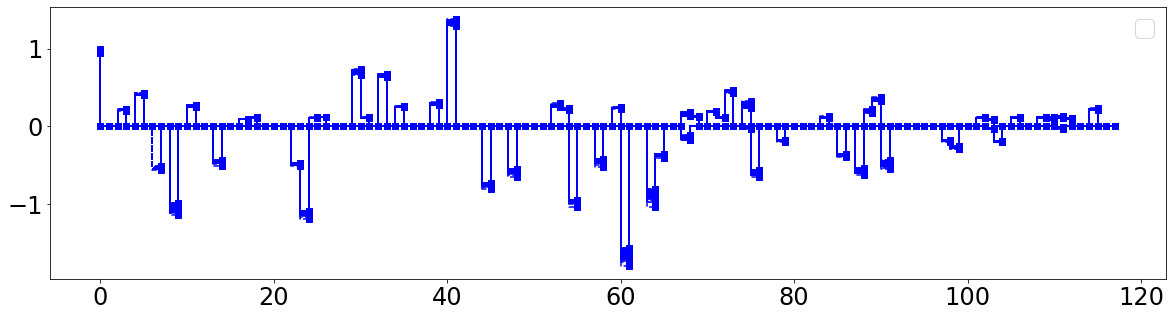

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))

# ax.bar(range(numBuses), rp_true[0, :], width=0.4, alpha=0.5, color='r', label='*')
# ax.bar(range(numBuses), -rd_true[0, :], width=0.4, alpha=0.5, color='r')
# ax.plot(rp_P[0, :], 'b--', label='penalty')
# ax.plot(-rd_P[0, :], 'b--')
for i in range(p0_nn.shape[0]):
    ax.step(rp_nn[i, :], 'b--s')
    ax.step(-rd_nn[i, :], 'b--s')

ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=24)

ax.legend(fontsize=24)
plt.show()

In [ ]:
print(fsSolns_onTestSet_byNN['c_gen'][:10])
print(fsSolns_onTestSet_byNN['c_res'][:10])

[2978.922152471185, 2893.642033417511, 2907.7581814169403, 2939.26822552433, 2938.571604641867, 2947.146698895788, 2871.7676524670596, 2860.182489140892, 3050.0513650074004, 2881.048740283465]
[261.61554803706406, 262.440007113424, 264.7504784198284, 258.2597401277773, 261.2413974946328, 260.0804739725769, 261.1350067773633, 254.47474627982675, 262.53701590533035, 259.93761054329127]


In [ ]:
# fsSolns_onTestSet_byP = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byP', 'r'))
# fsSolns_onTestSet_byTrue = json.load(open(savedTrainPath + 'fsSolns_onTestSet_byTrue', 'r'))

## use trained rcs net

In [ ]:
# *========== MAKE PREDICTIONS ==========
def to_n_dim(x, n):
        m = x.shape[0]
        x_ = np.zeros((m, n))
        x_[:, regGenSet] = x
        return x_

def solve_recourse(model, net_d_omega_data, input_data, target=None):
    net_d_omega = torch.tensor(net_d_omega_data).float().to(device)
    net_input = torch.tensor(input_data).float().to(device)
    print('net_input:', net_input.shape)

    # define actual test size
    numTest = input_data.shape[0]

    # *========== LOAD TRAINED NEURAL NETWORK ==========
    model.load_state_dict(torch.load(savedTrainPath + '999rcsNet.pt'))
    # turn off drop-out layers
    model.eval()

    with torch.no_grad():

        theta_pred, full_y_pred = model(net_input)
        print('theta_pred:', theta_pred.shape)

        y_pred = full_y_pred[:, regGenSet]

        theta_pred_val = theta_pred.cpu().detach().numpy()
        full_y_pred_val = full_y_pred.cpu().detach().numpy()
        y_pred_val = y_pred.cpu().detach().numpy()

        fig, axes = plt.subplots(2, 1, figsize=(50, 20))
        for i in range(numTest):
            if i == 0:
                axes[0].step(theta_pred_val[i, :], 'm--', linewidth=2, markersize=12, label=r'$\hat{\theta}$')

                axes[1].step(input_data[i, :numBuses], 'y--', linewidth=2, markersize=12, label=r'$\tilde{d}$')
                axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{y}$')
            else:
                axes[0].step(theta_pred_val[i, :], 'm--', linewidth=2, markersize=12)

                axes[1].step(input_data[i, :numBuses], 'y--', linewidth=2, markersize=12)
                axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12)

        axes[0].axhline(y=theta_max, color='lightgrey', linestyle='--', linewidth=4, )
        axes[0].axhline(y=-theta_max, color='lightgrey', linestyle='--', linewidth=4, )

        for ax in axes:
            ax.legend(fontsize=24)
            ax.tick_params(axis='x', labelsize=24)
            ax.tick_params(axis='y', labelsize=24)

        plt.show()

        if target is not None:

            theta_target = target[:, :numBuses]
            theta_target_nonslack = np.concatenate([theta_target[:, :slackBusNo], theta_target[:, slackBusNo+1:]], axis=-1)
            y_target = target[:, numBuses:]
            full_y_target = y_target

            print('full_y_target:', full_y_target.shape)
            print('full_y_pred_val:', full_y_pred_val.shape)
            print('theta_target_nonslack:', theta_target_nonslack.shape)
            print('theta_pred_val:', theta_pred_val.shape)

            print(r'Prediction error of $\theta$ is %.4f' % measure_relative_distance(theta_target_nonslack, theta_pred_val))
            print(r'Prediction error of y is %.4f' % measure_relative_distance(full_y_target, full_y_pred_val))

            fig, axes = plt.subplots(2, 1, figsize=(50, 20))
            for i in range(numTest):
                if i == 0:
                    axes[0].step(theta_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{\theta}$')
                    axes[0].step(theta_target_nonslack[i, :], 'r--', linewidth=2, markersize=12, label=r'${\theta}^{*}$',
                                 alpha=0.5)

                    axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12, label=r'$\hat{y}$')
                    axes[1].step(full_y_target[i, :], 'r--', linewidth=2, markersize=12, label=r'${y}^{*}$', alpha=0.5)
                    # axes[1].step(y_pred2[i, :], 'r--', linewidth=2, markersize=12, label=r'${y}^{*}$', alpha=0.5)
                else:
                    axes[0].step(theta_pred_val[i, :], 'b--', linewidth=2, markersize=12)
                    axes[0].step(theta_target_nonslack[i, :], 'r--', linewidth=2, markersize=12, alpha=0.5)

                    axes[1].step(full_y_pred_val[i, :], 'b--', linewidth=2, markersize=12)
                    axes[1].step(full_y_target[i, :], 'r--', linewidth=2, markersize=12, alpha=0.5)
                    # axes[1].step(y_pred2[i, :], 'r--', linewidth=2, markersize=12, alpha=0.5)

            axes[0].axhline(y=theta_max, color='lightgrey', linestyle='--', linewidth=4, )
            axes[0].axhline(y=-theta_max, color='lightgrey', linestyle='--', linewidth=4, )

            for ax in axes:
                ax.legend(fontsize=24)
                ax.tick_params(axis='x', labelsize=24)
                ax.tick_params(axis='y', labelsize=24)

            plt.show()


net_input: (10, 354)
net_input: torch.Size([10, 354])
theta_pred: torch.Size([10, 117])


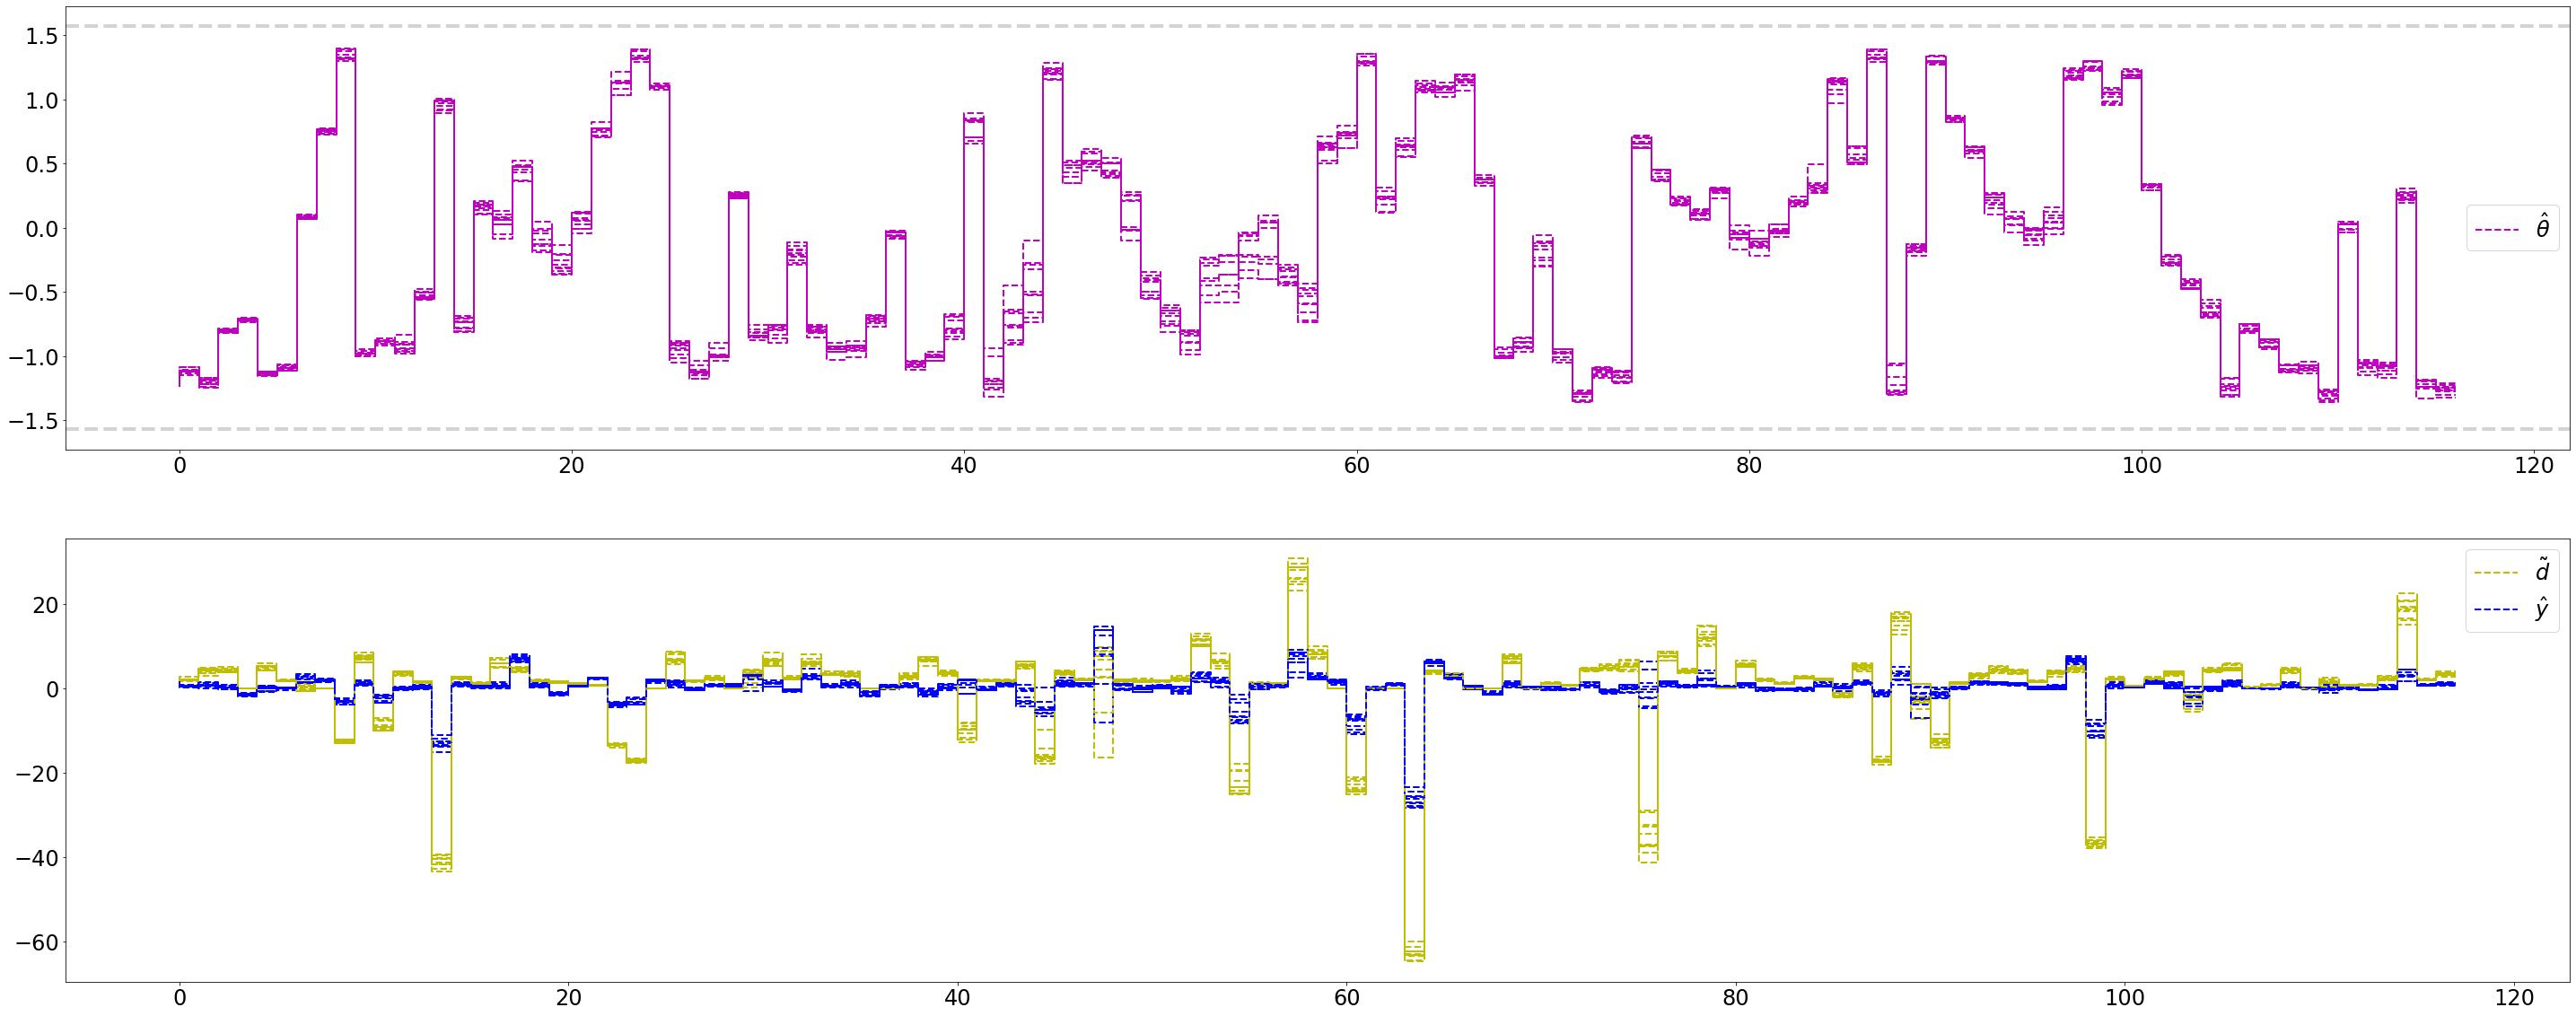

full_y_target: (10, 118)
full_y_pred_val: (10, 118)
theta_target_nonslack: (10, 117)
theta_pred_val: (10, 117)
Prediction error of $\theta$ is 0.3242
Prediction error of y is 22.5885


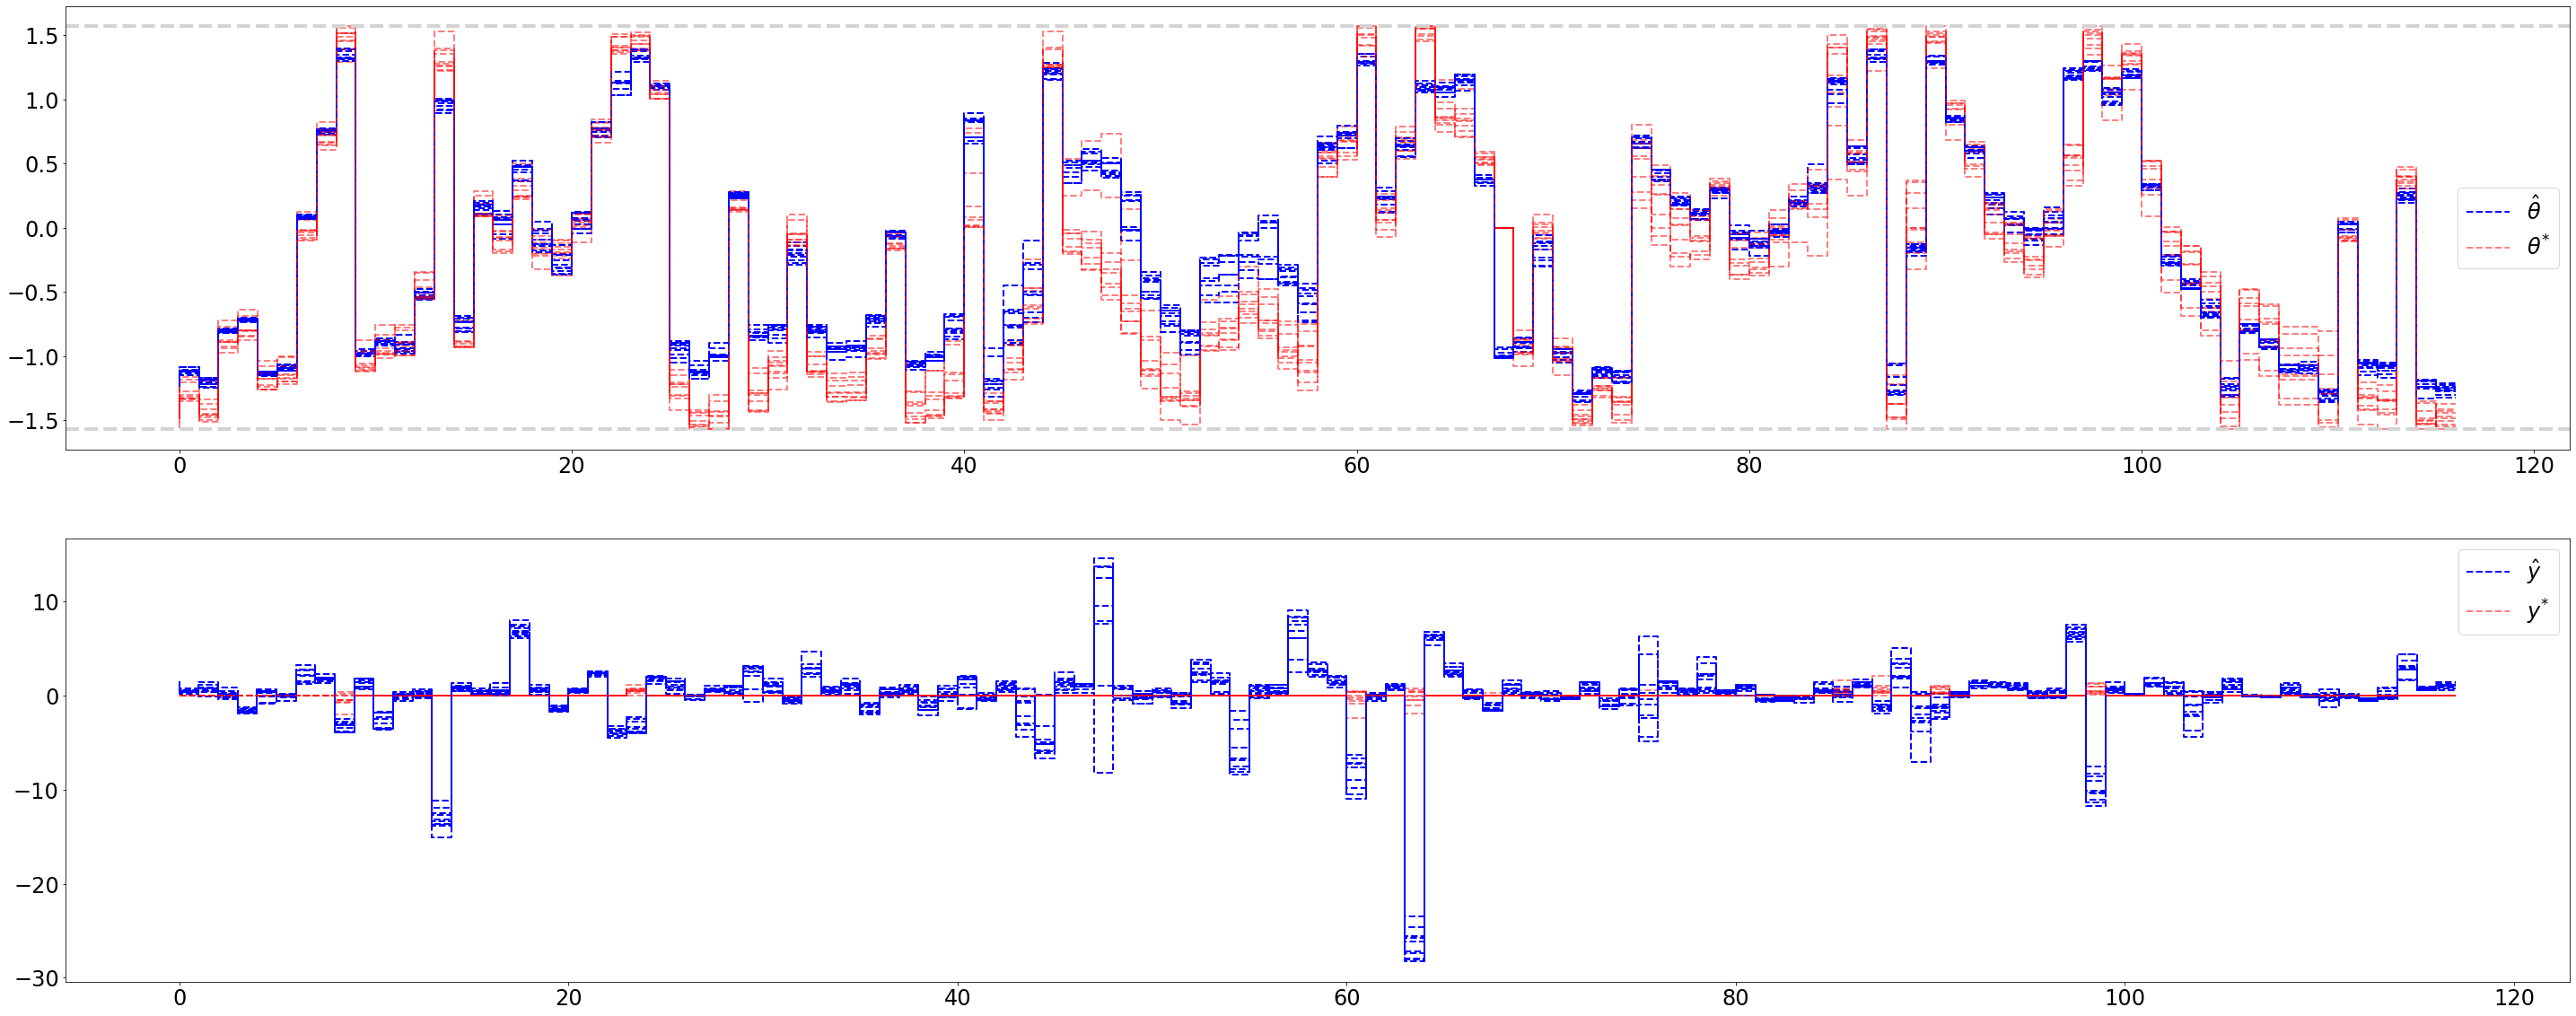

In [ ]:
# *========== TEST ON TRAIN  ==========

X_preTrain2 = np.load(inputDemandPath + 'X_preTrain2.npy')
input_data = X_preTrain2

d_omega = input_data[:, :numBuses]
target = input_data[:, numBuses:]

p0_target = target[:, :numBuses]
rp_target = target[:, numBuses:numBuses+numBuses]
rd_target = target[:, numBuses+numBuses:numBuses+numBuses+numBuses]

rcs_target = target[:, numBuses+numBuses+numBuses:]

theta_target = rcs_target[:, :numBuses]
y_target = rcs_target[:, numBuses:]

p0_extension = p0_target

net_d_omega = d_omega - p0_extension

net_input = np.concatenate([net_d_omega, rp_target, rd_target], axis=1)
print('net_input:', net_input.shape)
# if featureEngOption:
# net_input = torch.cat([relu(net_d_omega),
#                        -relu(-net_d_omega)], dim=1)


# fig, ax = plt.subplots(figsize=(40, 10))
# ax.step(range(118), net_d_omega[0, :])
# ax.step(range(118), rcs_target[0, :118])
# ax.step(range(118), rcs_target[0, 118:])
# ax.step(range(54), -rd_target[0, :])

# plt.show()
solve_recourse(rcs_net, net_d_omega, net_input, rcs_target)

